# Initialize

In [3]:
%load_ext autoreload
%autoreload 2

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

import sys
sys.path.append('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders')

from AE.models import AE_0, ProgressiveAE
from AE.datasets import MNISTDigit2Dataset, MNISTDigit2OnlyDataset, FEMNISTDataset

from AE.depth_utils import calc_hfm_kld_with_optimal_g, compute_bottleneck_neurons_activ_freq, compute_emp_states_dict_gauged, compute_bottleneck_neurons_activ_freq_gauged, compute_dataset_klds_gs_dict_with_optimal_threshold_, compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_
from AE.plotter_functions import visualize_bottleneck_neurons, plot_KLs_vs_hidden_layers, datasets_dicts_comparison
from AE.plotter_functions import datasets_dicts_comparison_colored

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)


Utilizzo Apple Silicon GPU (MPS)



# Datasets


In [5]:
batch_size = 64

## MNIST
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## ExtendedMNIST

train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )


## 2MNIST

dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")





dataset_2MNISTonly_train = MNISTDigit2OnlyDataset(train=True, download=True)
train_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_train, batch_size=batch_size, shuffle=True)

dataset_2MNISTonly_val = MNISTDigit2OnlyDataset(train=False, download=True)
val_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_val, batch_size=batch_size, shuffle=True)


#-------------------------------------------------------------------


datasets = ["MNIST", "EMNIST", "2MNIST", "2MNISTonly"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNIST": train_loader_2MNIST,
    "2MNISTonly": train_loader_2MNISTonly
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNIST": val_loader_2MNIST,
    "2MNISTonly": val_loader_2MNISTonly
}


Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True
Found 5958 samples of digit '2'
Found 1032 samples of digit '2'


In [5]:
batch_size = 64


train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )




dataset_2MNISTonly_train = MNISTDigit2OnlyDataset(train=True, download=True)
train_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_train, batch_size=batch_size, shuffle=True)

dataset_2MNISTonly_val = MNISTDigit2OnlyDataset(train=False, download=True)
val_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_val, batch_size=batch_size, shuffle=True)




datasets = ["MNIST", "EMNIST", "2MNISTonly"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNISTonly": train_loader_2MNISTonly
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNISTonly": val_loader_2MNISTonly
}

Found 5958 samples of digit '2'
Found 1032 samples of digit '2'


In [6]:
dataset_FEMNIST_train = FEMNISTDataset(train=True, download=True)
train_loader_FEMNIST = DataLoader(dataset_FEMNIST_train, batch_size=batch_size, shuffle=True)
dataset_FEMNIST_val = FEMNISTDataset(train=False, download=True)
val_loader_FEMNIST = DataLoader(dataset_FEMNIST_val, batch_size=batch_size, shuffle=True)


train_loaders["FEMNIST"] = train_loader_FEMNIST
val_loaders["FEMNIST"] = val_loader_FEMNIST

In [10]:
print(len(train_loader_FEMNIST.dataset))

172800


In [175]:

## FashionMNIST

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



AttributeError: 'list' object has no attribute 'FashionMNIST'


## OTHERS


In [ ]:
from AE.datasets import Dataset_HFM, Dataset_pureHFM

batch_size = 64


## train over pureHFM

dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)
## train over expandedHFM
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)
## train over expandedHFM 32-1024
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)


# Encoder output: Sigmoid

# ----- Simultaneous train -----

## HFM KLD

### 20 features

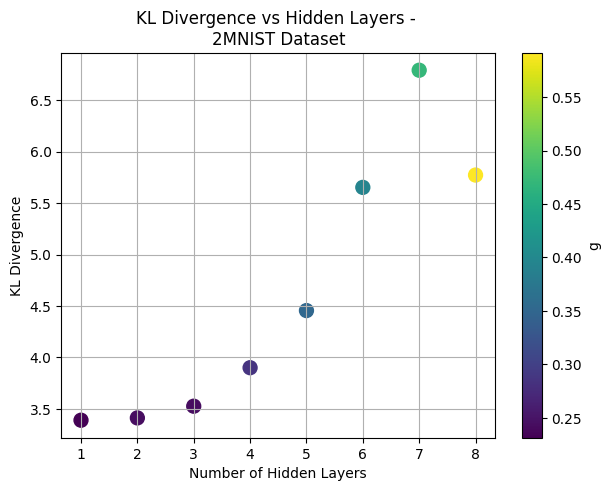

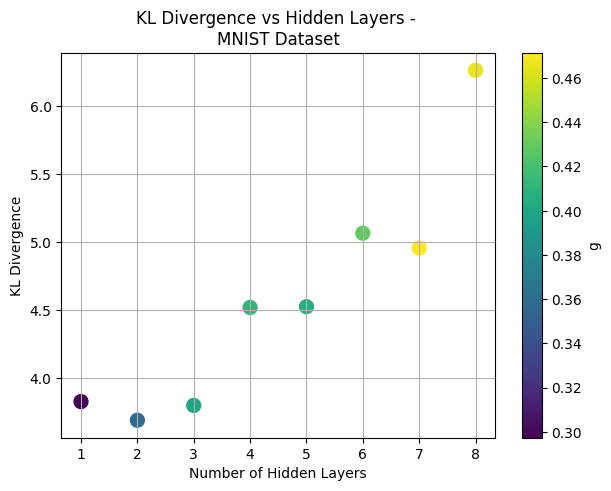

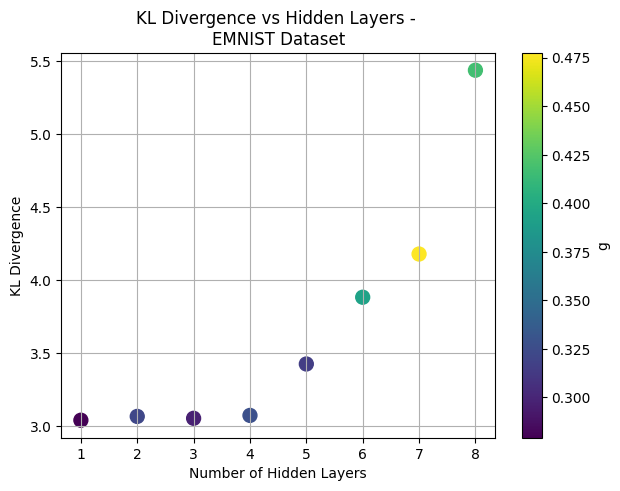

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 28 * 28

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"], "2MNIST")


#------------------------------------------------------

train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 28 * 28

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["MNIST"], gs_dict["MNIST"], "MNIST")


#------------------------------------------------------


train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 28 * 28

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))
KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["EMNIST"], gs_dict["EMNIST"], "EMNIST")




In [ ]:
import pickle

with open('KLs_dict.pkl', 'wb') as f:
    pickle.dump(KLs_dict, f)



In [ ]:
import pickle
with open('KLs_dict.pkl', 'rb') as f:
    KLs_dict = pickle.load(f)

In [ ]:
import copy
KLs_dict = copy.deepcopy(KLs_dict)

KLs_dict["2MNIST"].pop()
KLs_dict["MNIST"].pop()
KLs_dict["EMNIST"].pop()

NameError: name 'KLs_dict' is not defined

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

### 6 features

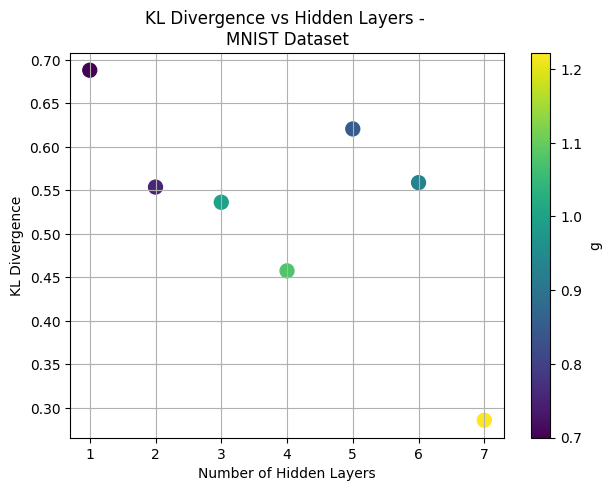

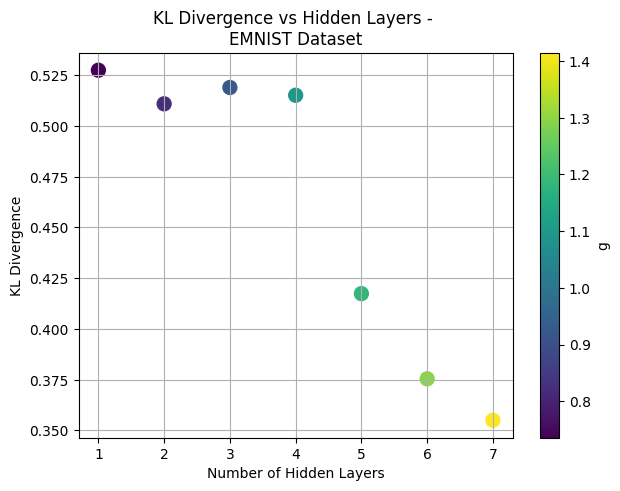

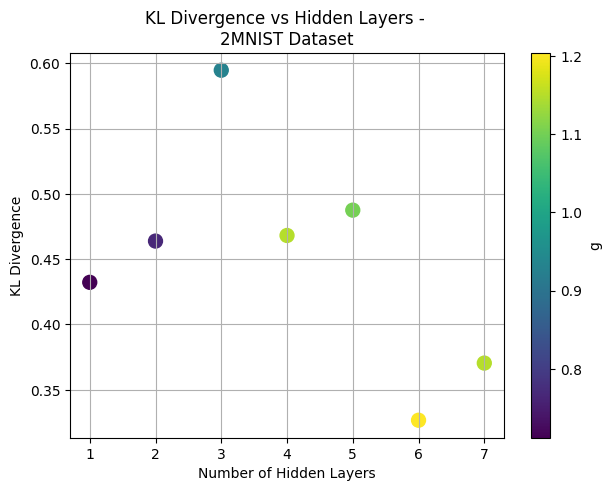

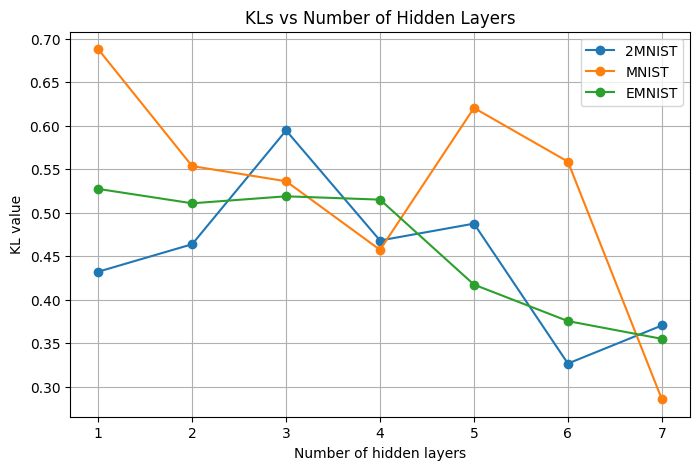

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,8):    # 1-7 hl
        latent_dim = 6
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

### 8 features

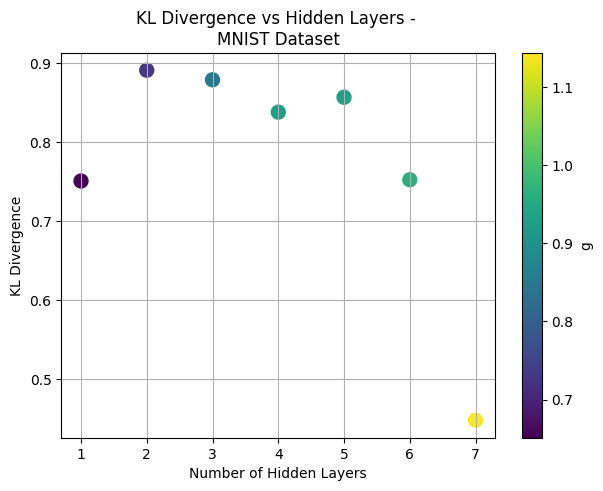

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in ("MNIST",):
    
    for num_hidden_layers in range(1,8):    # 1-7 hl
        latent_dim = 8
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        binarize_threshold = 0.8

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        #save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{binarize_threshold}"
        save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

#datasets_dicts_comparison(KLs_dict, save_dir)

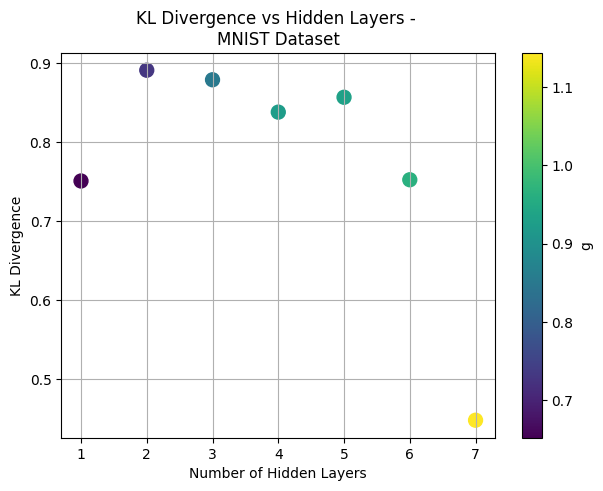

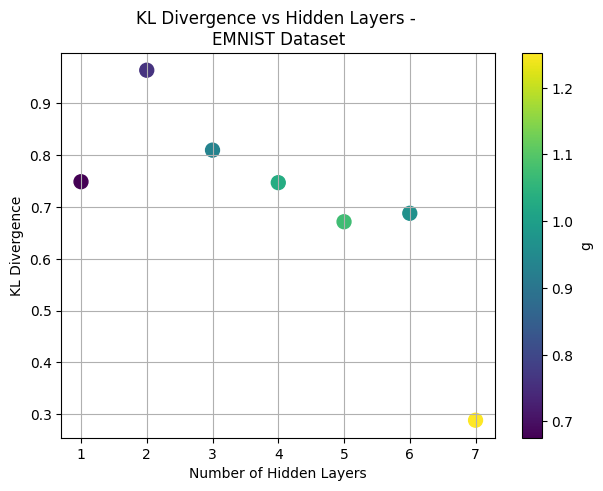

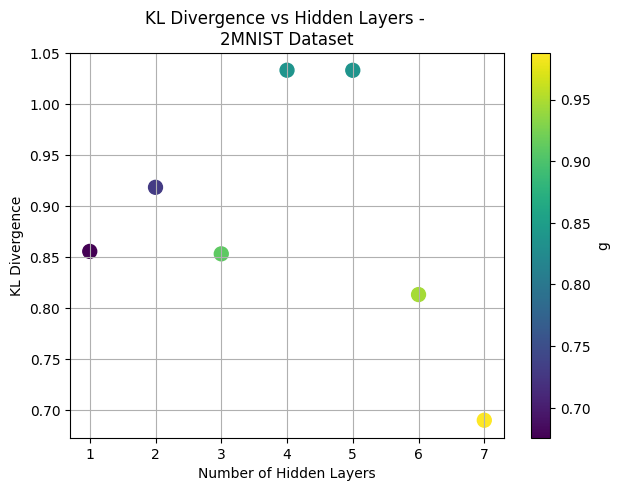

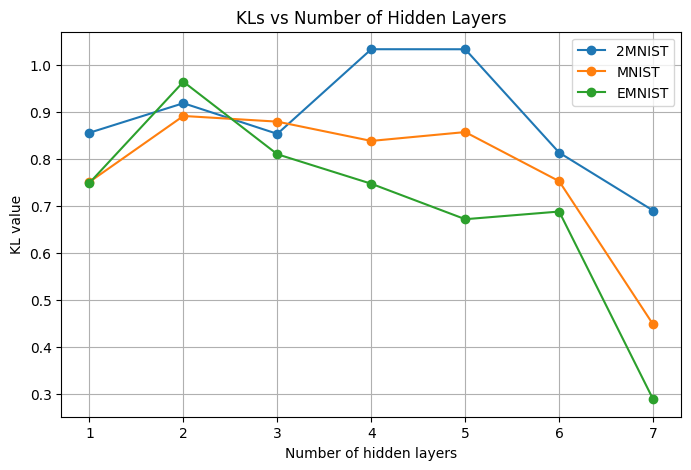

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,8):    # 1-7 hl
        latent_dim = 8
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

### 10 features

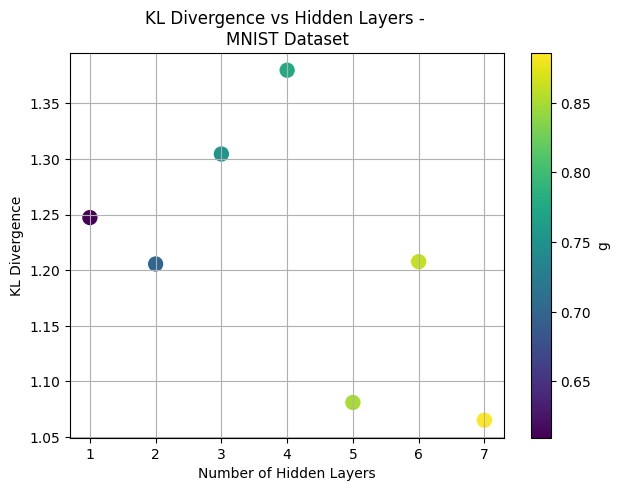

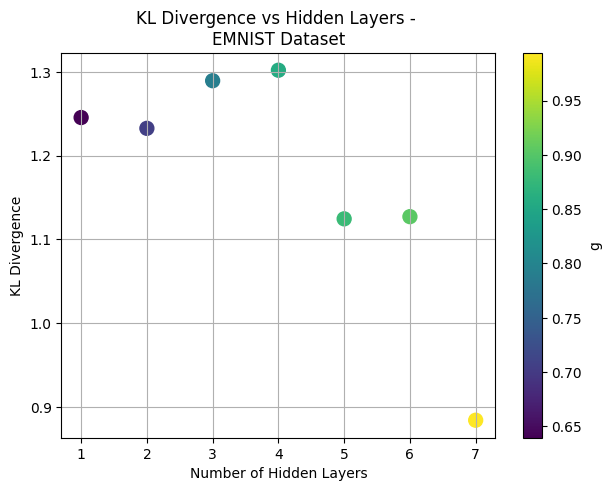

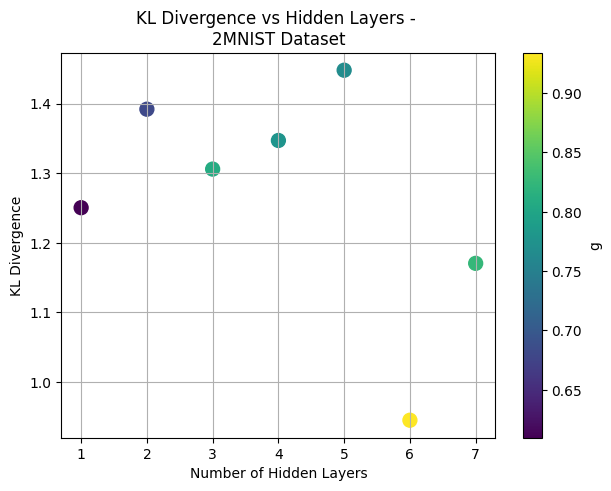

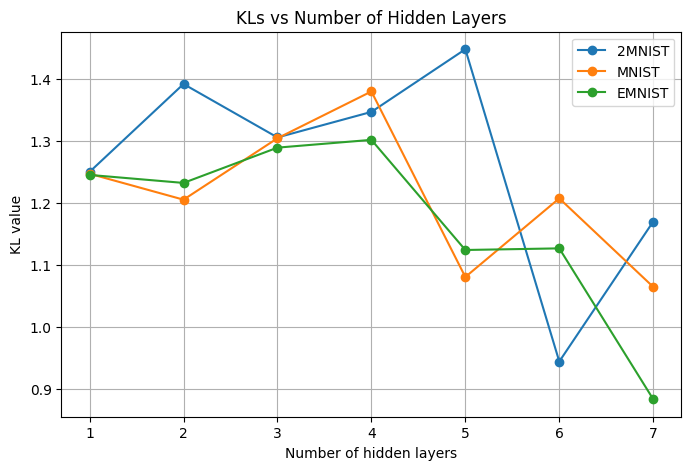

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,8):    # 1-7 hl
        latent_dim = 10
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

    save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{threshold_for_binarization}"
    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

### 2_M_E_MNIST

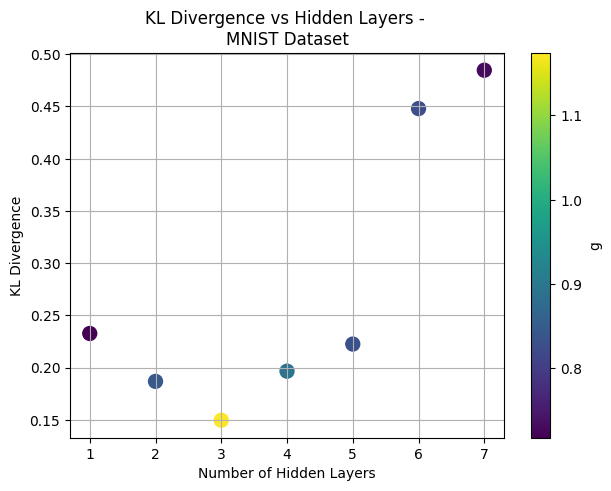

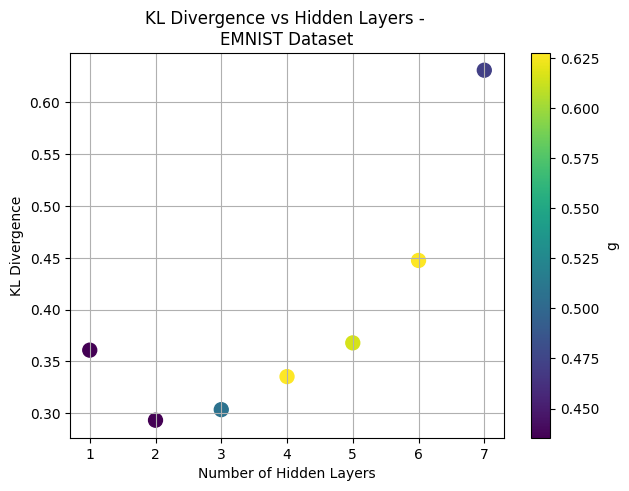

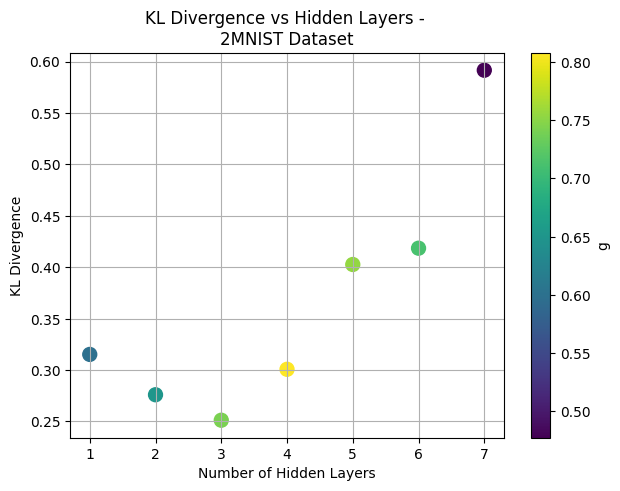

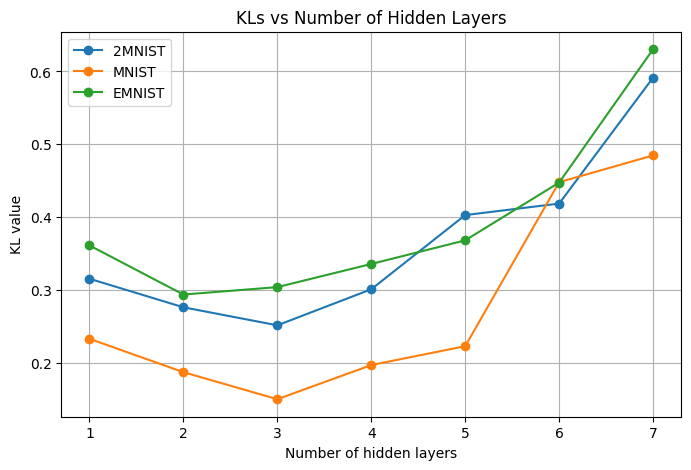

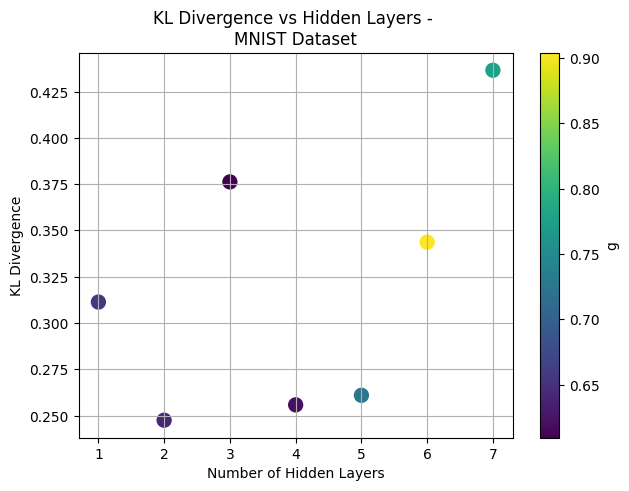

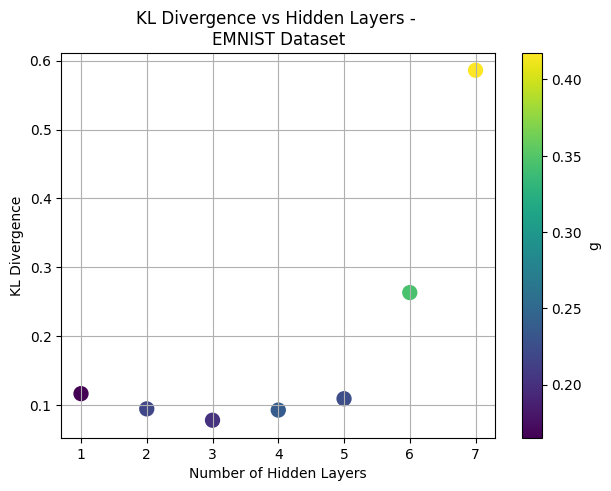

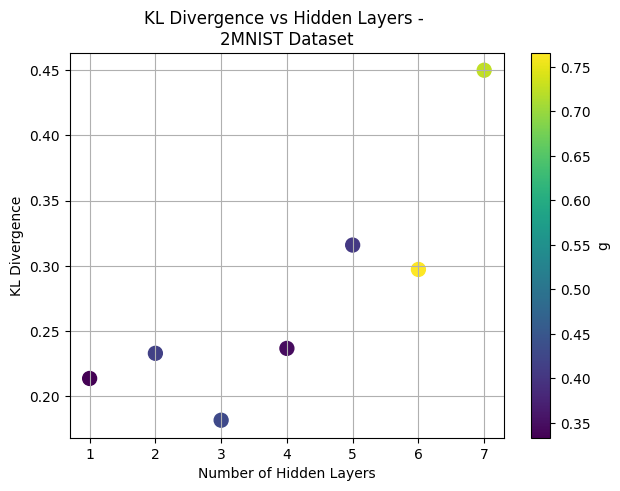

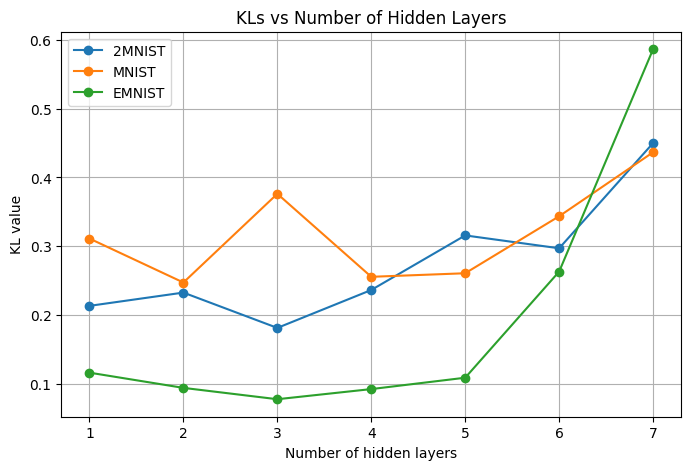

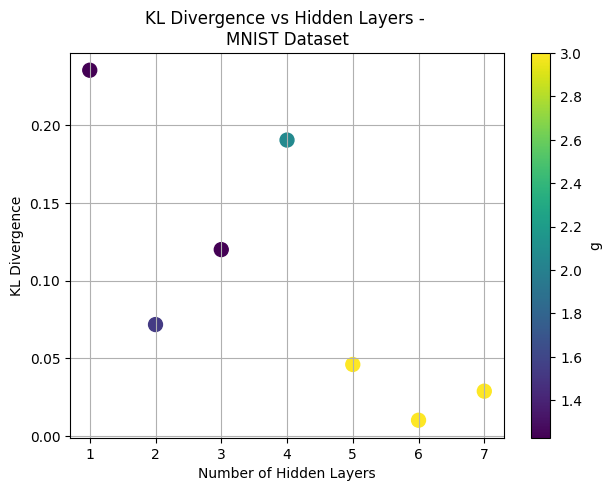

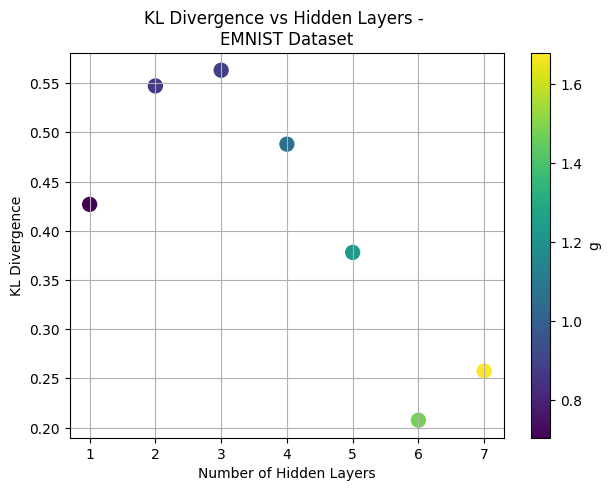

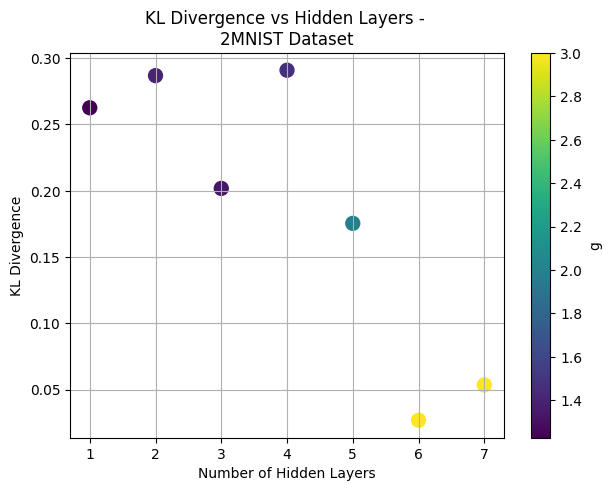

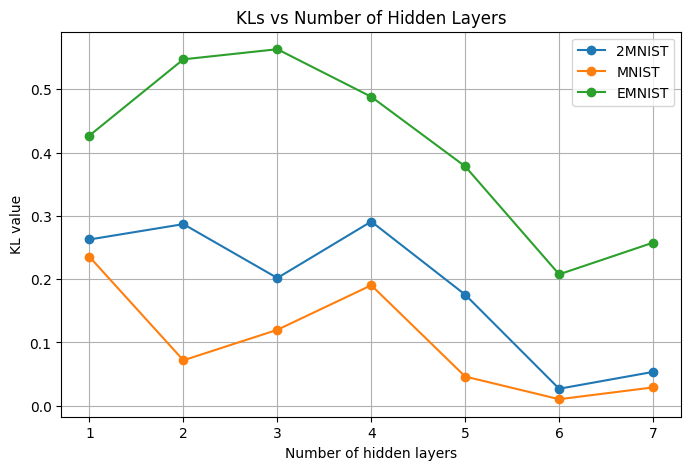

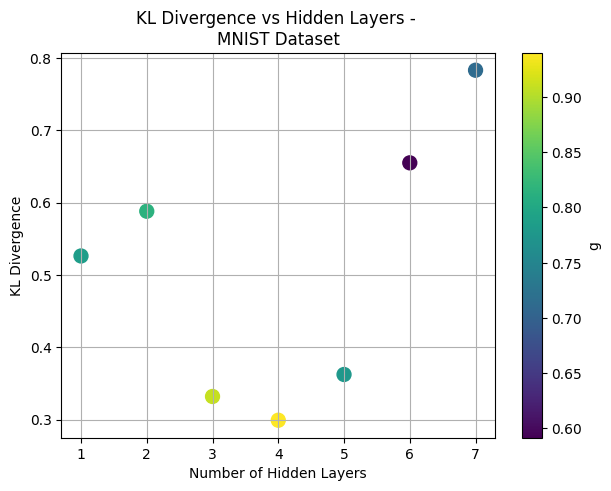

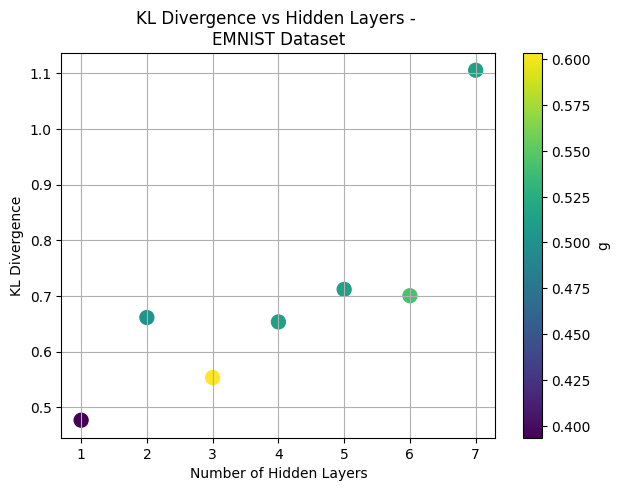

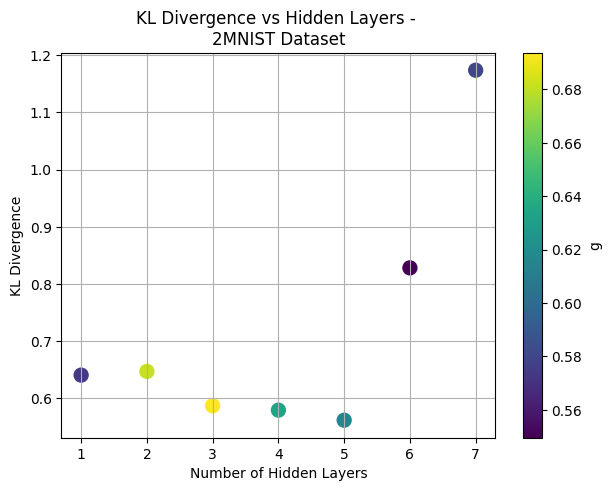

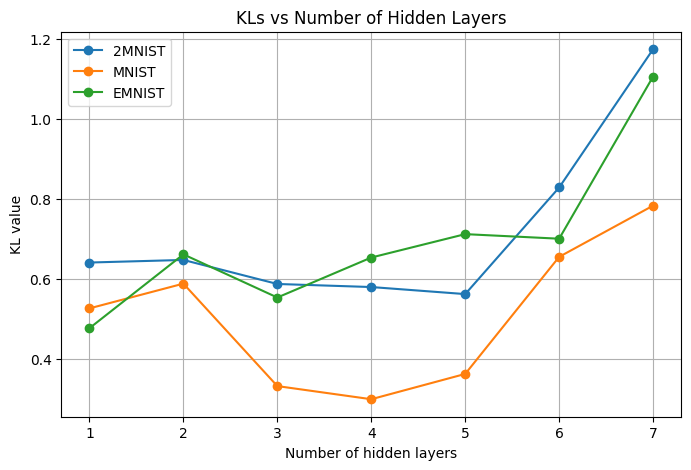

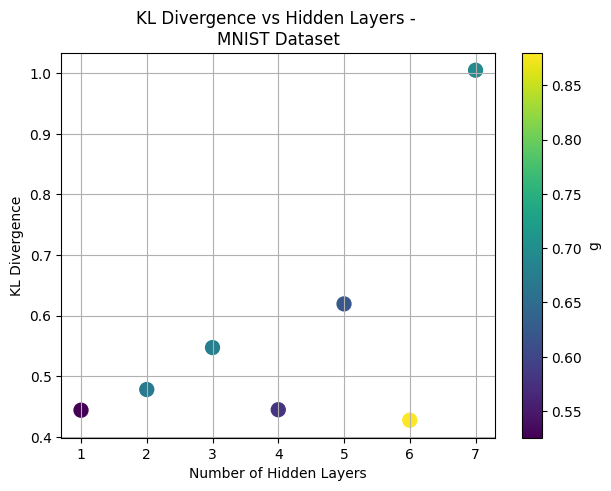

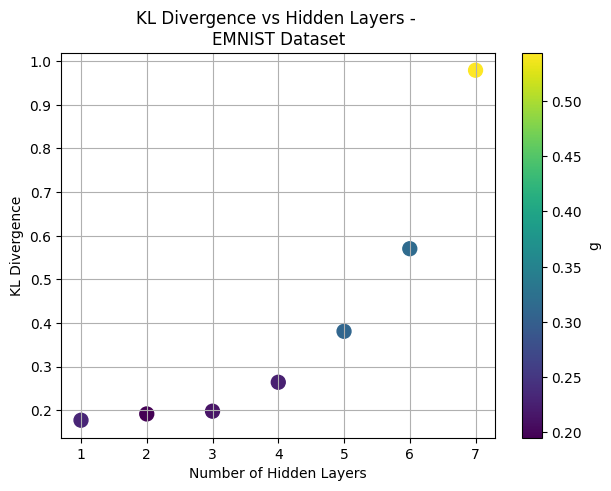

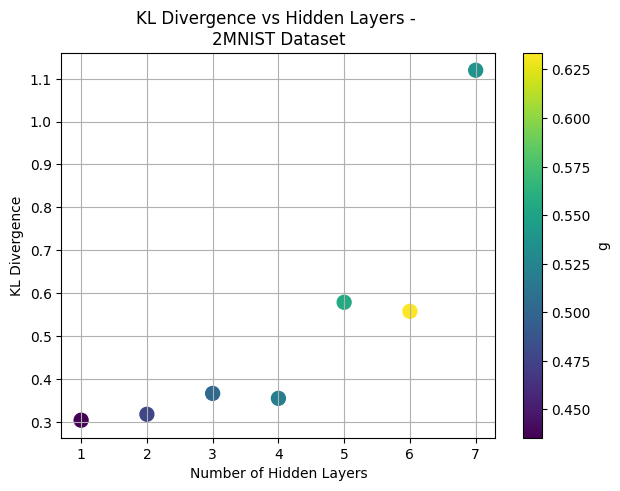

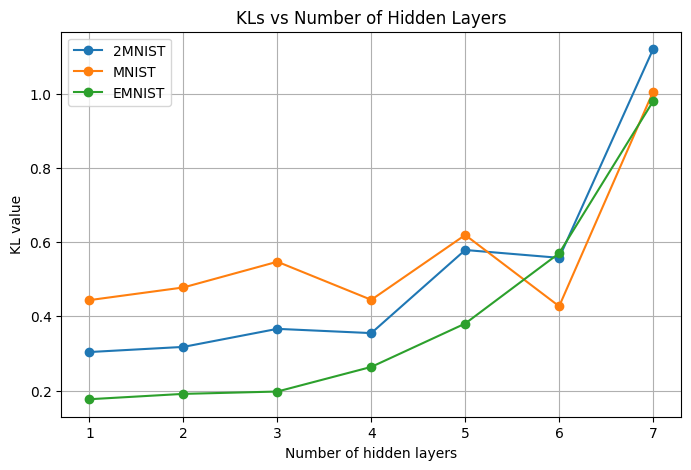

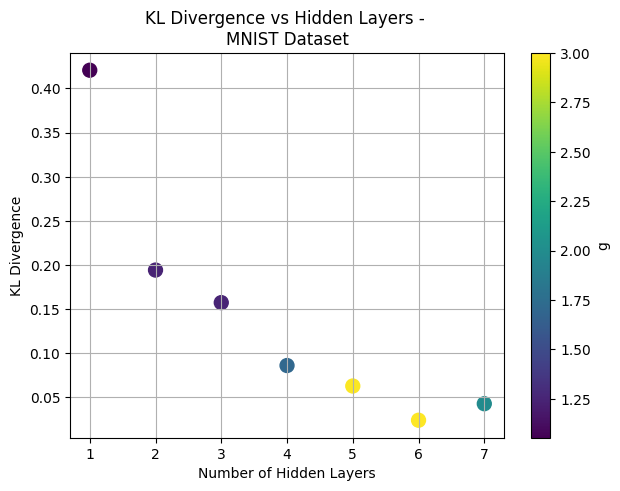

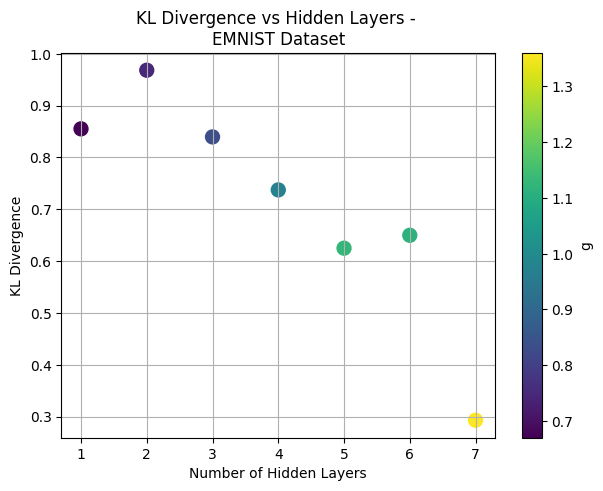

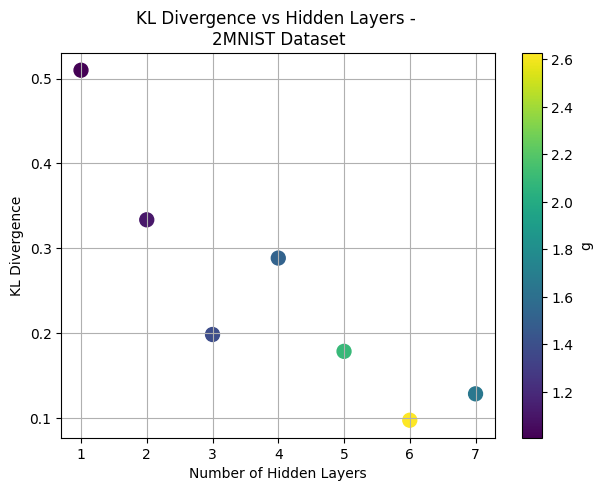

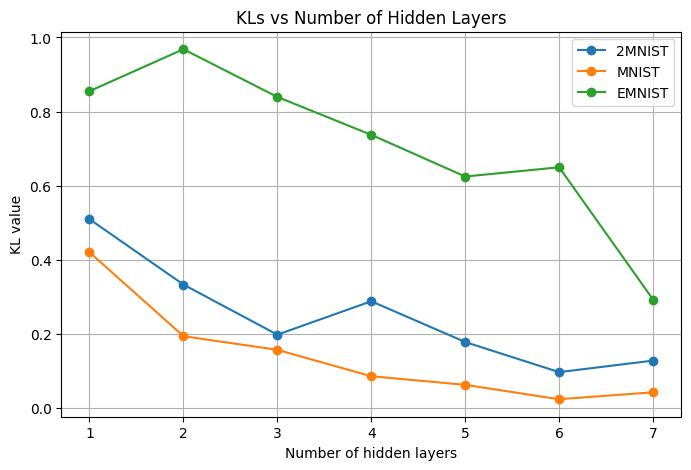

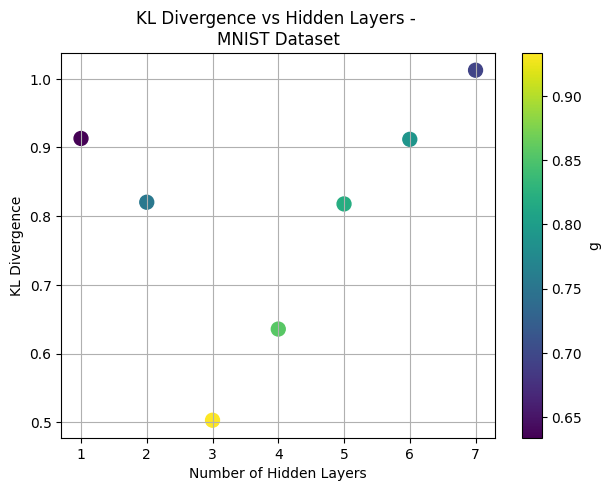

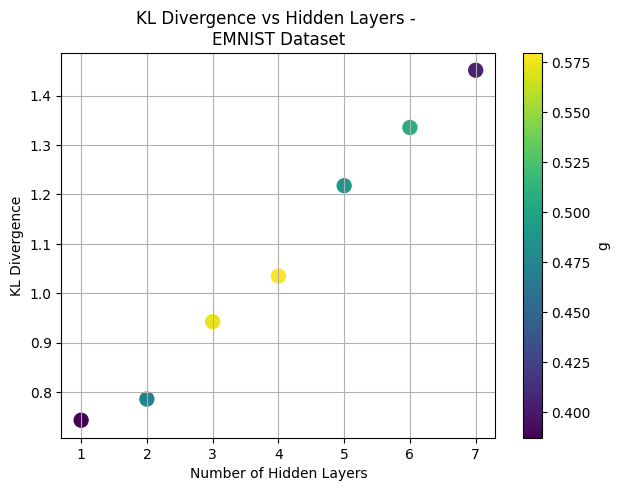

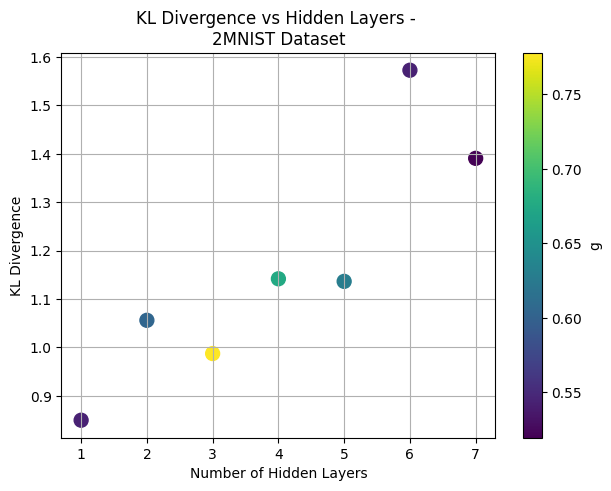

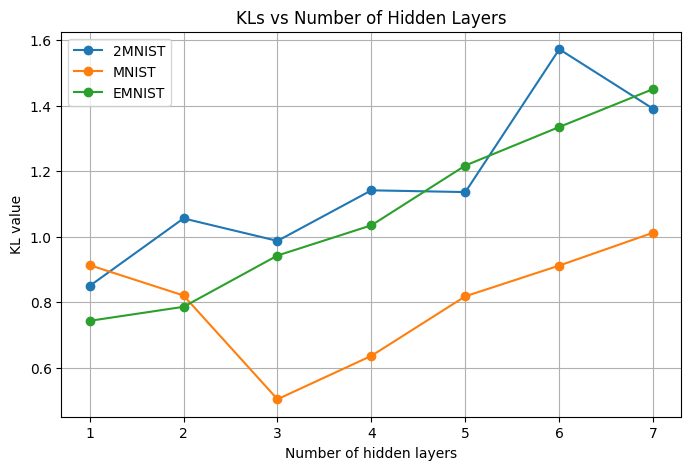

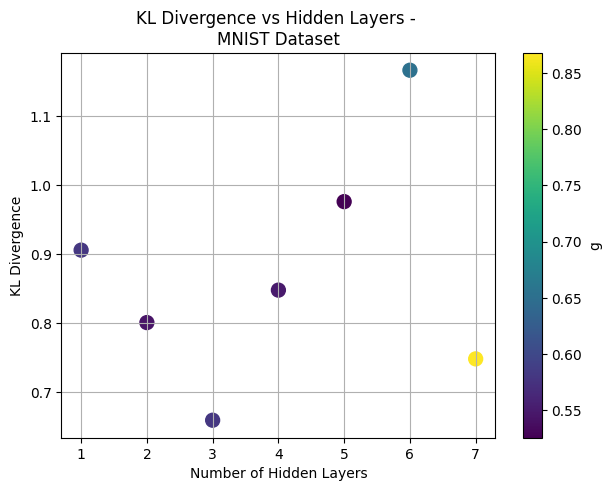

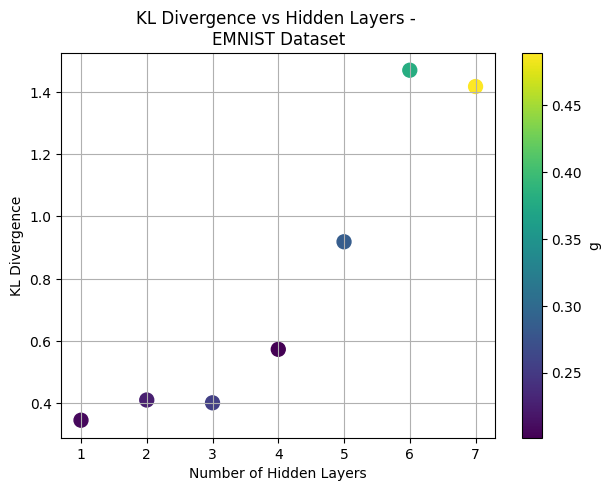

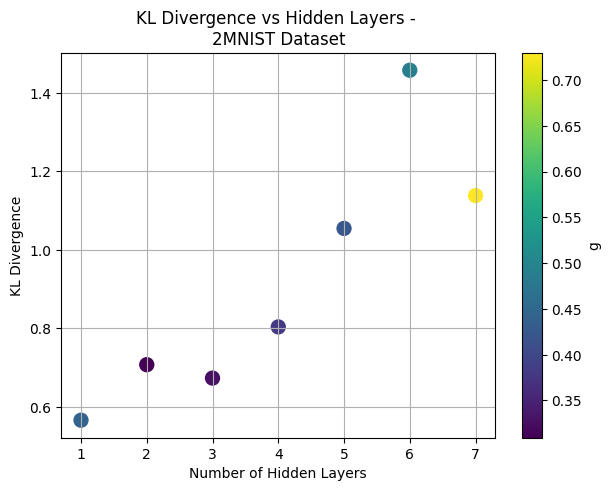

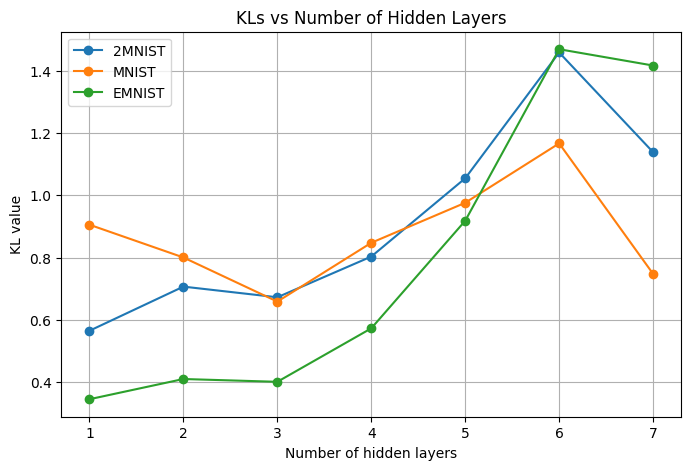

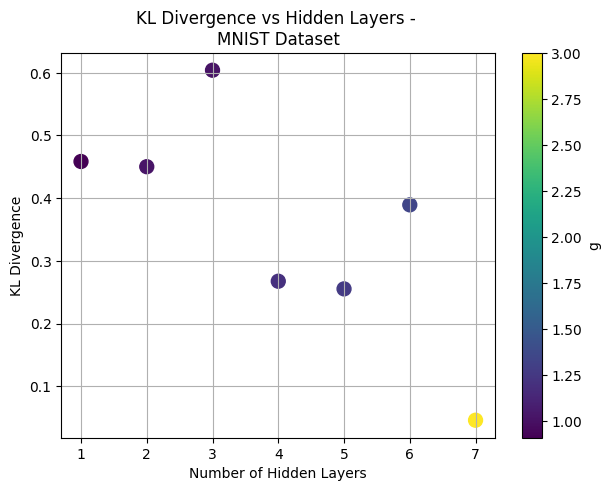

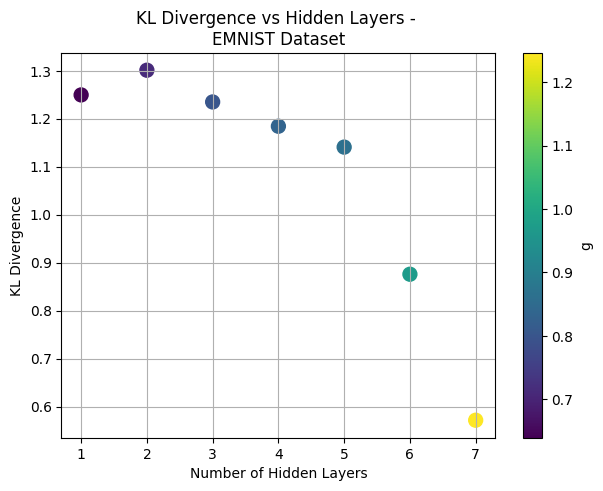

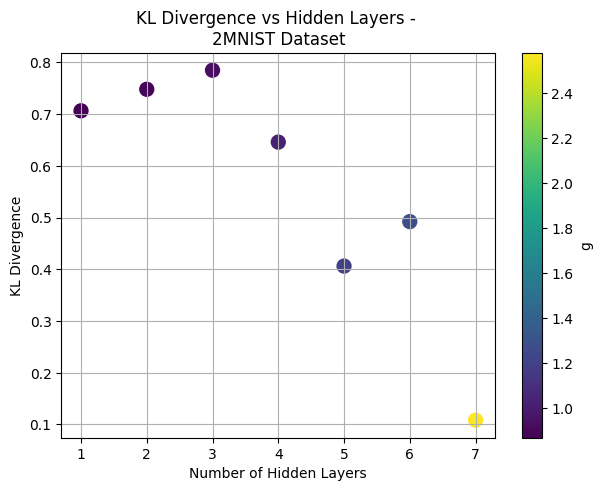

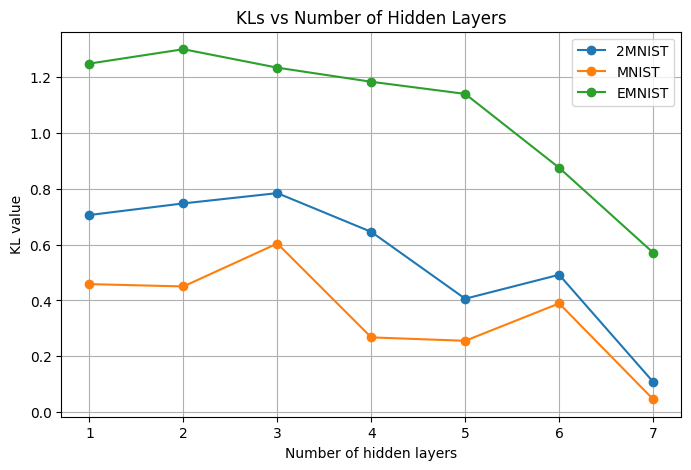

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):

        KLs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}

        gs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}  

        for dataset in datasets:
            for num_hidden_layers in range(1,8):    # 1-7 hl

                decrease_rate = 0.6
                decrease_rate_str = "06"
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28

                my_model = AE_0(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    hidden_layers=num_hidden_layers
                ).to(device)
                model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
                
                KLs_dict[dataset].append(KL)
                gs_dict[dataset].append(g)

            save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{binarize_threshold}"
            plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

        datasets_dicts_comparison(KLs_dict, save_dir)

## Visualize 3hl neurons

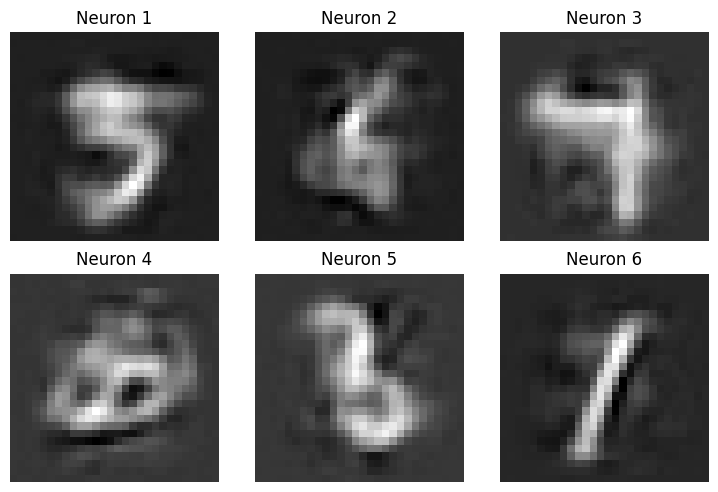

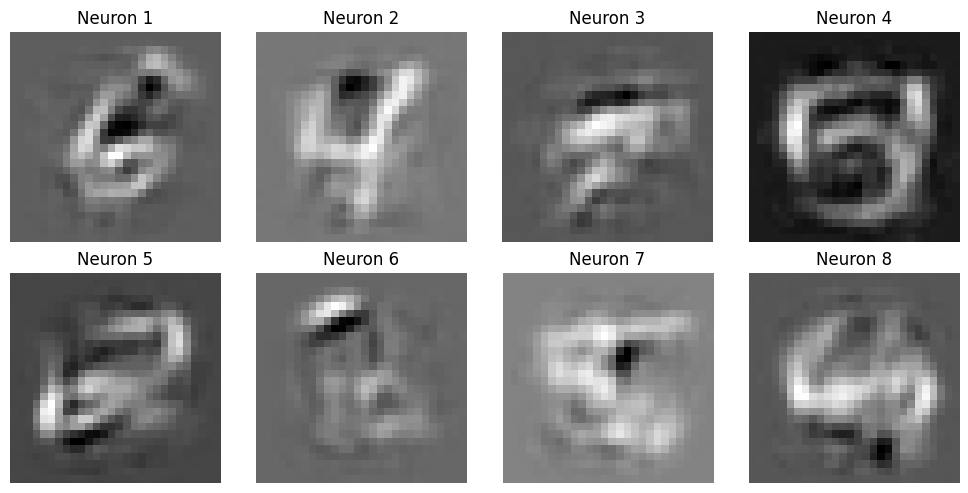

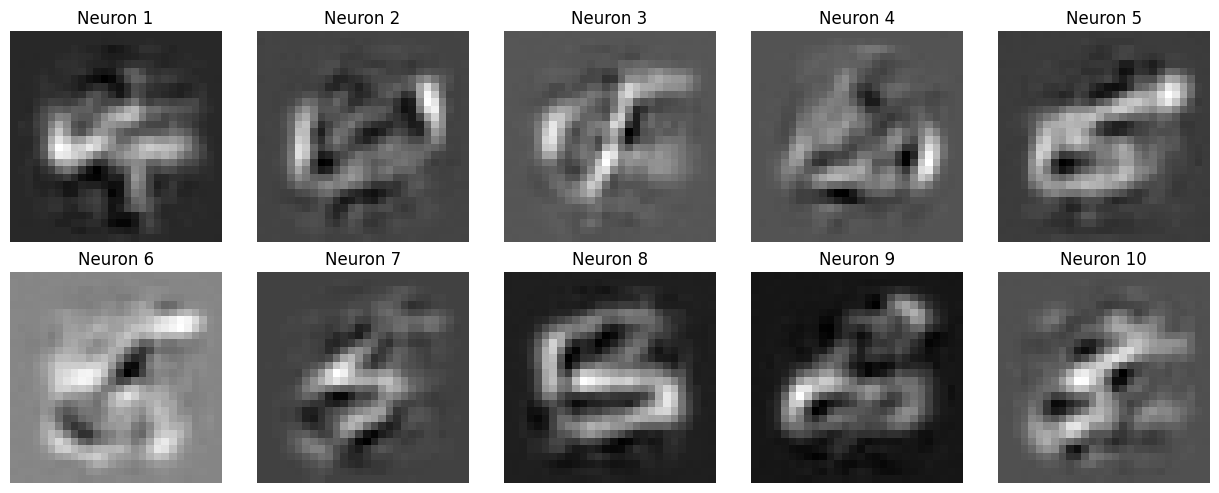

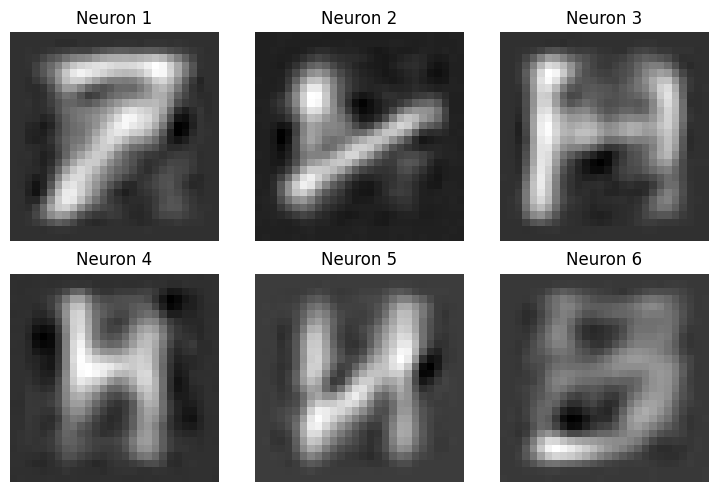

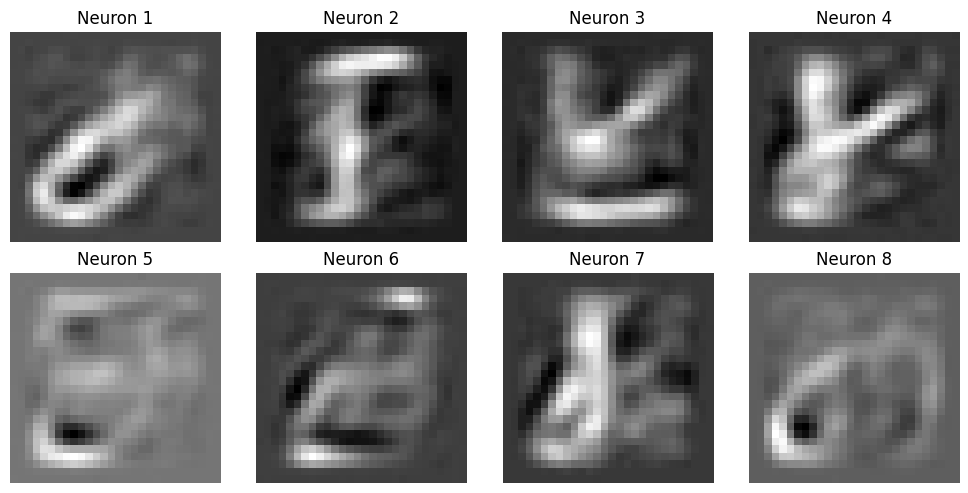

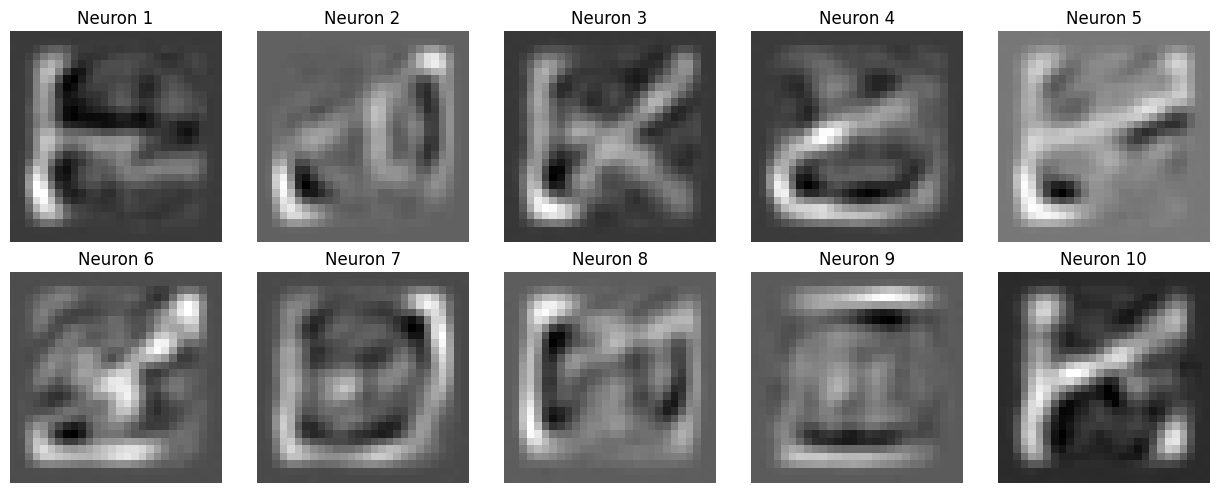

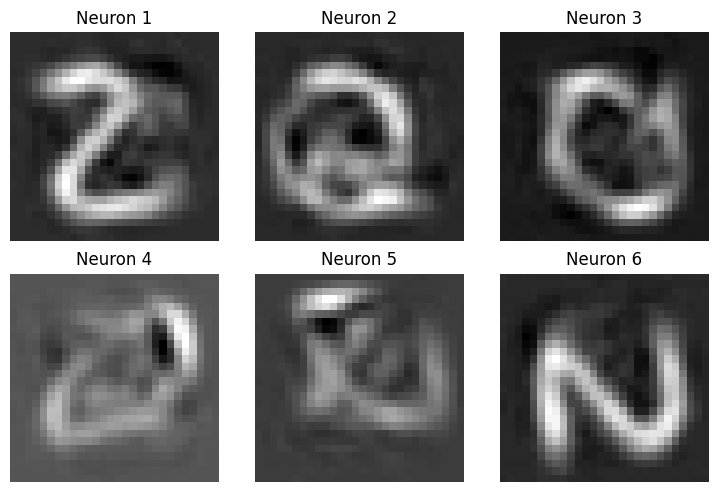

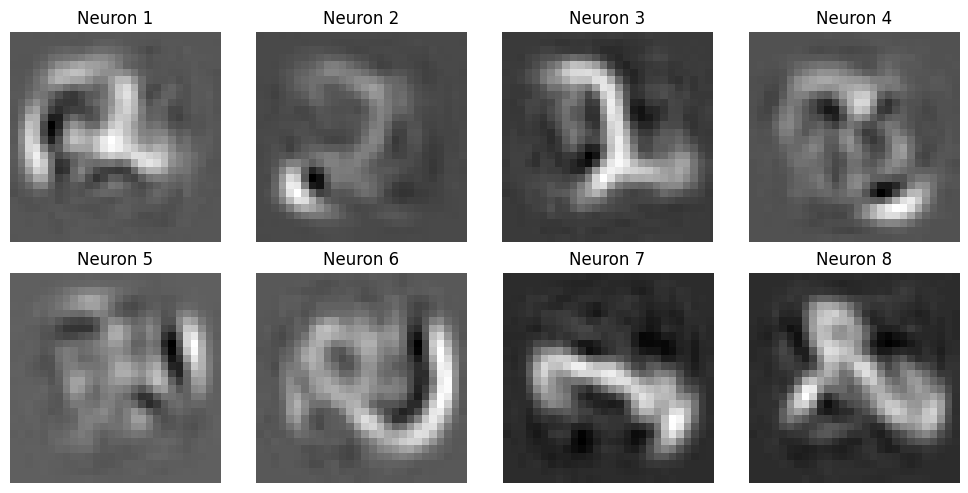

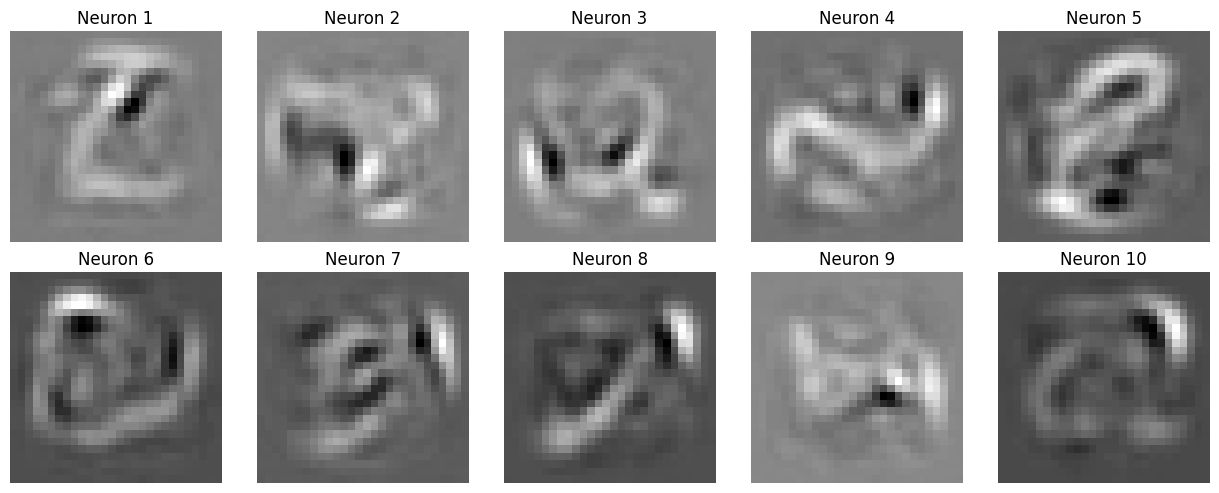

In [ ]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))




        save_dir = f"../Images/{latent_dim}features/simultaneous train/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

### 2_M_E_MNIST

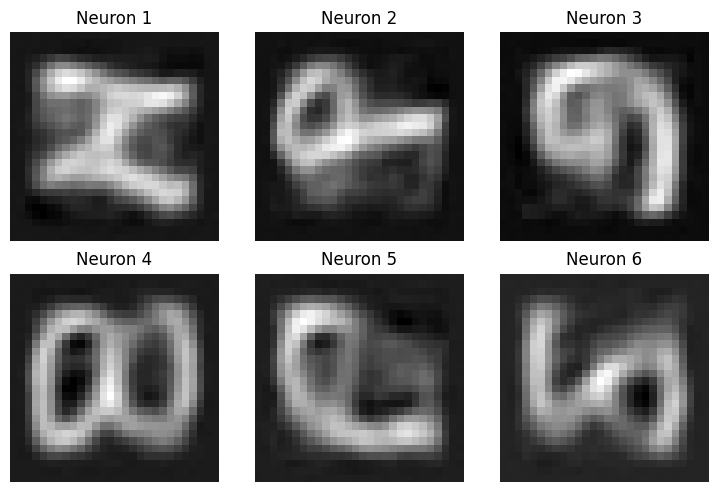

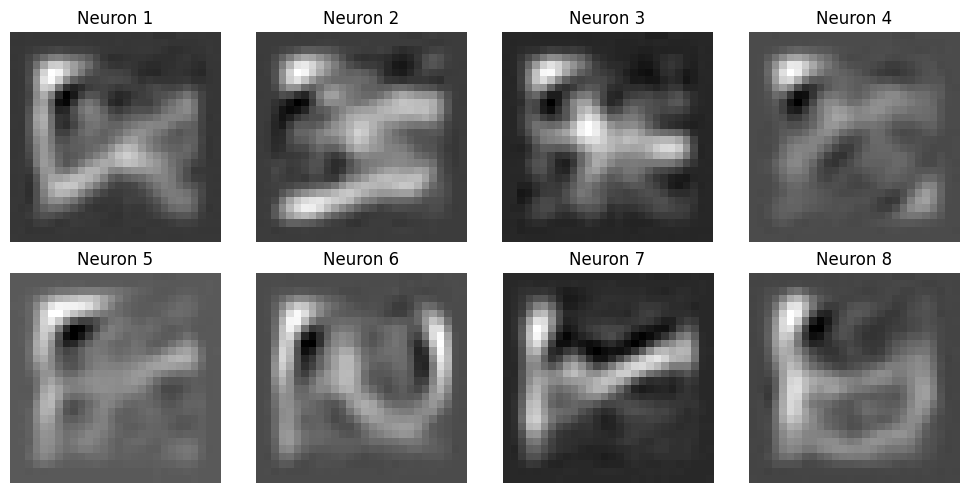

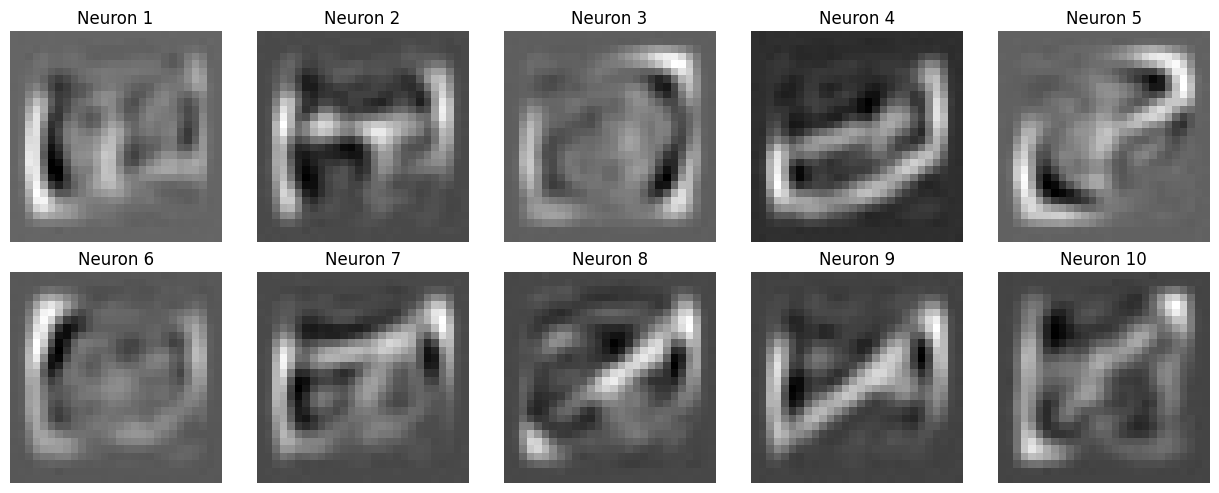

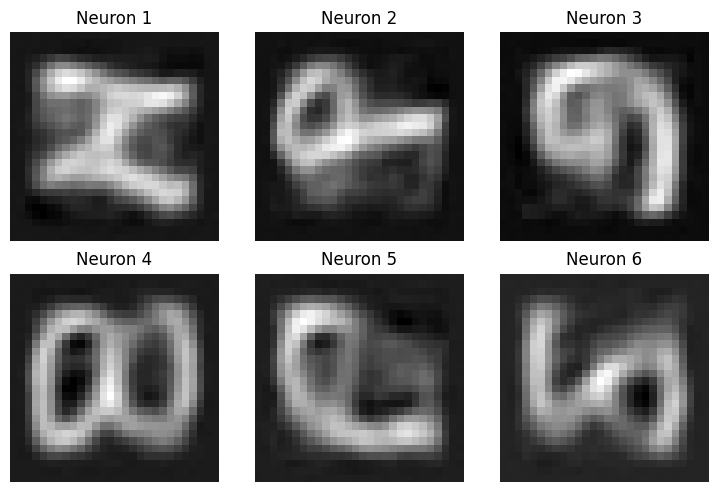

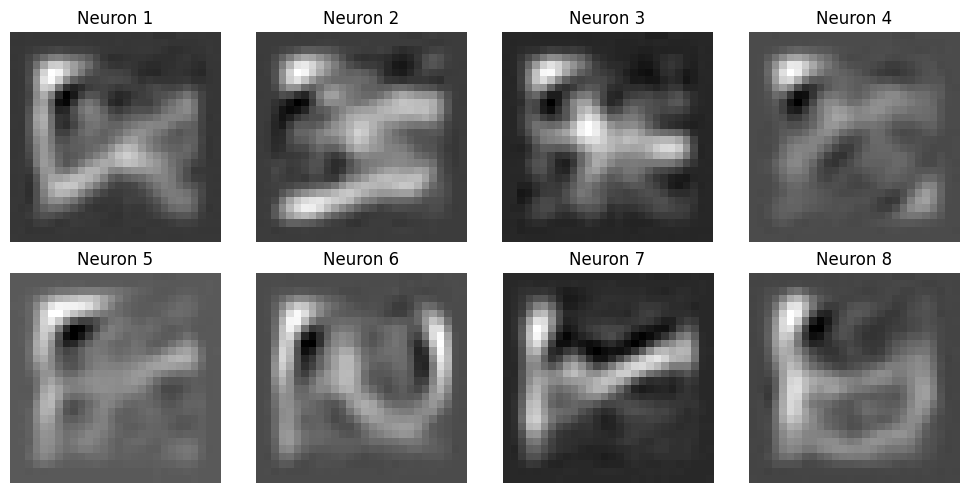

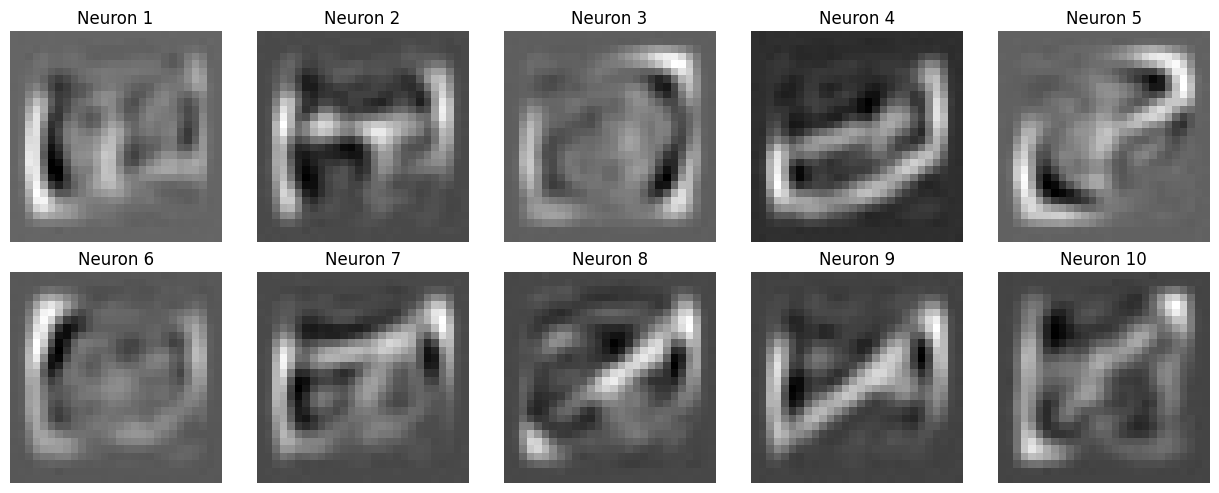

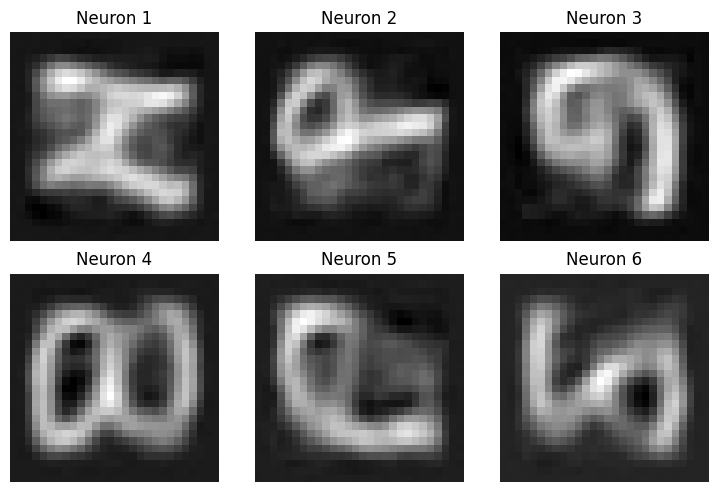

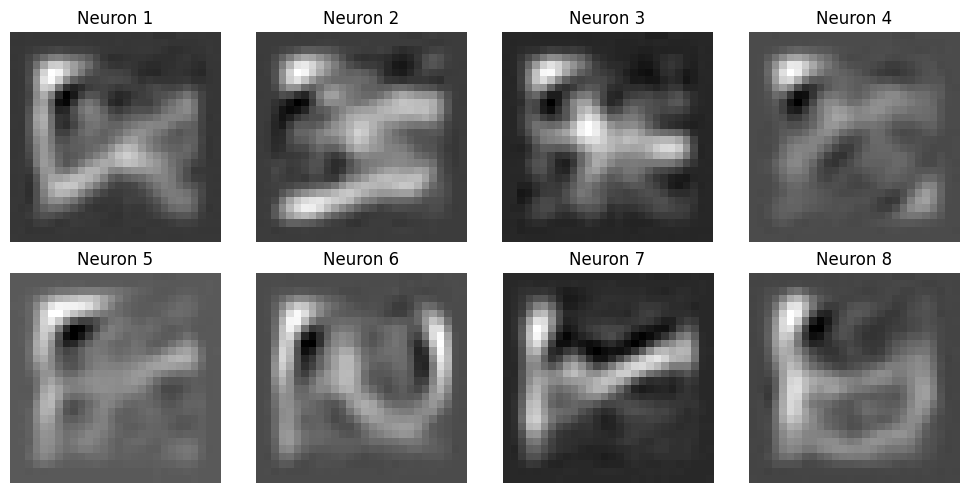

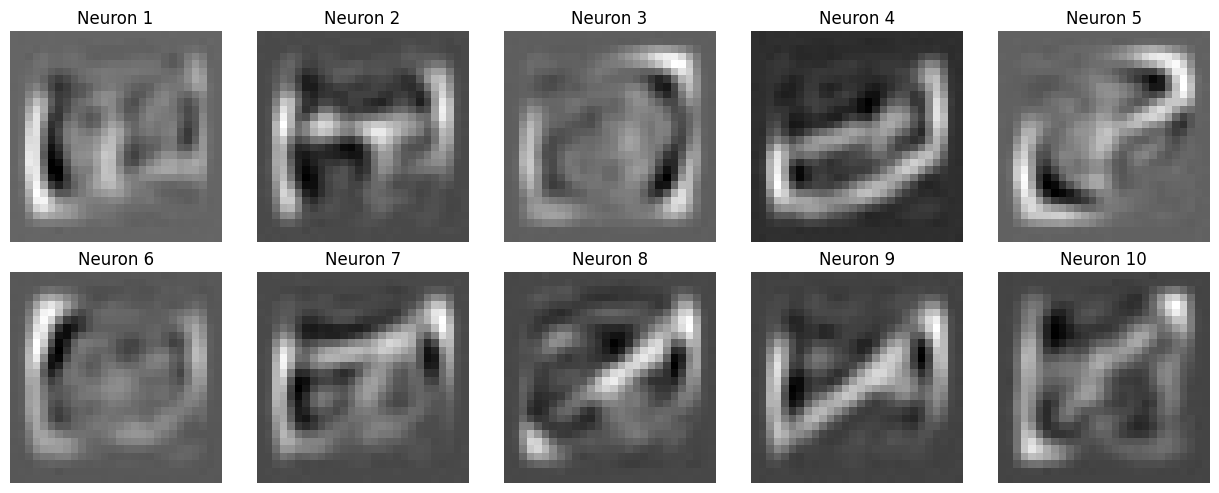

In [ ]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.6
        decrease_rate_str = "06"
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))




        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

## Bottleneck neurons activation frequencies

### Not gagued

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

### Gauged

In [ ]:
for latent_dim in (6, 8, 10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))
                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

### 2_M_E_MNIST

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

## Bottleneck weights 

In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
        with open(f'../Images/{latent_dim}features/simultaneous train/weights_mean_abs_value.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.abs().mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.abs().mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

In [ ]:
# Weights mean

with torch.no_grad():
    for latent_dim in (6,8,10):
        with open(f'../Images/{latent_dim}features/simultaneous train/weights_mean.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

### 2_M_E_MNIST

In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/weight_mean_abs_value.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.abs().mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.abs().mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

## Gauge permutations

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8): # from 1 to 7

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')

### 2_M_E_MNIST

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/simultaneous train/{latent_dim}features/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8): # from 1 to 7

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    decrease_rate_str = "06"
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')

# ----- Progressive train -----

## HFM KLD


### 6 features


In [ ]:

KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 6
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)


### 8 features


In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 8
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)


### 10 features


In [ ]:

KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  




for dataset in datasets:
    
    for num_hidden_layers in range(1,7):
        latent_dim = 10
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28
        threshold_for_binarization = 0.8

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, threshold_for_binarization=threshold_for_binarization)
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/{latent_dim}features/progressive train/thresh_for_bin_{threshold_for_binarization}"

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)


### 2_M_E_MNIST

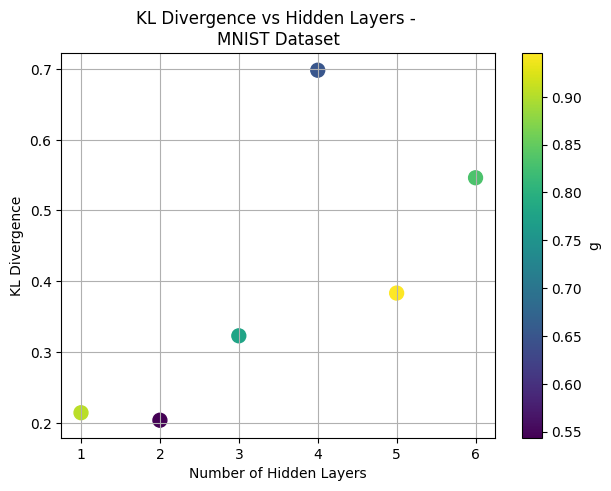

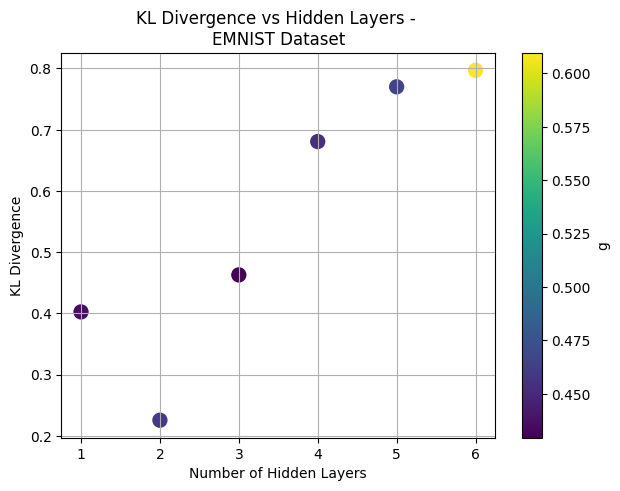

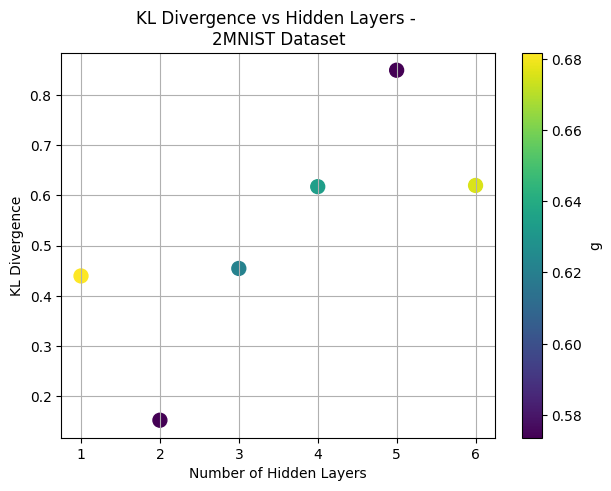

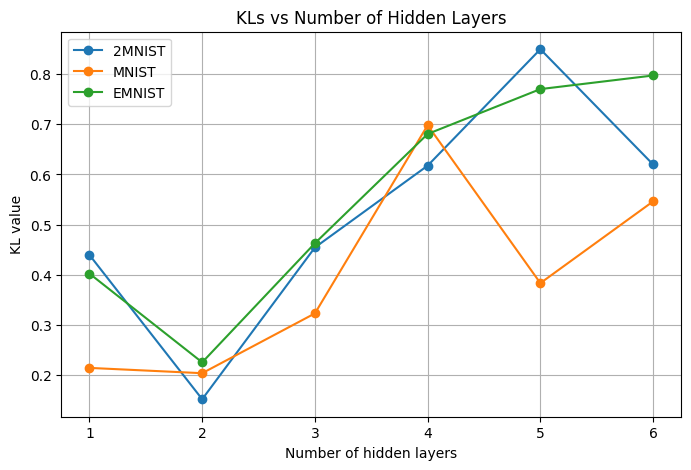

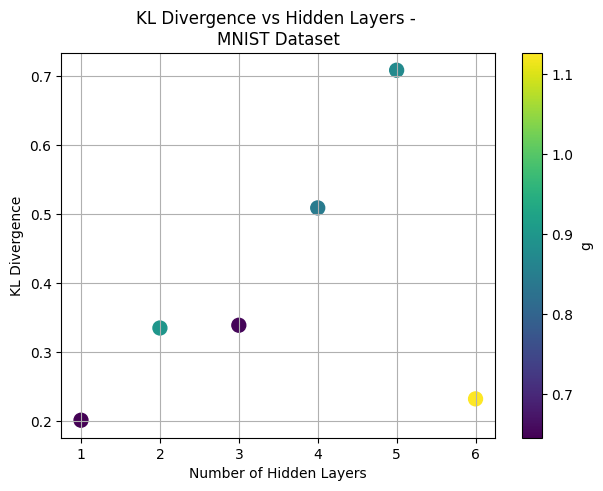

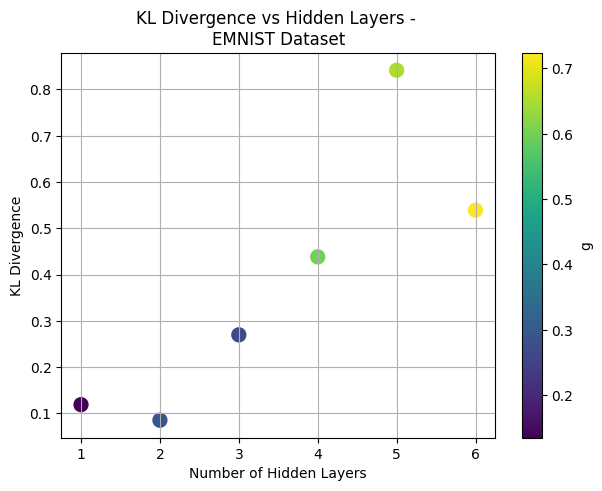

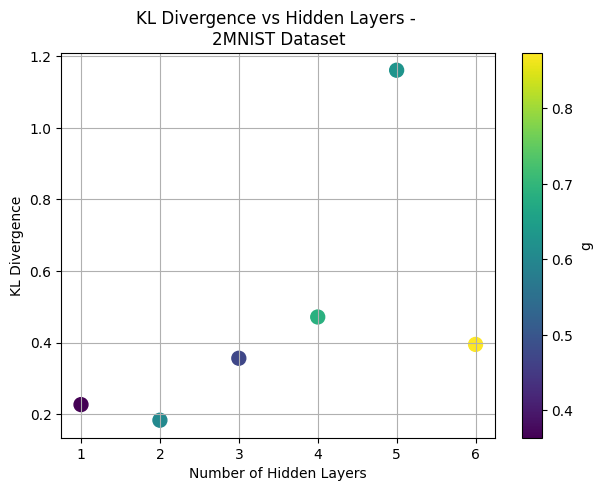

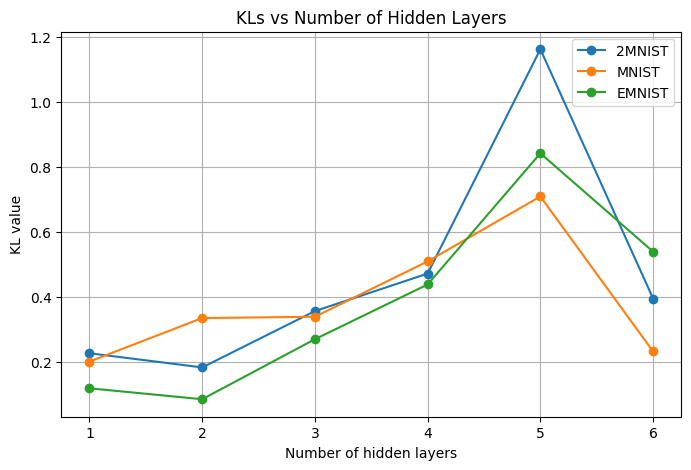

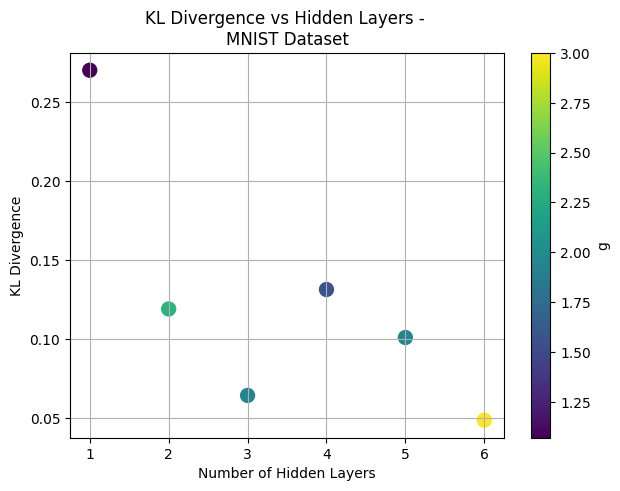

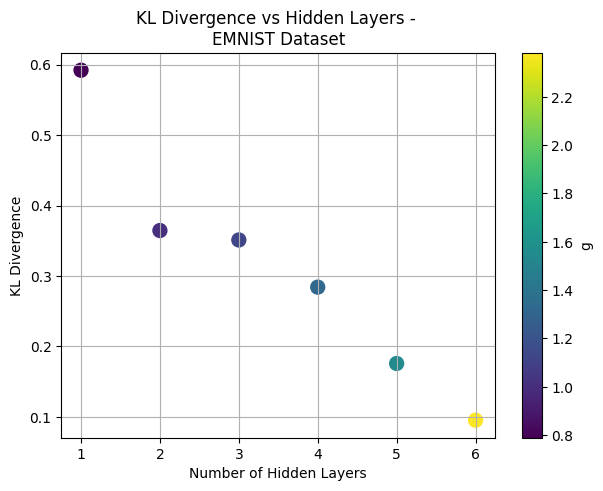

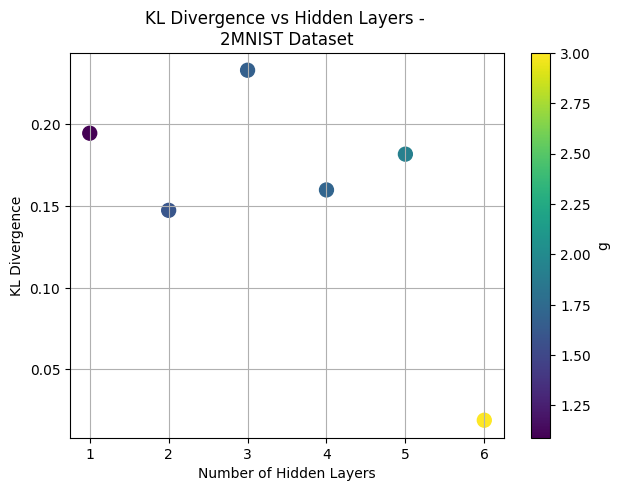

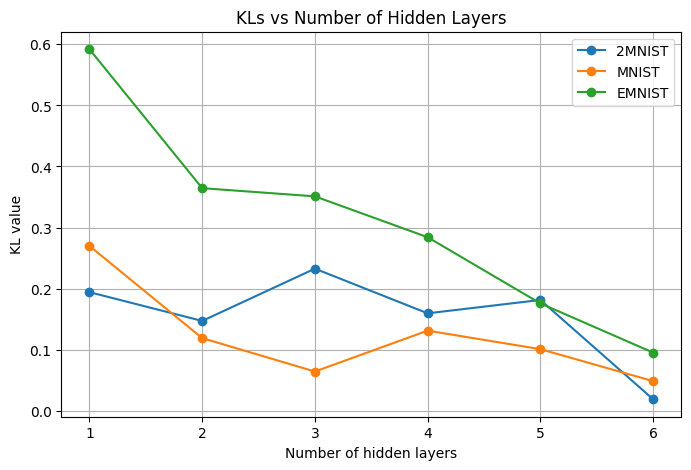

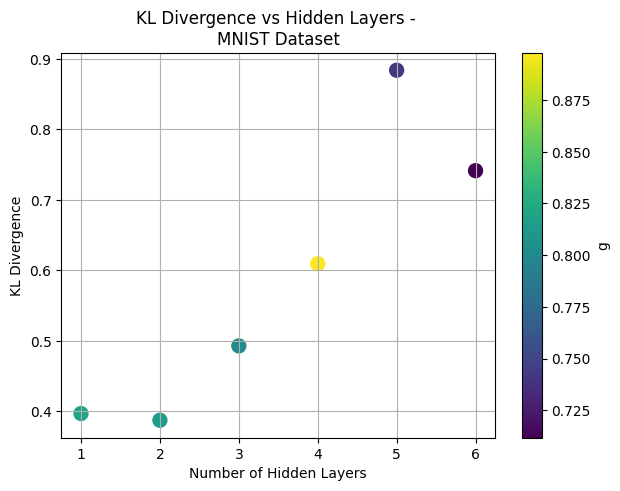

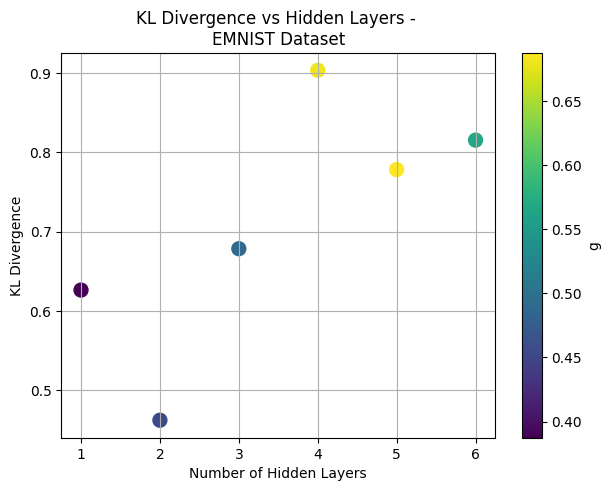

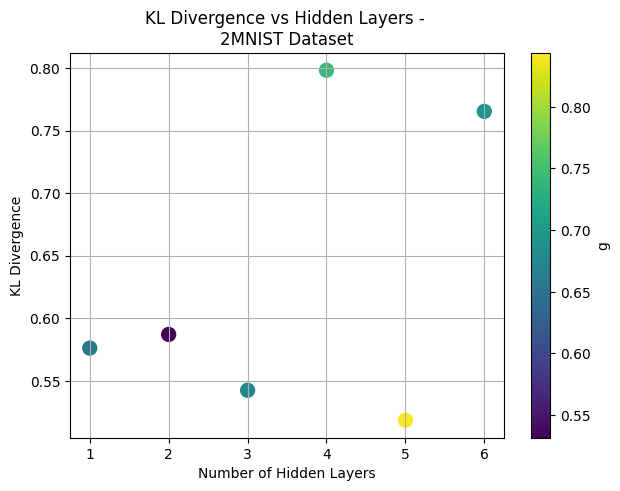

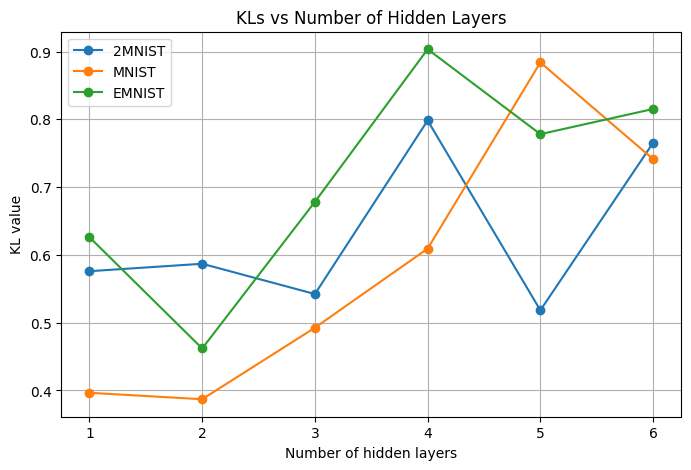

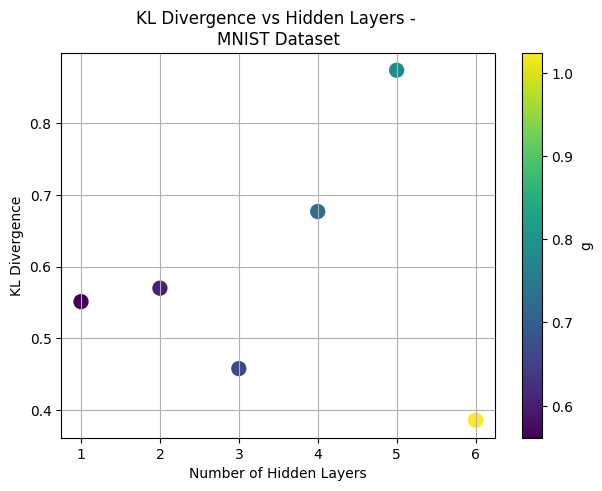

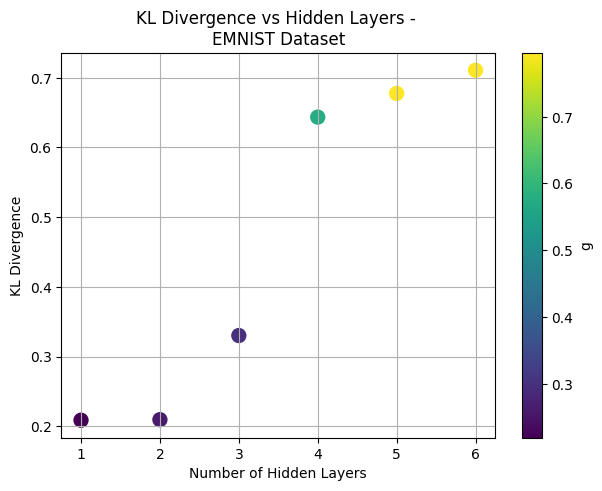

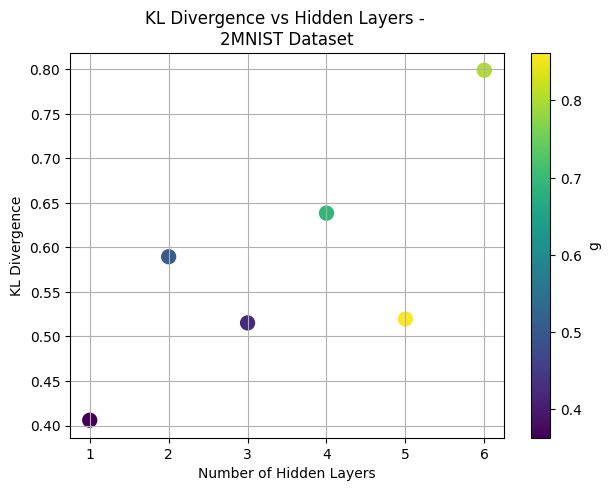

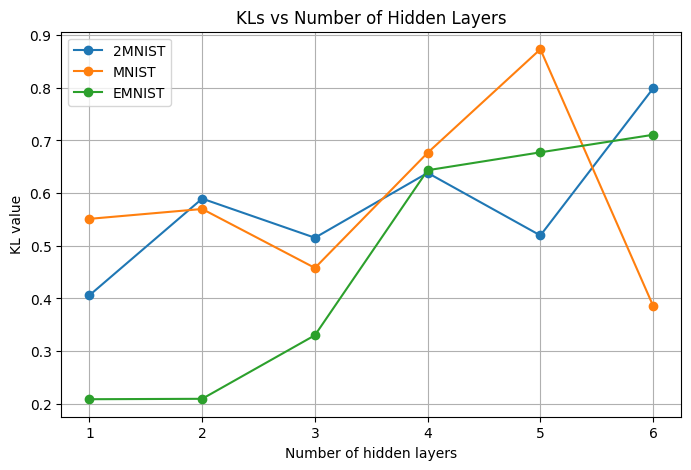

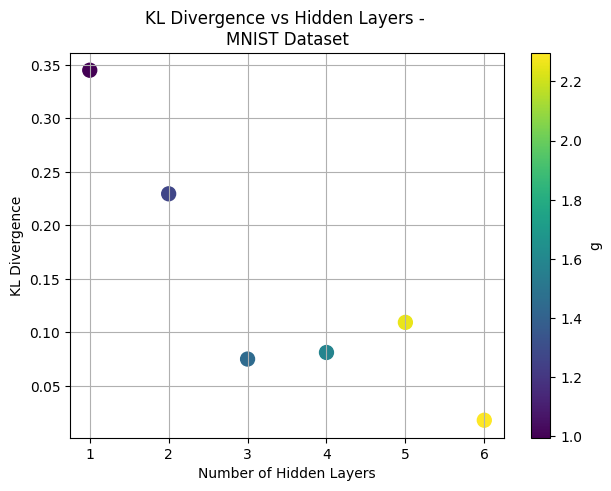

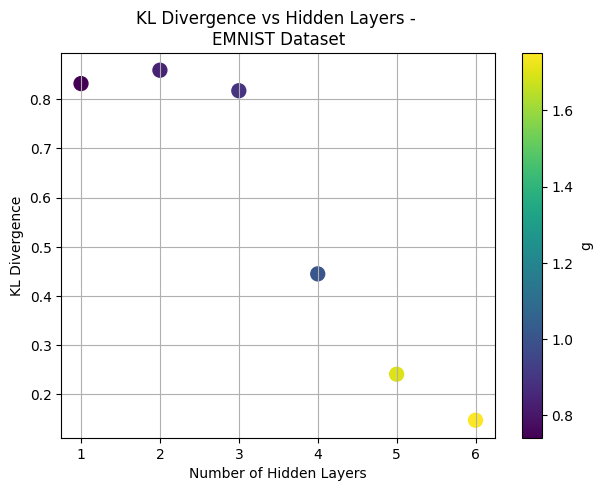

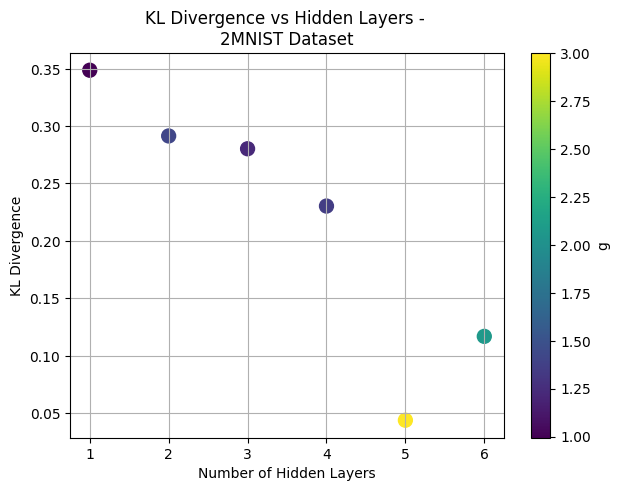

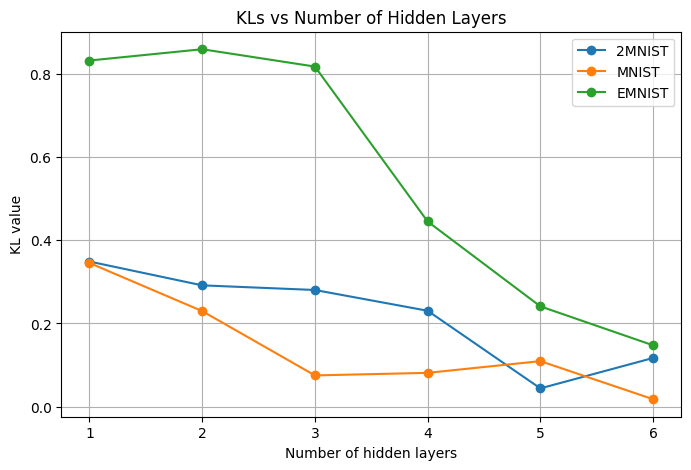

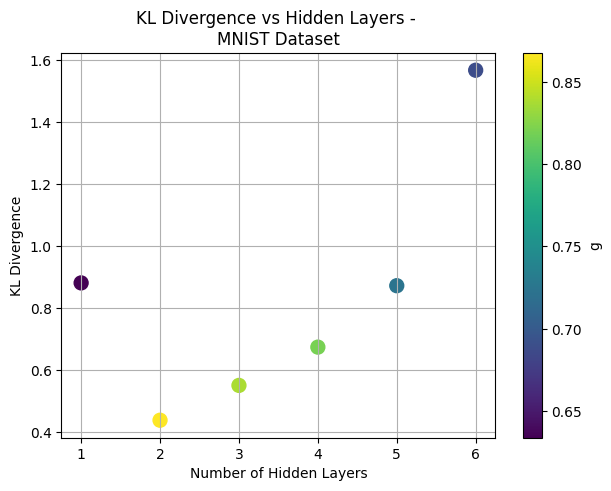

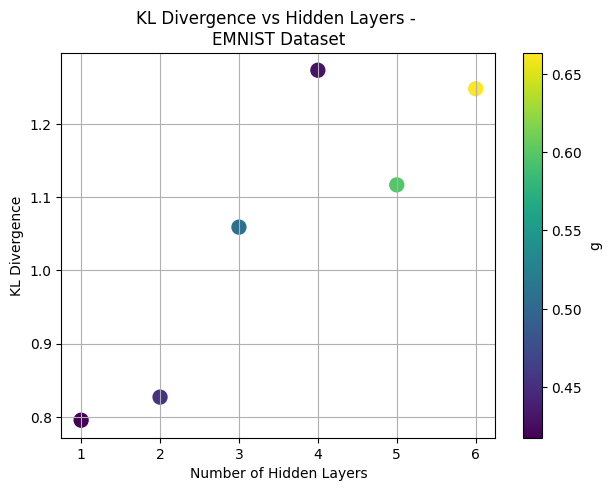

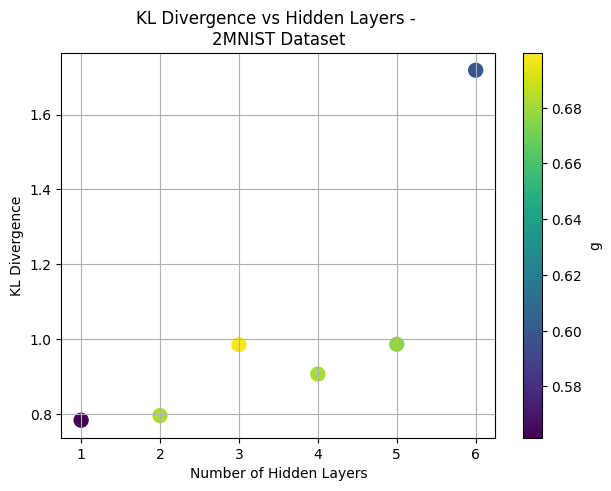

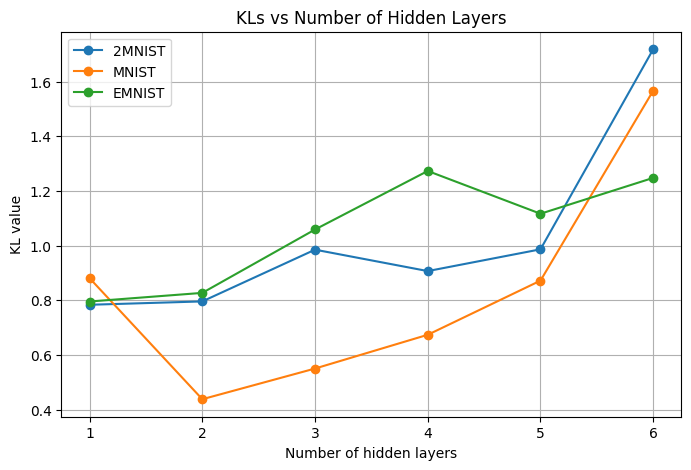

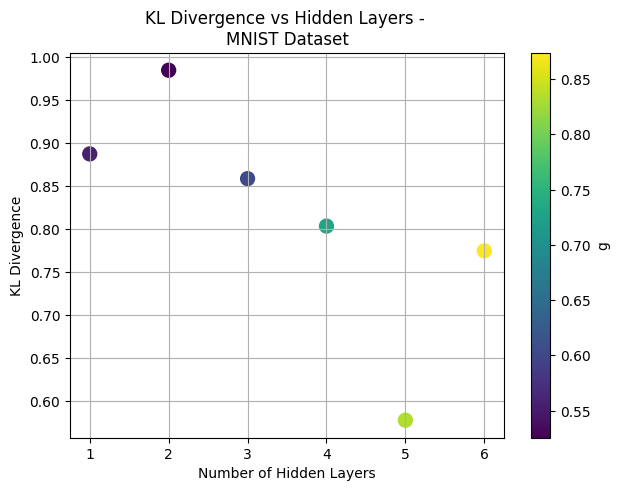

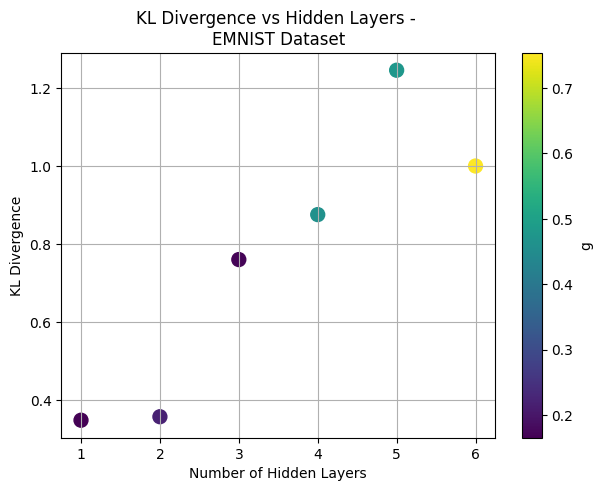

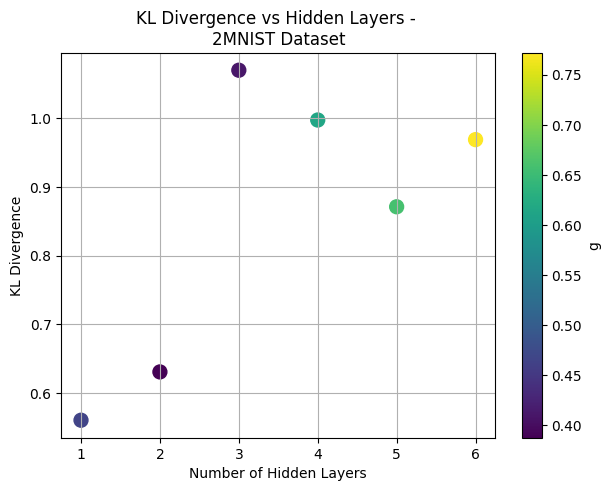

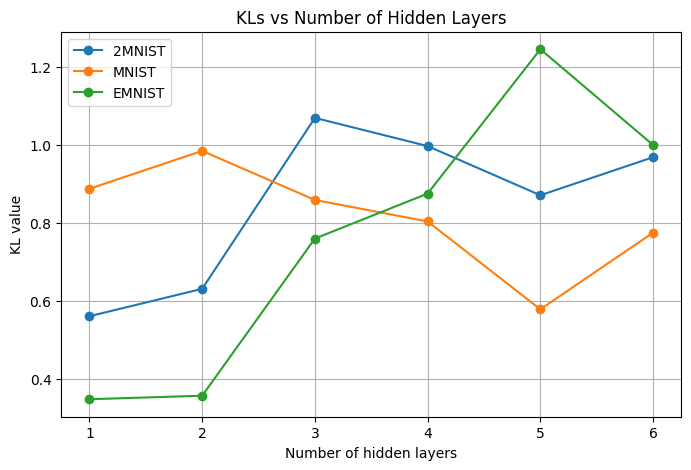

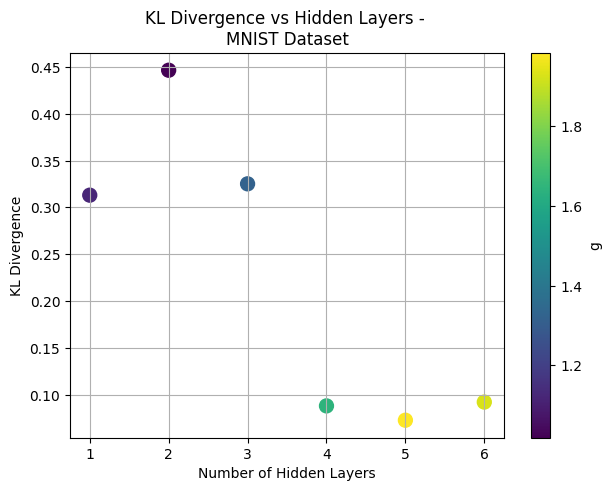

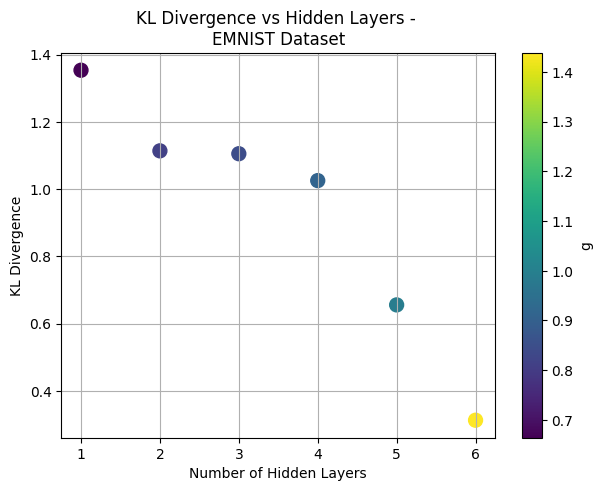

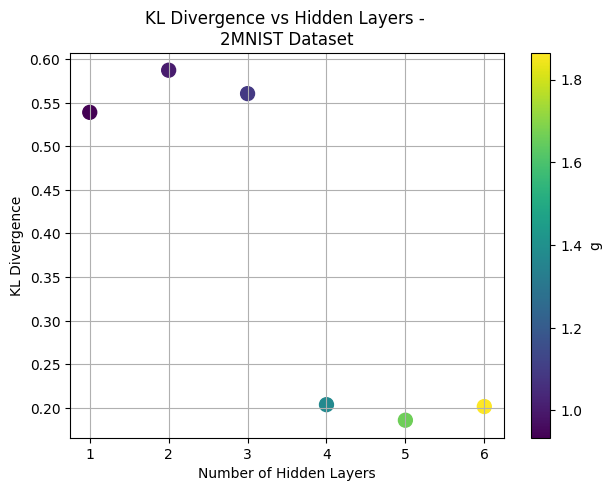

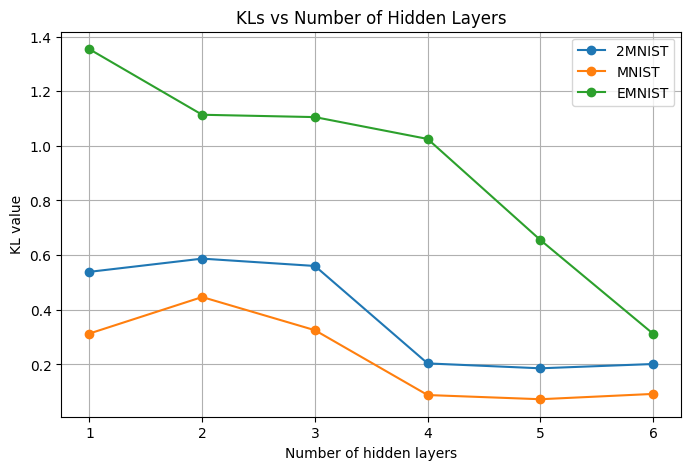

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):

        KLs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}

        gs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}  

        for dataset in datasets:
            for num_hidden_layers in range(1,7):    # 1-6 hl

                decrease_rate = 0.7
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28

                my_model = ProgressiveAE(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    num_hidden_layers=num_hidden_layers
                ).to(device)
                model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
                
                KLs_dict[dataset].append(KL)
                gs_dict[dataset].append(g)

            save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{binarize_threshold}"
            plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

        datasets_dicts_comparison(KLs_dict, save_dir)

## Visualize 3hl features


In [ ]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))
        save_dir = f"../Images/{latent_dim}features/progressive train/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)


### 2_M_E_MNIST

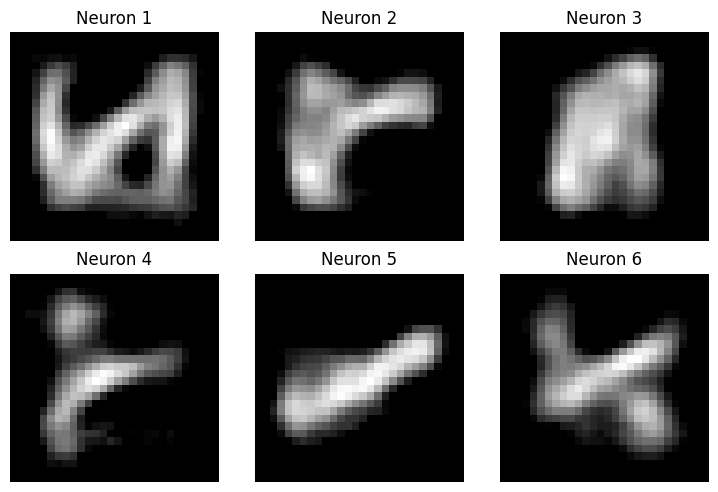

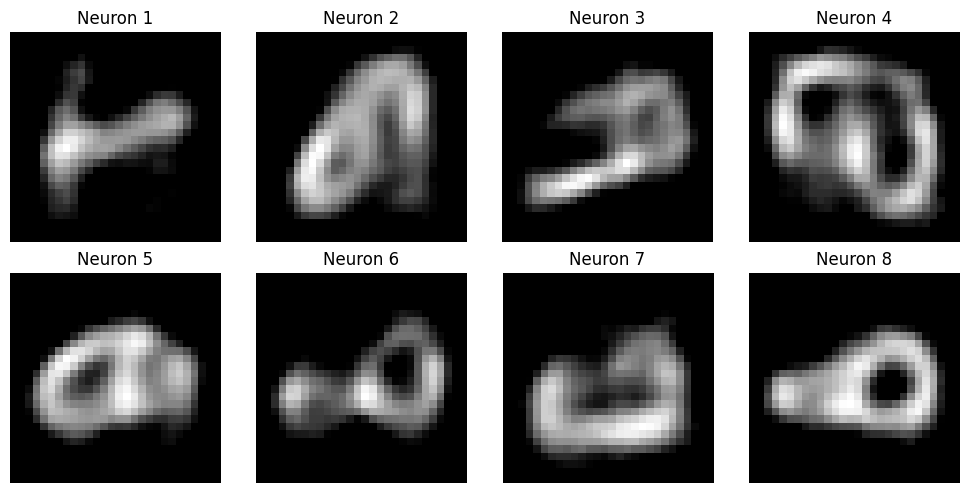

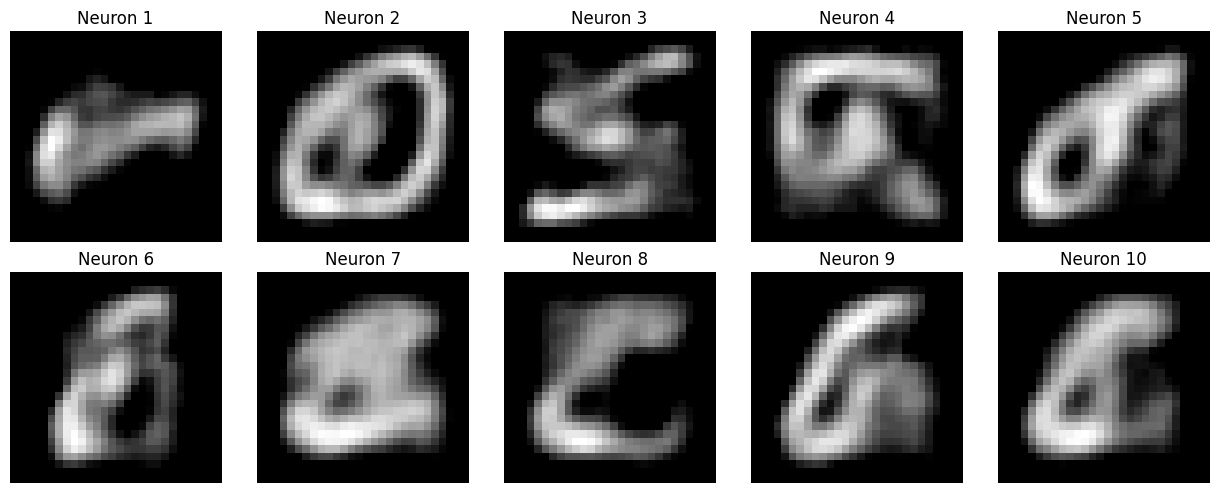

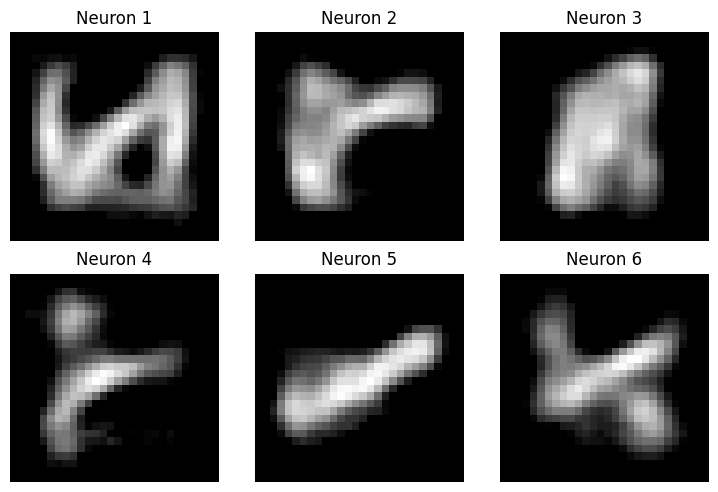

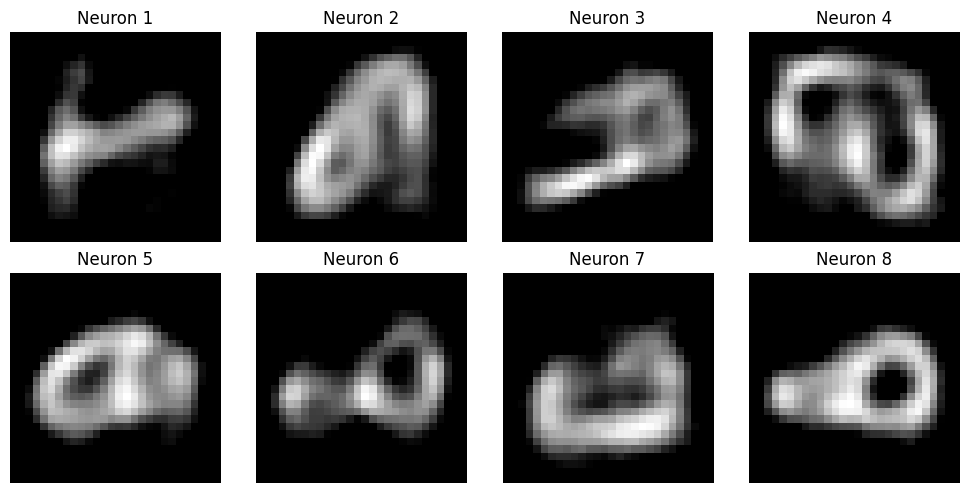

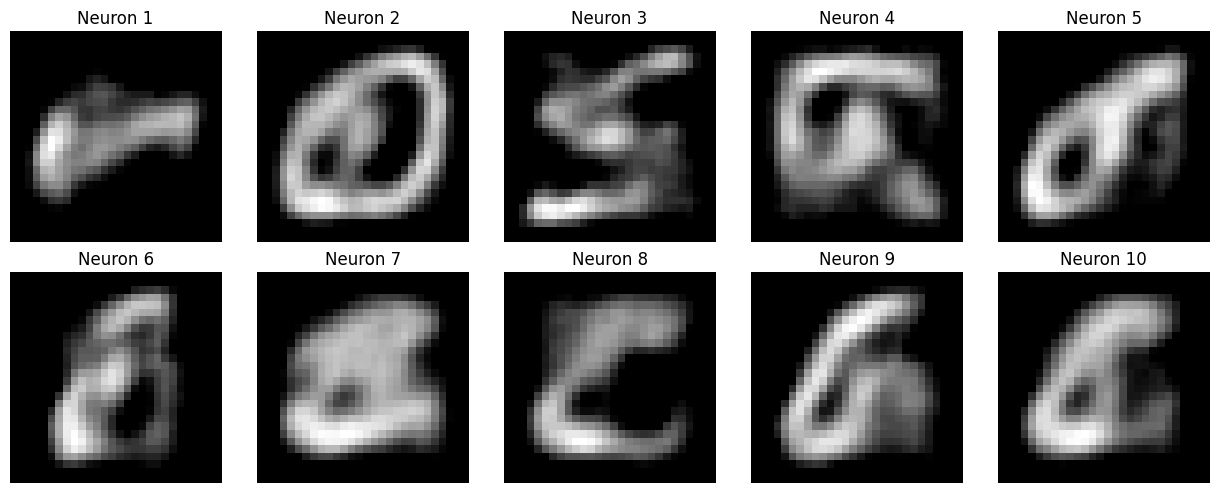

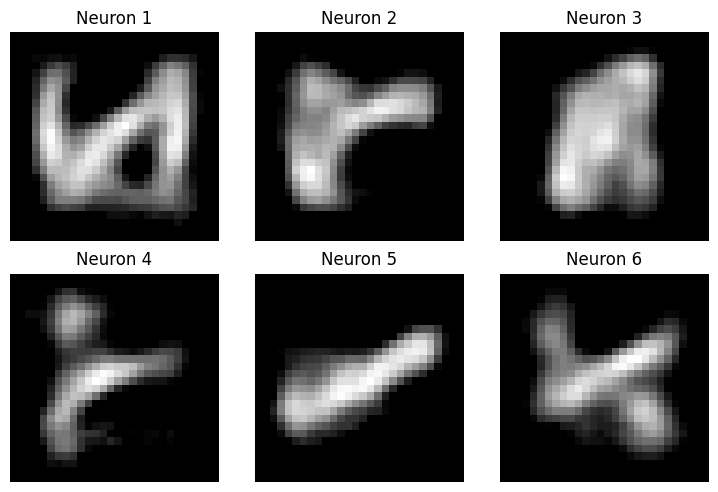

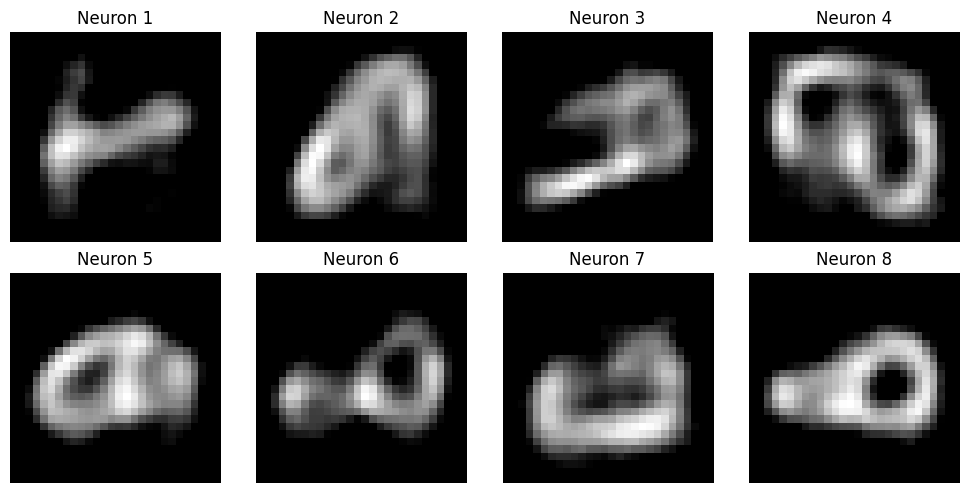

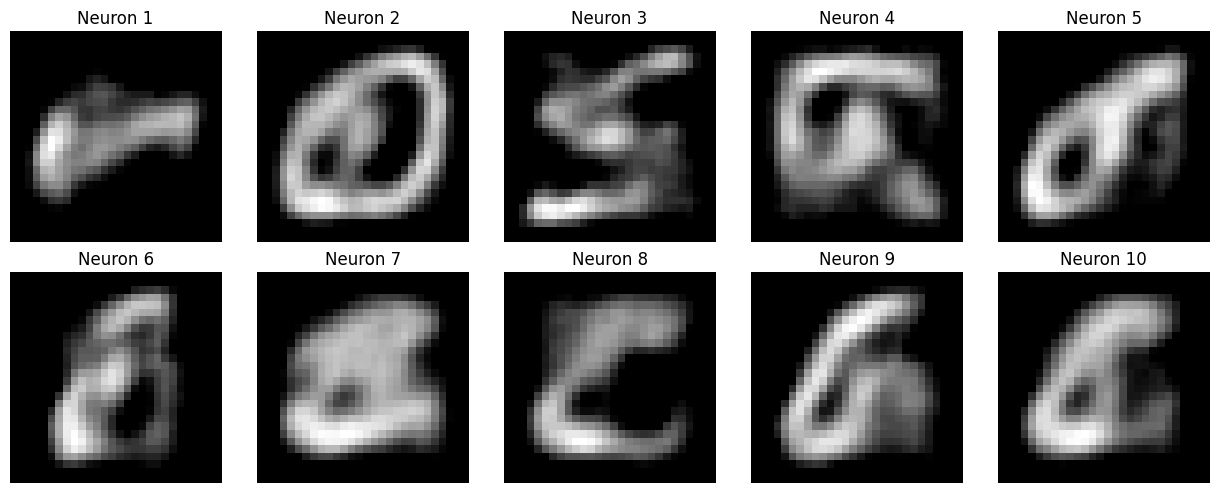

In [ ]:
for dataset in datasets:
    
    for latent_dim in (6,8,10):
        num_hidden_layers = 3
        decrease_rate = 0.7
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))


        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

## Bottleneck neurons activation frequencies


### Not gauged

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')




### Gauged

In [ ]:
for latent_dim in (6, 8, 10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')

### 2_M_E_MNIST

In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')


In [ ]:
for latent_dim in (6,8,10):
    for thresh_for_bin in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{thresh_for_bin}/bottleneck_neurons_activations_gauged.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7):

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    
                    neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, thresh_for_bin)

                    formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                    f.write(formatted_neuron_frequencies + '\n\n')


## Bottleneck weights


In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
            with open(f'../Images/{latent_dim}features/progressive train/weights_mean_abs_value.txt', 'a') as f:
                for dataset in datasets:
                    f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                    for num_hidden_layers in range(1,7): # from 1 to 6

                        f.write(f"{num_hidden_layers} hl: ")

                        decrease_rate = 0.7
                        train_loader = train_loaders[dataset]
                        val_loader = val_loaders[dataset]
                        input_dim = 28 * 28


                        my_model = ProgressiveAE(
                            input_dim=input_dim,
                            latent_dim=latent_dim,
                            decrease_rate=decrease_rate,
                            device=device,
                            num_hidden_layers=num_hidden_layers
                        ).to(device)
                        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                        my_model.load_state_dict(torch.load(model_path, map_location=device))

                        weights_in = my_model.bottleneck_in[0].weight.data.abs().mean(dim=1).tolist()
                        formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                        f.write("In " + formatted_weights_in + '\n\n')

                        weights_out = my_model.bottleneck_out[0].weight.data.abs().mean(dim=0).tolist()
                        formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                        f.write("      Out " + formatted_weights_out + '\n\n')


In [ ]:
# Weights mean

with torch.no_grad():
    for latent_dim in (6,8,10):
            with open(f'../Images/{latent_dim}features/progressive train/weights_mean.txt', 'a') as f:
                for dataset in datasets:
                    f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                    for num_hidden_layers in range(1,7): # from 1 to 6

                        f.write(f"{num_hidden_layers} hl: ")

                        decrease_rate = 0.7
                        train_loader = train_loaders[dataset]
                        val_loader = val_loaders[dataset]
                        input_dim = 28 * 28


                        my_model = ProgressiveAE(
                            input_dim=input_dim,
                            latent_dim=latent_dim,
                            decrease_rate=decrease_rate,
                            device=device,
                            num_hidden_layers=num_hidden_layers
                        ).to(device)
                        model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                        my_model.load_state_dict(torch.load(model_path, map_location=device))

                        weights_in = my_model.bottleneck_in[0].weight.data.mean(dim=1).tolist()
                        formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                        f.write("In " + formatted_weights_in + '\n\n')

                        weights_out = my_model.bottleneck_out[0].weight.data.mean(dim=0).tolist()
                        formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                        f.write("      Out " + formatted_weights_out + '\n\n')



In [ ]:
# Weights mean absolute value gauged

with torch.no_grad():
    for latent_dim in (8,):
            for binarize_threshold in (0.5,):
                with open(f'../Images/{latent_dim}features/progressive train/weights_mean_abs_value.txt', 'a') as f:
                    for dataset in datasets:
                        f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                        for num_hidden_layers in range(1,7): # from 1 to 6

                            f.write(f"{num_hidden_layers} hl: ")

                            decrease_rate = 0.7
                            train_loader = train_loaders[dataset]
                            val_loader = val_loaders[dataset]
                            input_dim = 28 * 28


                            my_model = ProgressiveAE(
                                input_dim=input_dim,
                                latent_dim=latent_dim,
                                decrease_rate=decrease_rate,
                                device=device,
                                num_hidden_layers=num_hidden_layers
                            ).to(device)
                            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                            my_model.load_state_dict(torch.load(model_path, map_location=device))

                            emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)

                            weights_in = my_model.bottleneck_in[0].weight.data.abs().mean(dim=1).tolist()
                            weights_in_permuted = tuple(weights_in[i] for i in perm)
                            formatted_weights_in_permuted = '(' + ', '.join(f"{v:.8f}" for v in weights_in_permuted) + ')'
                            f.write("In " + formatted_weights_in_permuted + '\n\n')

                            weights_out = my_model.bottleneck_out[0].weight.data.abs().mean(dim=0).tolist()
                            weights_out_permuted = tuple(weights_out[i] for i in perm)
                            formatted_weights_out_permuted = '(' + ', '.join(f"{v:.8f}" for v in weights_out_permuted) + ')'
                            f.write("      Out " + formatted_weights_out_permuted + '\n\n')

### 2_M_E_MNIST

In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (6,8,10):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/weight_mean_abs_value.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.bottleneck_in[0].weight.data.mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.bottleneck_out[0].weight.data.mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

## Gauge permutations

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        with open(f'../Images/{latent_dim}features/progressive train/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressiveAE/{dataset}/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')

### 2_M_E_MNIST

In [ ]:
for latent_dim in (6,8,10):
    for binarize_threshold in (0.3, 0.5, 0.8):
        save_dir = f"../Images/2_M_E_MNIST/progressive train/{latent_dim}features/thresh_for_bin_{binarize_threshold}/gauge_permutations.txt"
        with open(save_dir, 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,8): # from 1 to 7

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.7
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28


                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers
                    ).to(device)
                    model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold, return_perm=True)
                
                    f.write(str(perm) + '\n\n')

# Encoder output: ReLU

# ----- Simultaneous train -----

In [86]:
binarize_thresholds = {"2MNIST": 3.5, "MNIST": 1.5, "EMNIST": 3.3} 

with open(f"../Images/relu output/simultaneous train/8features/binarize_thresholds.txt", 'a') as f:
    for dataset, binarize_threshold in binarize_thresholds.items():
        f.write(dataset + f": {binarize_threshold}\n")

## HFM KLD

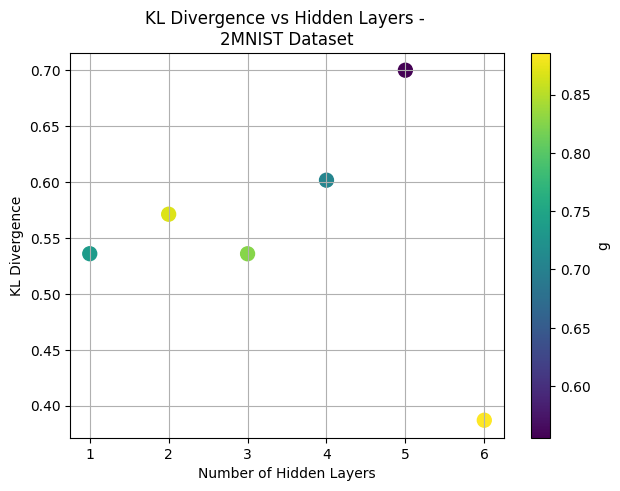

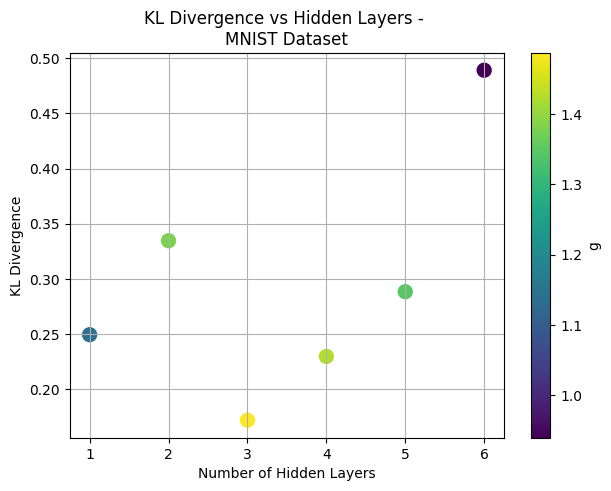

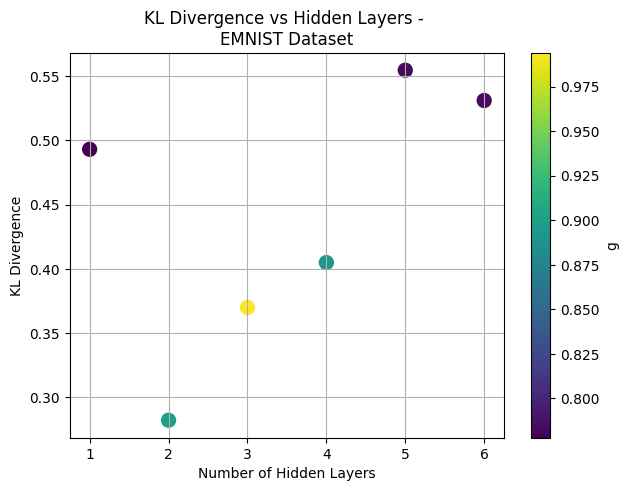

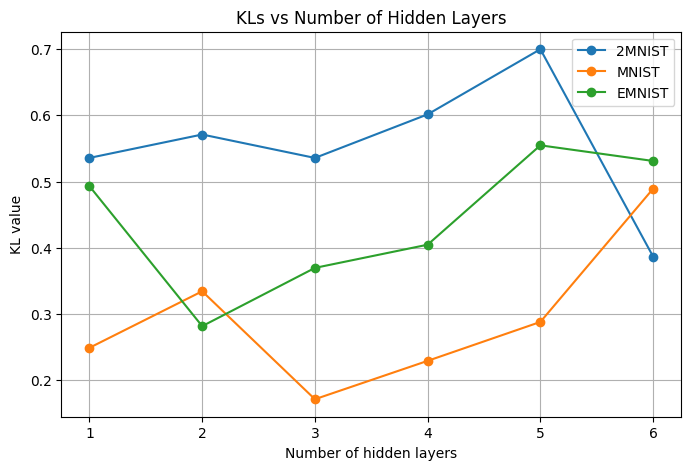

: 

In [ ]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

binarize_threshold = {"2MNIST": 3.5, "MNIST": 1.5, "EMNIST": 3.3} 


for dataset in ("2MNIST", "MNIST", "EMNIST",):
    
    for num_hidden_layers in range(1,7):
        latent_dim = 8
        decrease_rate = 0.6
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28

        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers,
            output_activation_encoder=nn.ReLU
        ).to(device)
        model_path = f"../models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold[dataset])
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
        #save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

## Visualize 3hl neurons

In [ ]:
for dataset in datasets:
    
    for latent_dim in (8,):
        num_hidden_layers = 3
        decrease_rate = 0.6
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = AE_0(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            hidden_layers=num_hidden_layers,
            output_activation_encoder=nn.ReLU
        ).to(device)
        model_path = f"../models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

: 

## Bottleneck neurons activation frequencies

In [ ]:
### Not gagued

binarize_threshold = {"2MNIST": 3.5, "MNIST": 1.5, "EMNIST": 3.3} 

for latent_dim in (8,):
    with open(f'../Images/relu output/simultaneous train/{latent_dim}features/bottleneck_neurons_activations.txt', 'a') as f:
        for dataset in datasets:
            f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
            for num_hidden_layers in range(1,7):

                f.write(f"{num_hidden_layers} hl: ")

                decrease_rate = 0.6
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28


                my_model = AE_0(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    hidden_layers=num_hidden_layers,
                    output_activation_encoder=nn.ReLU
                ).to(device)
                model_path = f"../models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                
                neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, binarize_threshold[dataset])

                formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                f.write(formatted_neuron_frequencies + '\n\n')
                


: 

In [ ]:
### Gagued

binarize_threshold = {"2MNIST": 3.5, "MNIST": 1.5, "EMNIST": 3.3} 

for latent_dim in (8,):
    with open(f'../Images/relu output/simultaneous train/{latent_dim}features/bottleneck_neurons_activations_gauged.txt', 'a') as f:
        for dataset in datasets:
            f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
            for num_hidden_layers in range(1,7):

                f.write(f"{num_hidden_layers} hl: ")

                decrease_rate = 0.6
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28


                my_model = AE_0(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    hidden_layers=num_hidden_layers,
                    output_activation_encoder=nn.ReLU
                ).to(device)
                model_path = f"../models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                
                neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, binarize_threshold[dataset])

                formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                f.write(formatted_neuron_frequencies + '\n\n')

: 

## Bottleneck weights 


In [ ]:
# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (8,):
        with open(f'../Images/relu output/simultaneous train/{latent_dim}features/weights_mean_abs_value.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28

                    my_model = AE_0(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        hidden_layers=num_hidden_layers,
                        output_activation_encoder=nn.ReLU
                    ).to(device)
                    model_path = f"../models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.encoder[-2].weight.data.abs().mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.decoder[0].weight.data.abs().mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

: 

## Gauge permutations

In [ ]:
binarize_threshold = {"2MNIST": 3.5, "MNIST": 1.5, "EMNIST": 3.3} 

for latent_dim in (8,):
    with open(f'../Images/relu output/simultaneous train/{latent_dim}features/gauge_permutations.txt', 'a') as f:
        for dataset in datasets:
            f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
            for num_hidden_layers in range(1,7): # from 1 to 7

                f.write(f"{num_hidden_layers} hl: ")

                decrease_rate = 0.6
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28


                my_model = AE_0(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    hidden_layers=num_hidden_layers,
                    output_activation_encoder=nn.ReLU
                ).to(device)
                model_path = f"../models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold[dataset], return_perm=True)
            
                f.write(str(perm) + '\n\n')

: 

# ----- Progressive train -----

In [179]:
binarize_threshold = {"2MNIST": 2.5, "MNIST": 3.5, "EMNIST": 3.3} 

with open(f"../Images/relu output/progressive train/8features/binarize_thresholds.txt", 'a') as f:
    for dataset, binarize_threshold in binarize_thresholds.items():
        f.write(dataset + f": {binarize_threshold}\n")

## HFM KLD

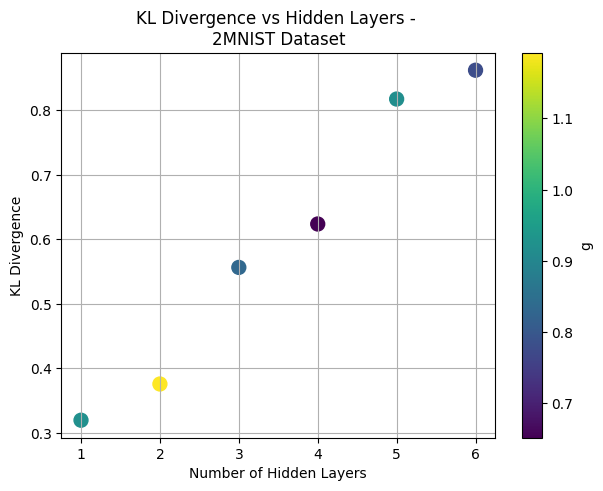

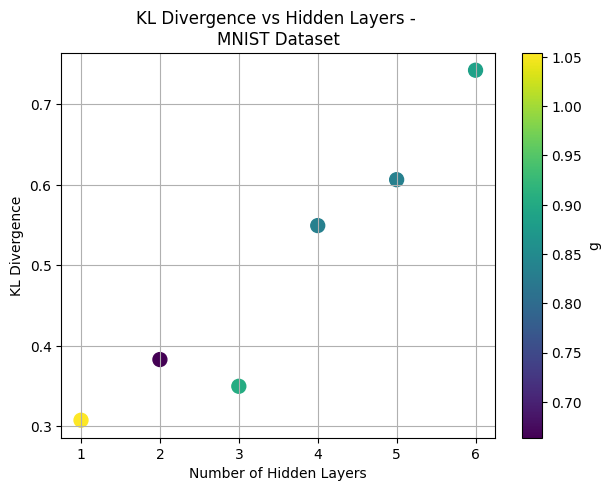

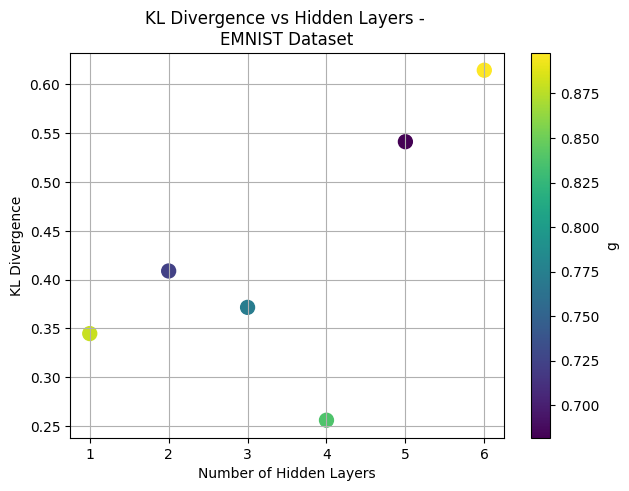

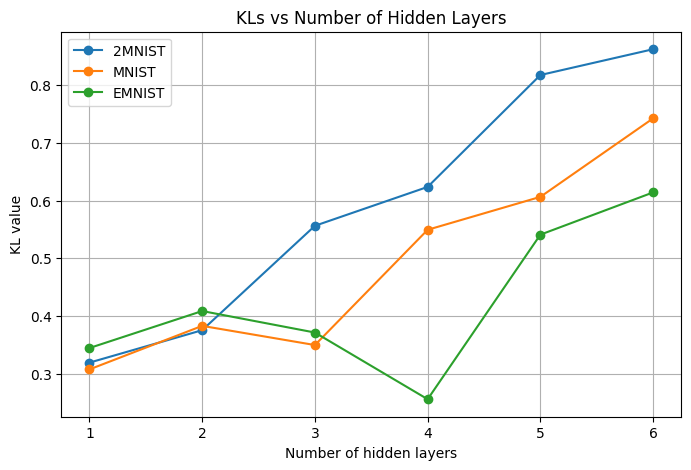

In [3]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

binarize_threshold = {"2MNIST": 2.5, "MNIST": 3.5, "EMNIST": 3.3} 


for dataset in ("2MNIST", "MNIST", "EMNIST"):
    
    for num_hidden_layers in range(1,7):
        latent_dim = 8
        decrease_rate = 0.6
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28

        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers,
            bottleneck_in_fn=nn.ReLU
        ).to(device)
        model_path = f"../models/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        KL, g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold[dataset])
        
        KLs_dict[dataset].append(KL)
        gs_dict[dataset].append(g)

        #save_dir = f"../Images/relu output/progressive train/{latent_dim}features/"
        save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)

datasets_dicts_comparison(KLs_dict, save_dir)

## Visualize 3hl neurons


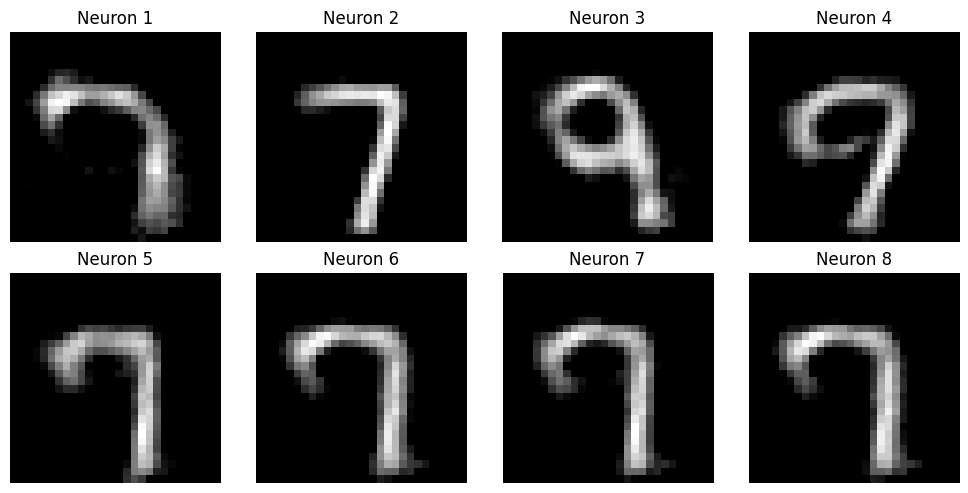

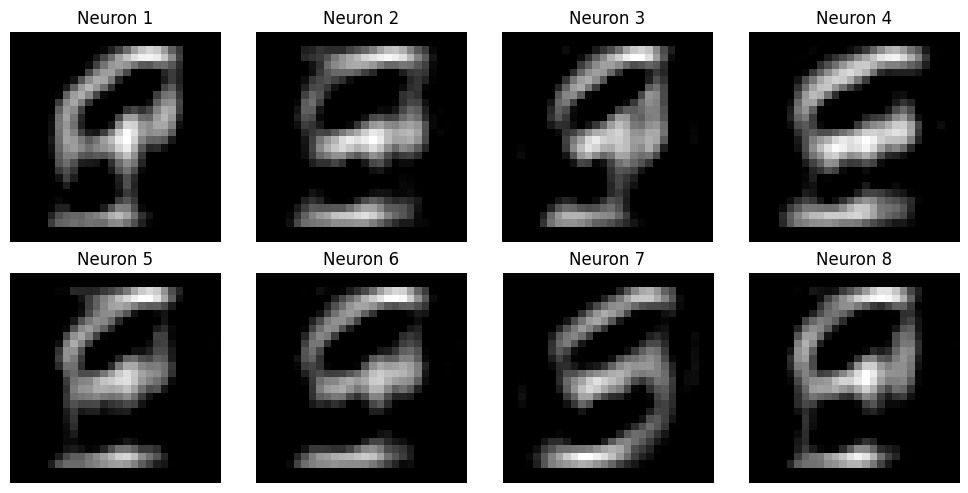

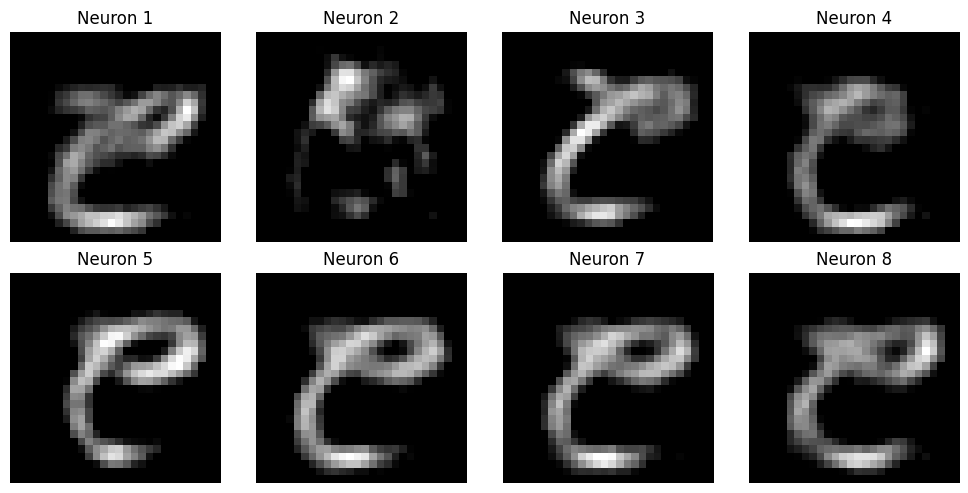

In [ ]:
for dataset in datasets:
    
    for latent_dim in (8,):
        num_hidden_layers = 4
        decrease_rate = 0.6
        train_loader = train_loaders[dataset]
        val_loader = val_loaders[dataset]
        input_dim = 28 * 28


        my_model = ProgressiveAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            decrease_rate=decrease_rate,
            device=device,
            num_hidden_layers=num_hidden_layers,
            bottleneck_in_fn=nn.ReLU
        ).to(device)
        model_path = f"../models/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))

        save_dir = f"../Images/relu output/progressive train/{latent_dim}features/{num_hidden_layers} latent neurons"

        visualize_bottleneck_neurons(my_model, device, save_dir=save_dir, file_name=dataset)

## Bottleneck neurons activation frequencies


In [180]:
### Not gagued

binarize_threshold = {"2MNIST": 2.5, "MNIST": 3.5, "EMNIST": 3.3} 

for latent_dim in (8,):
    with open(f'../Images/relu output/progressive train/{latent_dim}features/bottleneck_neurons_activations.txt', 'a') as f:
        for dataset in datasets:
            f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
            for num_hidden_layers in range(1,7):

                f.write(f"{num_hidden_layers} hl: ")

                decrease_rate = 0.6
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28


                my_model = ProgressiveAE(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    num_hidden_layers=num_hidden_layers,
                    bottleneck_in_fn=nn.ReLU
                ).to(device)
                model_path = f"../models/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                
                neurons_frequencies = compute_bottleneck_neurons_activ_freq(my_model, train_loader, binarize_threshold[dataset])

                formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                f.write(formatted_neuron_frequencies + '\n\n')
                

### Gagued

binarize_threshold = {"2MNIST": 2.5, "MNIST": 3.5, "EMNIST": 3.3} 

for latent_dim in (8,):
    with open(f'../Images/relu output/progressive train/{latent_dim}features/bottleneck_neurons_activations_gauged.txt', 'a') as f:
        for dataset in datasets:
            f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
            for num_hidden_layers in range(1,7):

                f.write(f"{num_hidden_layers} hl: ")

                decrease_rate = 0.6
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28


                my_model = ProgressiveAE(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    num_hidden_layers=num_hidden_layers,
                    bottleneck_in_fn=nn.ReLU
                ).to(device)
                model_path = f"../models/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                
                neurons_frequencies = compute_bottleneck_neurons_activ_freq_gauged(my_model, train_loader, binarize_threshold[dataset])

                formatted_neuron_frequencies = '(' + ', '.join(f"{v:.8f}" for v in neurons_frequencies) + ')'

                f.write(formatted_neuron_frequencies + '\n\n')

## Bottleneck weights 


In [ ]:

# Weights mean absolute value

with torch.no_grad():
    for latent_dim in (8,):
        with open(f'../Images/relu output/progressive train/{latent_dim}features/weights_mean_abs_value.txt', 'a') as f:
            for dataset in datasets:
                f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
                for num_hidden_layers in range(1,7): # from 1 to 6

                    f.write(f"{num_hidden_layers} hl: ")

                    decrease_rate = 0.6
                    train_loader = train_loaders[dataset]
                    val_loader = val_loaders[dataset]
                    input_dim = 28 * 28

                    my_model = ProgressiveAE(
                        input_dim=input_dim,
                        latent_dim=latent_dim,
                        decrease_rate=decrease_rate,
                        device=device,
                        num_hidden_layers=num_hidden_layers,
                        bottleneck_in_fn=nn.ReLU
                    ).to(device)
                    model_path = f"../models/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                    my_model.load_state_dict(torch.load(model_path, map_location=device))

                    weights_in = my_model.bottleneck_in[0].weight.data.abs().mean(dim=1).tolist()
                    formatted_weights_in = '(' + ', '.join(f"{v:.8f}" for v in weights_in) + ')'
                    f.write("In " + formatted_weights_in + '\n\n')

                    weights_out = my_model.bottleneck_out[0].weight.data.abs().mean(dim=0).tolist()
                    formatted_weights_out = '(' + ', '.join(f"{v:.8f}" for v in weights_out) + ')'
                    f.write("      Out " + formatted_weights_out + '\n\n')

## Gauge permutations


In [181]:
binarize_threshold = {"2MNIST": 2.5, "MNIST": 3.5, "EMNIST": 3.3} 

for latent_dim in (8,):
    with open(f'../Images/relu output/progressive train/{latent_dim}features/gauge_permutations.txt', 'a') as f:
        for dataset in datasets:
            f.write(f"\n-----------------------------------------{dataset}-----------------------------------------\n\n")
            for num_hidden_layers in range(1,7): # from 1 to 7

                f.write(f"{num_hidden_layers} hl: ")

                decrease_rate = 0.6
                train_loader = train_loaders[dataset]
                val_loader = val_loaders[dataset]
                input_dim = 28 * 28


                my_model = ProgressiveAE(
                    input_dim=input_dim,
                    latent_dim=latent_dim,
                    decrease_rate=decrease_rate,
                    device=device,
                    num_hidden_layers=num_hidden_layers,
                    bottleneck_in_fn=nn.ReLU
                ).to(device)
                model_path = f"../models/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth"
                my_model.load_state_dict(torch.load(model_path, map_location=device))

                emp_states_dict_guaged, perm = compute_emp_states_dict_gauged(my_model, train_loader, binarize_threshold=binarize_threshold[dataset], return_perm=True)
            
                f.write(str(perm) + '\n\n')

# Optimize binarize_threshold

## Sigmoid

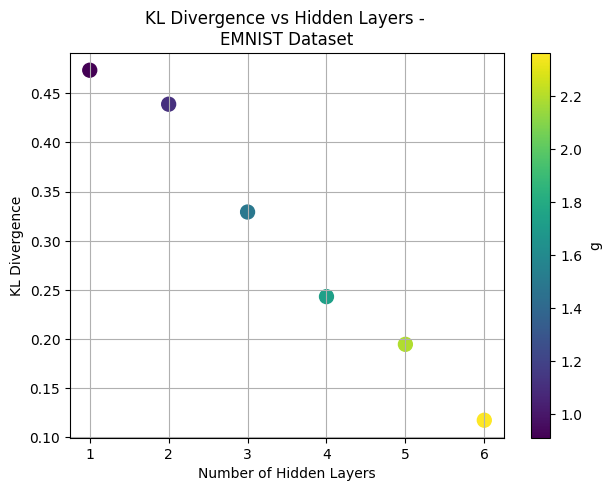

best_binarize_thresold:  0.1
best_energy:  tensor(0.1000, dtype=torch.float64)


In [177]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.1, 0.7, 15)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.5
            latent_dim = 6
            decrease_rate = 0.6
            decrease_rate_str = "06"
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28


            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers
            ).to(device)
            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/sigmoid_output/simultaneous train/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 0.1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

## 8 features

### Sigmoid

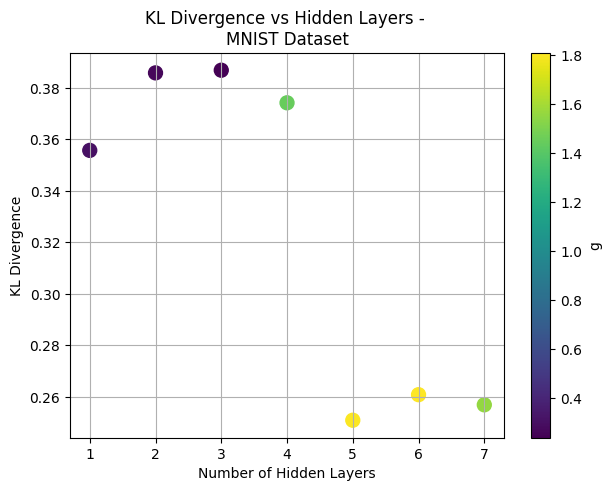

[np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1)]


In [17]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

best_binarize_thresolds = []



for dataset in ("MNIST",):
    
    for num_hidden_layers in range(1,8):    # 1-7 hl

        best_kld = float('inf')

        for binarize_threshold in np.linspace(0.1, 0.5, 10):
            
            latent_dim = 8
            decrease_rate = 0.6
            decrease_rate_str = "06"
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28


            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers
            ).to(device)
            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))


            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            if current_kld < best_kld:

                best_kld = current_kld
                best_g = current_g
                best_threshold = binarize_threshold


        KLs_dict[dataset].append(best_kld)
        gs_dict[dataset].append(best_g)
        best_binarize_thresolds.append(best_threshold)

        #save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{binarize_threshold}"
        save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print(best_binarize_thresolds)

#datasets_dicts_comparison(KLs_dict, save_dir)

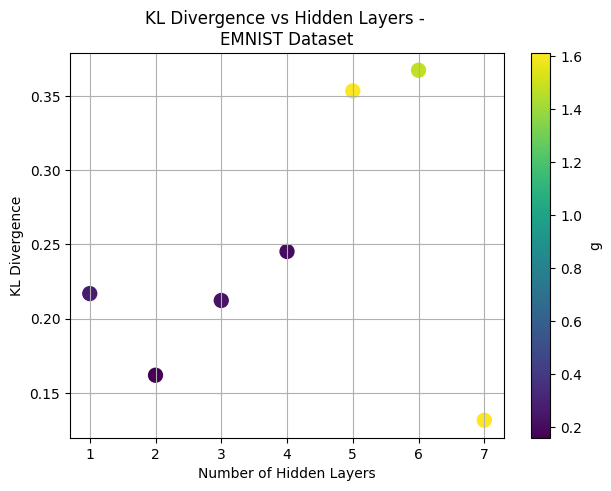

[np.float64(0.4111111111111111), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.1), np.float64(0.1), np.float64(0.1)]


In [18]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

best_binarize_thresolds = []



for dataset in ("EMNIST",):
    
    for num_hidden_layers in range(1,8):    # 1-7 hl

        best_kld = float('inf')

        for binarize_threshold in np.linspace(0.1, 0.5, 10):
            
            latent_dim = 8
            decrease_rate = 0.6
            decrease_rate_str = "06"
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28


            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers
            ).to(device)
            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))


            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            if current_kld < best_kld:

                best_kld = current_kld
                best_g = current_g
                best_threshold = binarize_threshold


        KLs_dict[dataset].append(best_kld)
        gs_dict[dataset].append(best_g)
        best_binarize_thresolds.append(best_threshold)

        #save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{binarize_threshold}"
        save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print(best_binarize_thresolds)

#datasets_dicts_comparison(KLs_dict, save_dir)

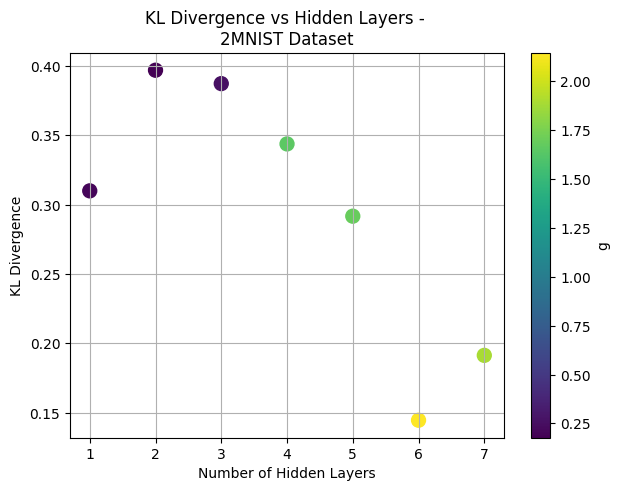

[np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(0.1)]


In [19]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

best_binarize_thresolds = []



for dataset in ("2MNIST",):
    
    for num_hidden_layers in range(1,8):    # 1-7 hl

        best_kld = float('inf')

        for binarize_threshold in np.linspace(0.1, 0.5, 10):
            
            latent_dim = 8
            decrease_rate = 0.6
            decrease_rate_str = "06"
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28


            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers
            ).to(device)
            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/{dataset}/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))


            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            if current_kld < best_kld:

                best_kld = current_kld
                best_g = current_g
                best_threshold = binarize_threshold


        KLs_dict[dataset].append(best_kld)
        gs_dict[dataset].append(best_g)
        best_binarize_thresolds.append(best_threshold)

        #save_dir = f"../Images/{latent_dim}features/simultaneous train/thresh_for_bin_{binarize_threshold}"
        save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print(best_binarize_thresolds)

#datasets_dicts_comparison(KLs_dict, save_dir)

### energy + set bias 1

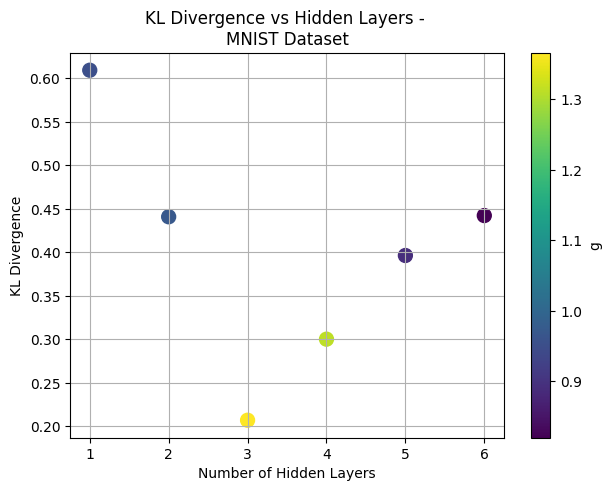

best_binarize_thresold:  1.7333333333333336
best_energy:  tensor(1.5033)


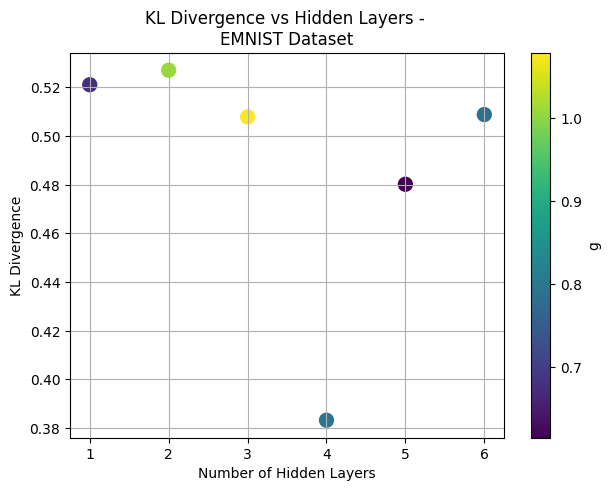

best_binarize_thresold:  2.8222222222222224
best_energy:  tensor(0.9062, dtype=torch.float64)


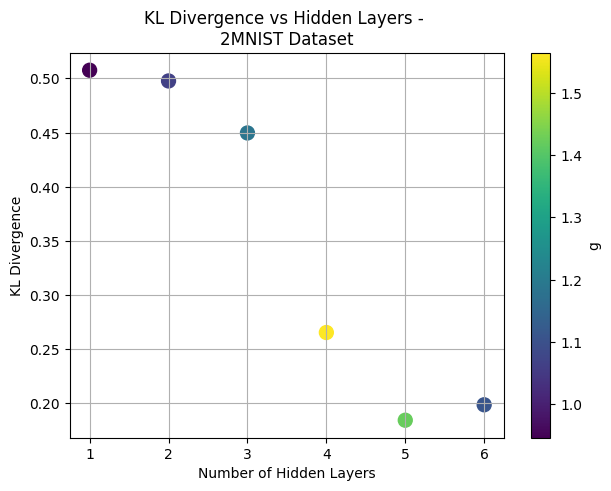

best_binarize_thresold:  1.7333333333333336
best_energy:  tensor(1.6371, dtype=torch.float64)


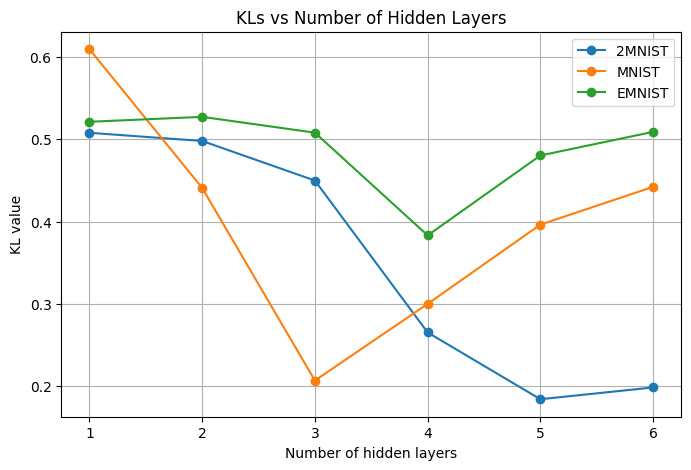

In [120]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("MNIST", "EMNIST", "2MNIST"):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.1, 5, 10)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 1.
            latent_dim = 8
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            klds_differences[i]
            + klds_std[i] 
            + klds_sign_changes[i] 
            +  gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

datasets_dicts_comparison(KLs_dict, save_dir)

## 6 features

### Bias 0.1 he init

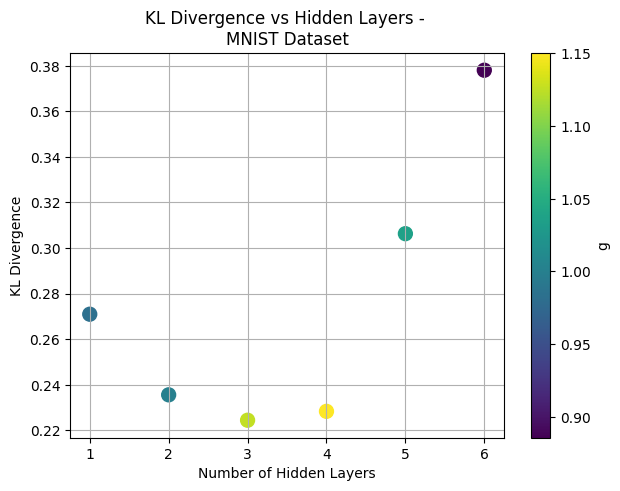

best_binarize_thresold:  2.507142857142857
best_energy:  tensor(0.4325)


In [218]:
# KLs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

# gs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.7, 3, 15)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/bias0.1/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

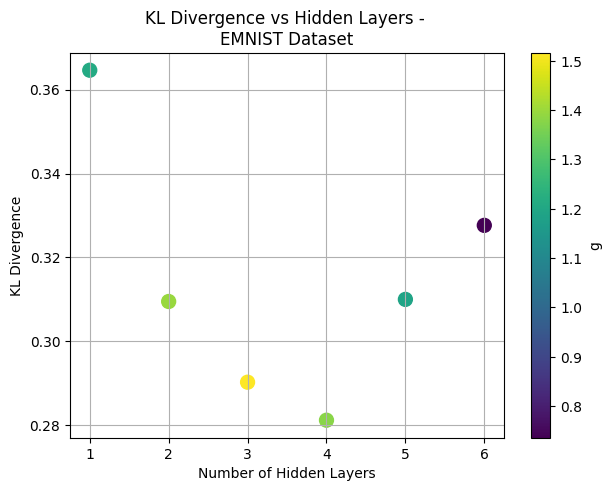

best_binarize_thresold:  1.55
best_energy:  tensor(1.4117)


In [217]:
# KLs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

# gs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}  

KLs_dict["EMNIST"] = []
gs_dict["EMNIST"] = []

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.1, 3, 15)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/bias0.1/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

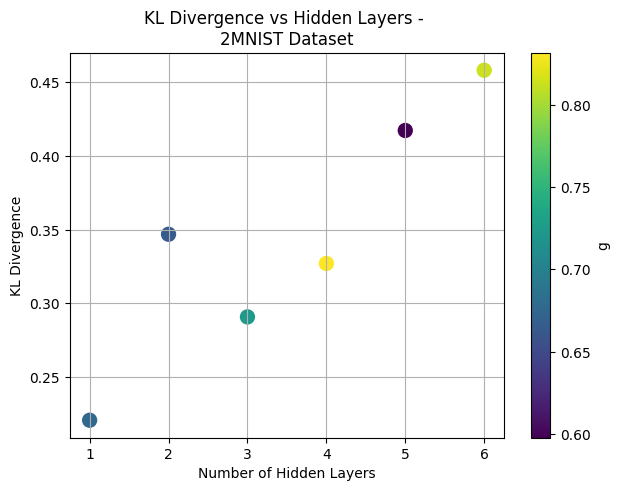

best_binarize_thresold:  3.992857142857143
best_energy:  tensor(1.9441)


In [215]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': [],
    '2MNIST_translated': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': [],
    '2MNIST_translated': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("2MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.3, 5, 15)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/bias0.1/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, train_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

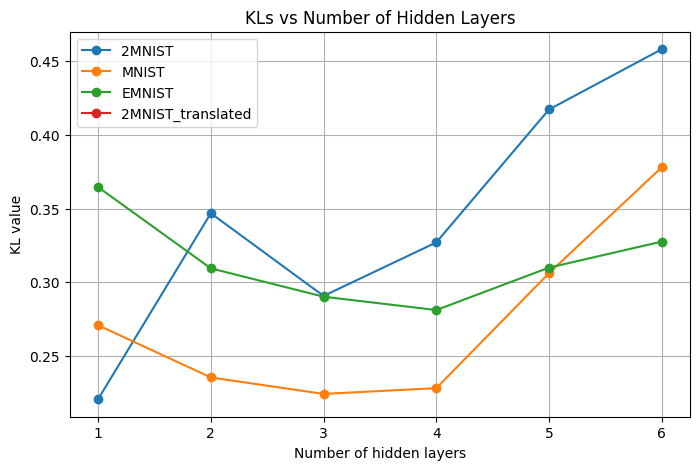

In [219]:
save_dir = None
datasets_dicts_comparison(KLs_dict, save_dir)

### Bias 0.0 he init

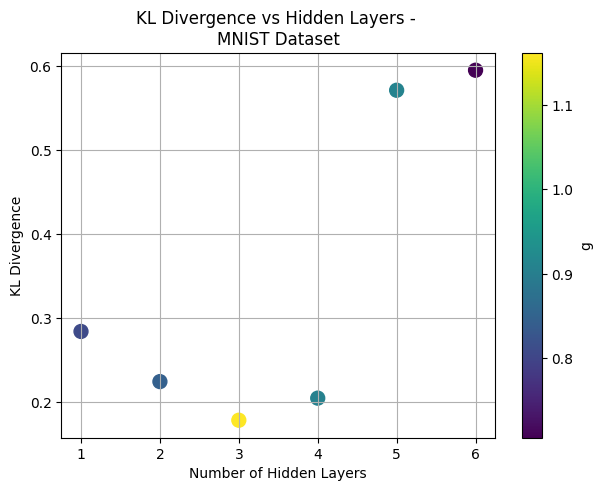

best_binarize_thresold:  3.1842105263157894
best_energy:  tensor(0.5986)


In [208]:
# KLs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

# gs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 9, 20)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

In [ ]:
# KLs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

# gs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 6, 15)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

FileNotFoundError: [Errno 2] No such file or directory: '../models/relu_output/he init/simultaneous train/EMNIST/ld6_lr0.0005_dr0.6_bias0.0_1hl_1.pth'

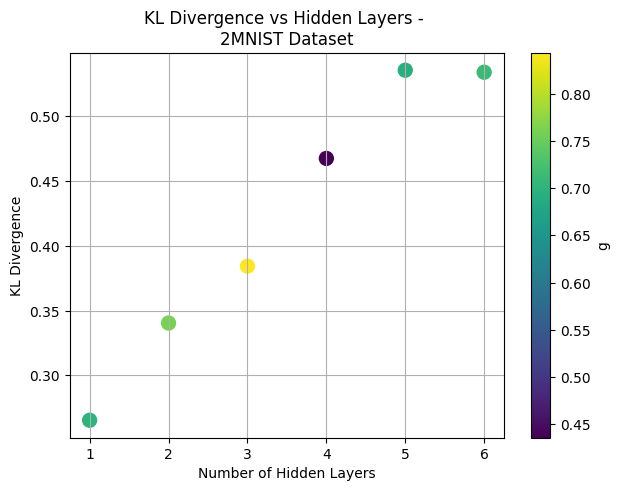

best_binarize_thresold:  3.8571428571428568
best_energy:  tensor(0.8011)


In [206]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("2MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(1, 5, 15)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

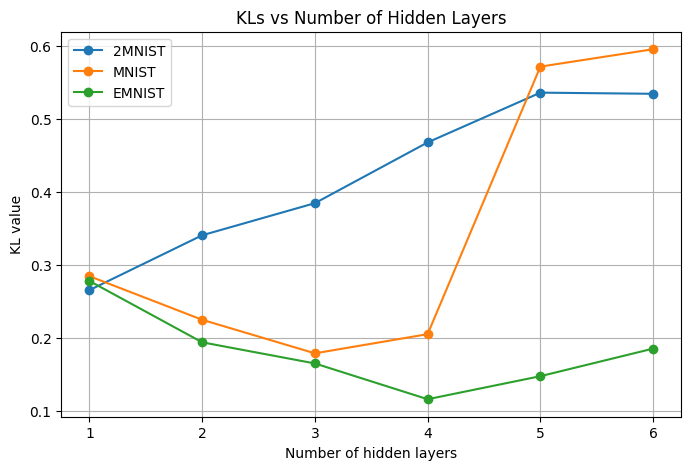

In [209]:
save_dir = None
datasets_dicts_comparison(KLs_dict, save_dir)

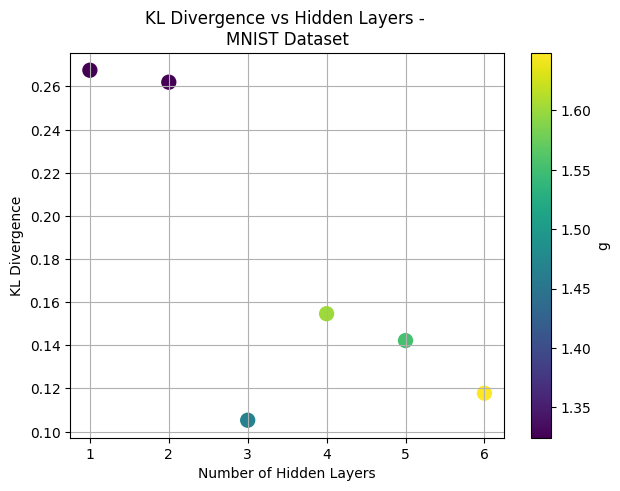

best_binarize_thresold:  1.3947368421052633
best_energy:  tensor(1.2897)


In [210]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 9, 20)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

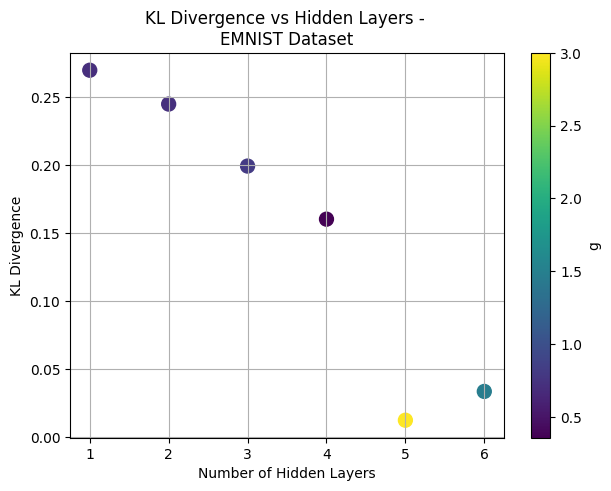

best_binarize_thresold:  4.555555555555555
best_energy:  tensor(1.2053)


In [211]:
# KLs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

# gs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(1, 5, 10)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

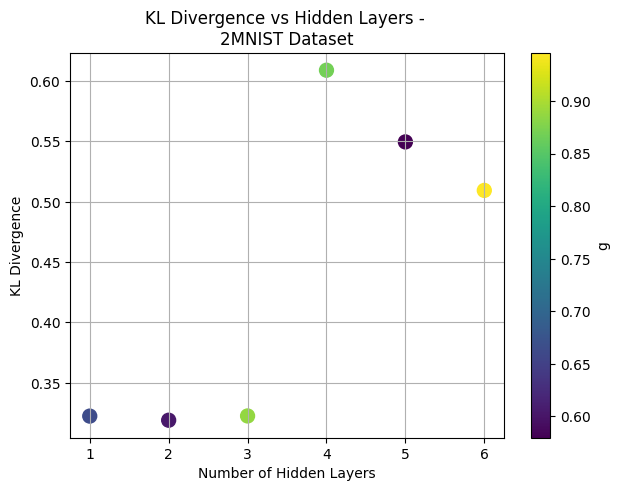

best_binarize_thresold:  3.6666666666666665
best_energy:  tensor(1.9766)


In [212]:
# KLs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

# gs_dict = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("2MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(2, 5, 10)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,7):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            10 * klds_sign_changes[i] 
            + 1 * gs_range[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

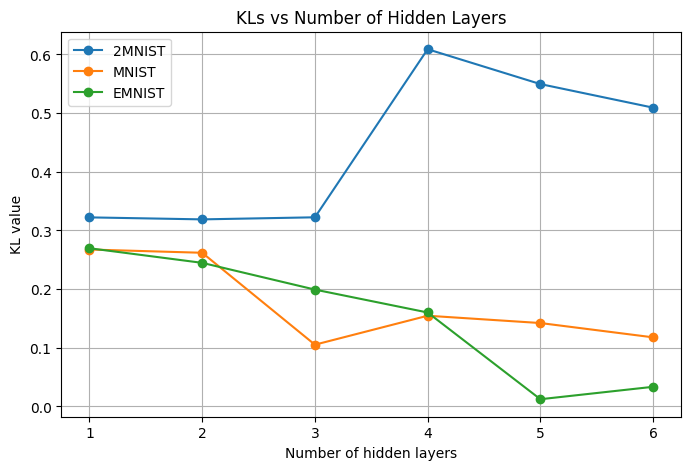

In [213]:
save_dir = None
datasets_dicts_comparison(KLs_dict, save_dir)

## new train

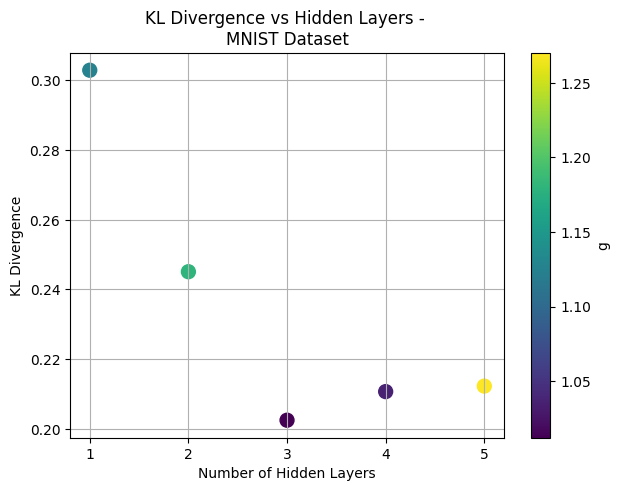

best_binarize_thresold:  2.0
best_energy:  tensor(1.6236)


In [24]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []
    gs_distances = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 6, 12)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,6):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )
        gs_distances.append( sum(abs(a - np.log(2)) for a in gs) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)
    gs_distances = np.array(gs_distances) / max(gs_distances)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            5 * klds_sign_changes[i] 
            #+ 1 * gs_range[i]
            + 5* gs_distances[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

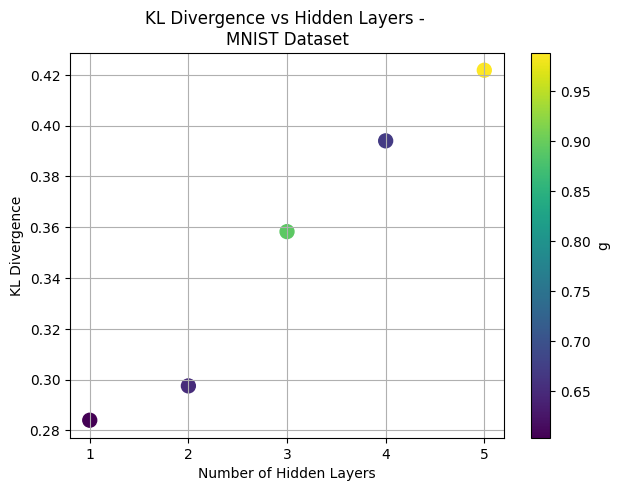

best_binarize_thresold:  4.0
best_energy:  tensor(0.4230, dtype=torch.float64)


In [25]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []
    gs_distances = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 6, 12)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,6):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )
        gs_distances.append( sum(abs(a - np.log(2)) for a in gs) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)
    gs_distances = np.array(gs_distances) / max(gs_distances)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            5 * klds_sign_changes[i] 
            #+ 1 * gs_range[i]
            + 5* gs_distances[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

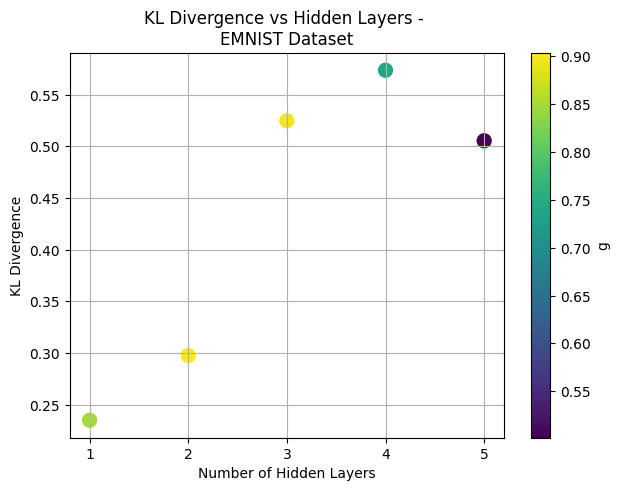

best_binarize_thresold:  3.5
best_energy:  tensor(1.5416)


In [21]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []
    gs_distances = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 6, 12)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,6):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )
        gs_distances.append( sum(abs(a - np.log(2)) for a in gs) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)
    gs_distances = np.array(gs_distances) / max(gs_distances)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            5 * klds_sign_changes[i] 
            #+ 1 * gs_range[i]
            + 5* gs_distances[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

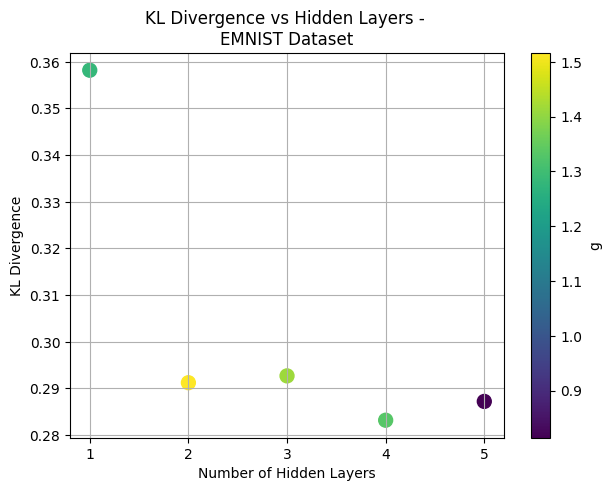

best_binarize_thresold:  1.5
best_energy:  tensor(2.6343)


In [20]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []
    gs_distances = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 6, 12)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,6):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )
        gs_distances.append( sum(abs(a - np.log(2)) for a in gs) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)
    gs_distances = np.array(gs_distances) / max(gs_distances)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            5 * klds_sign_changes[i] 
            #+ 1 * gs_range[i]
            + 5* gs_distances[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

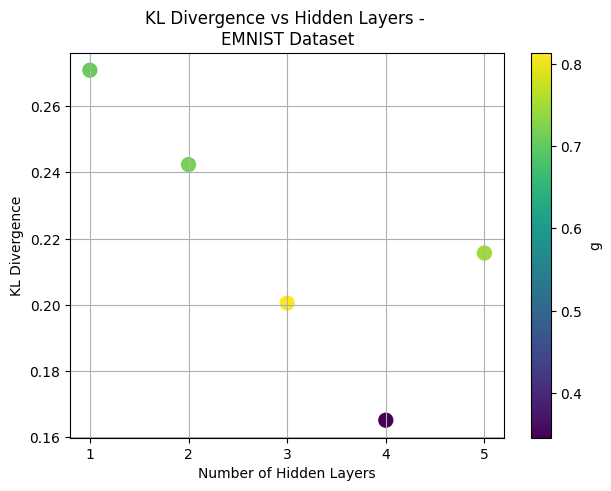

best_binarize_thresold:  4.590909090909091
best_energy:  tensor(0.1393)


In [19]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []
    gs_distances = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 8, 12)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,6):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_0.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )
        gs_distances.append( sum(abs(a - np.log(2)) for a in gs) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)
    gs_distances = np.array(gs_distances) / max(gs_distances)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            1 * klds_sign_changes[i] 
            #+ 1 * gs_range[i]
            + 1* gs_distances[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

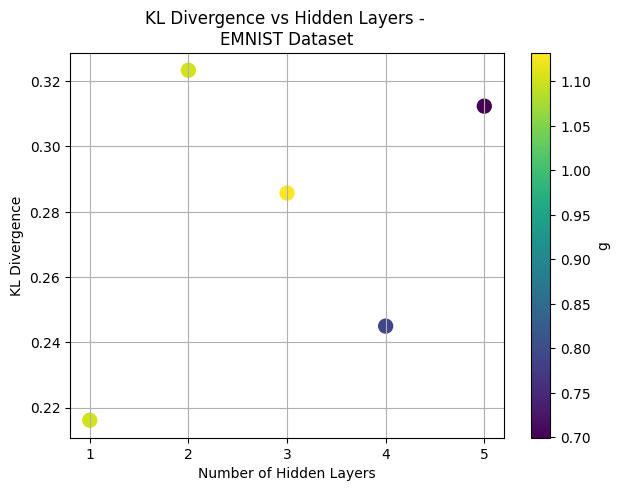

best_binarize_thresold:  2.5454545454545454
best_energy:  tensor(0.3690)


In [26]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("EMNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []
    gs_distances = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 8, 12)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,6):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )
        gs_distances.append( sum(abs(a - np.log(2)) for a in gs) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)
    gs_distances = np.array(gs_distances) / max(gs_distances)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            1 * klds_sign_changes[i] 
            #+ 1 * gs_range[i]
            + 1* gs_distances[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

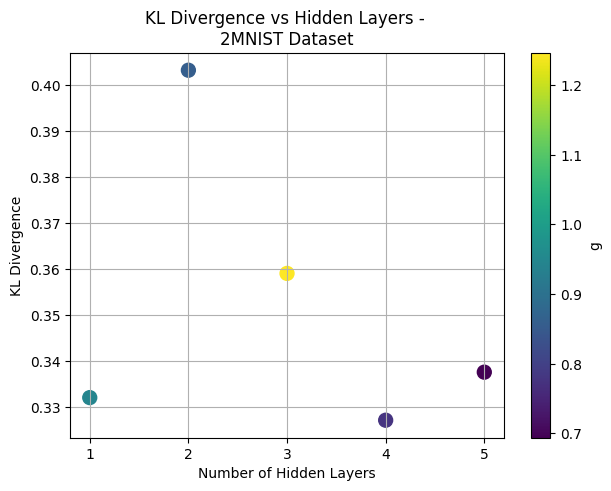

best_binarize_thresold:  2.5454545454545454
best_energy:  tensor(0.4650)


In [23]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

def count_sign_changes(values):
    """
    Counts the number of sign changes in the first differences of a sequence.
    Args:
        values (list or np.ndarray): Input sequence of numbers.
    Returns:
        int: The computed 'energy' (number of sign changes).
    """
    diff_0 = 0
    energy = 0
    for a, b in zip(values[:-1], values[1:]):
        diff_1 = b - a
        if diff_0 == 0:
            diff_0 = diff_1
            continue
        if np.sign(diff_1) != np.sign(diff_0):
            energy += 1*abs(diff_1)
        diff_0 = diff_1
    return energy


for dataset in ("2MNIST",):

    klds_differences = []
    klds_std = []
    klds_sign_changes = []
    gs_range = []
    gs_distances = []

    klds_bin_dict = {}
    gs_bin_dict = {}

    binarize_threshold_range = np.linspace(0.5, 8, 12)


    for binarize_threshold in binarize_threshold_range:

        gs = []
        klds = []

        for num_hidden_layers in range(1,6):
            learning_rate = 5e-4
            bias = 0.0
            latent_dim = 6
            decrease_rate = 0.6
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                hidden_layers=num_hidden_layers,
                output_activation_encoder=nn.ReLU
            ).to(device)
            model_path = f"../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_0.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))

            current_kld, current_g = calc_hfm_kld_with_optimal_g(my_model, val_loader, return_g=True, binarize_threshold=binarize_threshold)
            
            gs.append(current_g)
            klds.append(current_kld)

        klds_bin_dict[str(binarize_threshold)] = klds
        gs_bin_dict[str(binarize_threshold)] = gs

        klds_differences.append( sum(abs(a - b) for a, b in zip(klds[:-1], klds[1:])) )
        klds_std.append( np.std(klds) )
        klds_sign_changes.append( count_sign_changes(klds) )
        gs_range.append( (sorted(gs)[-1] - sorted(gs)[0]) )
        gs_distances.append( sum(abs(a - np.log(2)) for a in gs) )

    klds_differences = np.array(klds_differences) / max(klds_differences)
    klds_std = np.array(klds_std) / max(klds_std)
    klds_sign_changes = np.array(klds_sign_changes) / max(klds_sign_changes)
    gs_range = np.array(gs_range) / max(gs_range)
    gs_distances = np.array(gs_distances) / max(gs_distances)


    best_energy = float('inf')

    for i, binarize_threshold in enumerate(binarize_threshold_range):

        energy = (
            #klds_differences[i]
            #+ klds_std[i] 
            3.5 * klds_sign_changes[i] 
            #+ 1 * gs_range[i]
            + 1* gs_distances[i]
        )

        if energy < best_energy:
            best_energy = energy
            KLs_dict[dataset] = klds_bin_dict[str(binarize_threshold)]
            gs_dict[dataset] = gs_bin_dict[str(binarize_threshold)]
            best_binarize_thresold = binarize_threshold

    #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
    save_dir = None

    plot_KLs_vs_hidden_layers(KLs_dict[dataset], gs_dict[dataset], dataset, save_dir=save_dir)
    print("best_binarize_thresold: ", best_binarize_thresold)
    print("best_energy: ", best_energy)

#datasets_dicts_comparison(KLs_dict, save_dir)

In [3]:
dataset = "EMNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 6,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.ReLU
}
model_path_kwargs = {
    'output_activation_encoder': 'relu_output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}features",
    'dataset': dataset,
    'decrease_rate': model_kwargs['decrease_rate'],
    'learning_rate': 5e-4,
    'bias': 0.0,
    'train_num': 0
}

best_binarize_thresold:  4.590909090909091
best_energy:  tensor(0.1393)


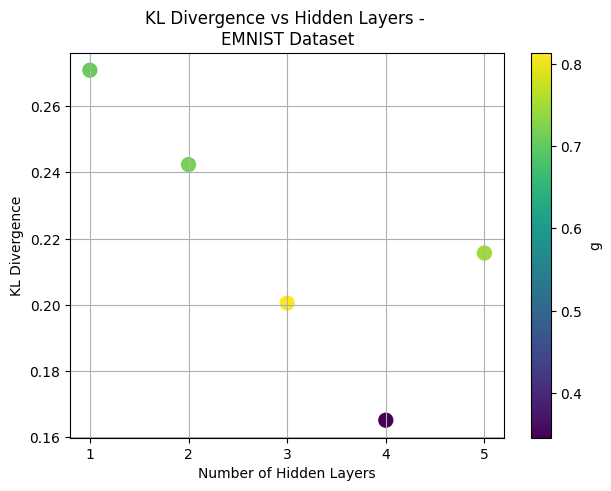

In [7]:
model_path_kwargs['bias'] = 0.0
model_path_kwargs['train_num'] = 0

binarize_threshold_range = np.linspace(0.5, 8, 12)
num_hidden_layers_range = range(1,6)

dataset_klds_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}
dataset_gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

dataset_klds_dict, dataset_gs_dict = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict, 
    dataset_gs_dict=dataset_gs_dict, 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[dataset], dataset_gs_dict[dataset], dataset, save_dir=save_dir)


## Mean

In [49]:
import numpy as np

def mean_over_outer_dict(dataset_dicts, selected_train_nums=None):
    # If not specified, use all train_nums
    if selected_train_nums is None:
        train_nums = list(dataset_dicts.keys())
    else:
        train_nums = list(selected_train_nums)
    # Get all dataset names (assume all inner dicts have the same keys)
    dataset_names = list(dataset_dicts[train_nums[0]].keys())
    # Prepare output
    mean_dict = {ds: [] for ds in dataset_names}
    # Find the minimum length for each dataset to avoid shape mismatch
    min_lengths = {ds: min(len(dataset_dicts[tn][ds]) for tn in train_nums) for ds in dataset_names}
    # Compute mean for each dataset and each position
    for ds in dataset_names:
        # Stack lists for this dataset across all selected train_nums, up to min length
        stacked = np.array([dataset_dicts[tn][ds][:min_lengths[ds]] for tn in train_nums])
        mean_dict[ds] = stacked.mean(axis=0).tolist()
    return mean_dict

### 2MNIST

In [114]:
dataset = "2MNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 6,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.ReLU
}
model_path_kwargs = {
    'output_activation_encoder': 'relu_output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': model_kwargs['decrease_rate'],
    'learning_rate': 5e-4,
    'bias': 0.0,
    'train_num': 0
}



In [ ]:
dataset_klds_dict = {}
dataset_gs_dict = {}

best_binarize_thresold:  6.716666666666667
best_energy:  tensor(0.4479)


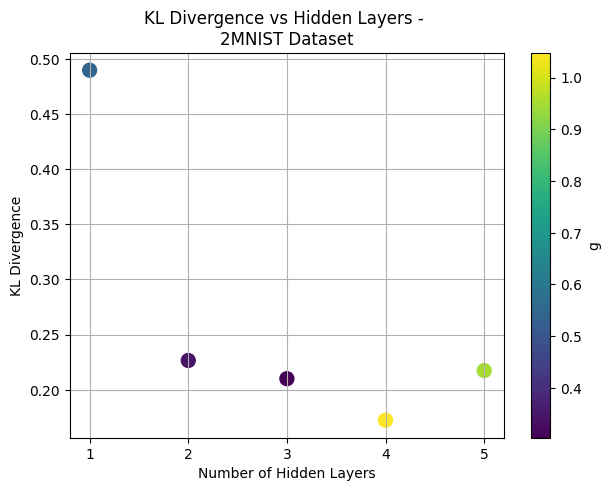

In [116]:
train_num = 0
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

# dataset_klds_dict[train_num] = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}
# dataset_gs_dict[train_num] = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  3.5083333333333333
best_energy:  tensor(0.2445)


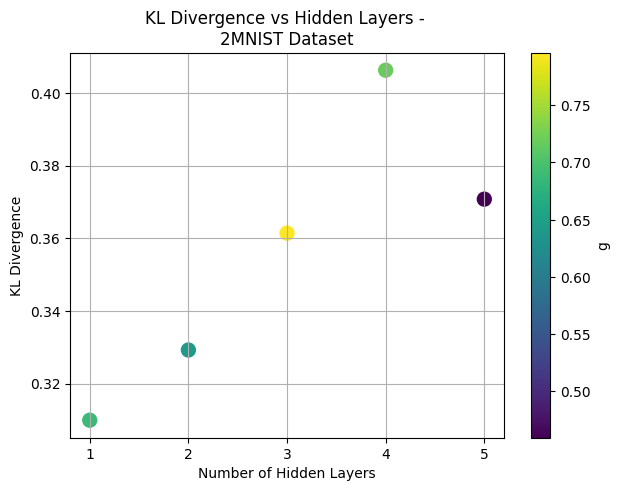

In [117]:
train_num = 1
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num] = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}
dataset_gs_dict[train_num] = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  4.15
best_energy:  tensor(0.0539, dtype=torch.float64)


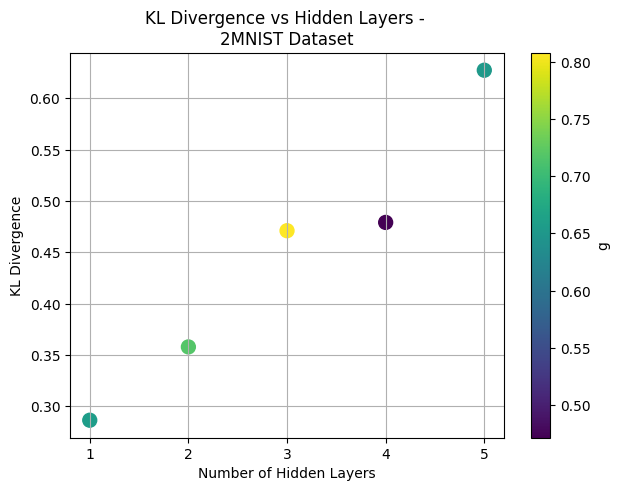

In [118]:
train_num = 2
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num] = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}
dataset_gs_dict[train_num] = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  3.5083333333333333
best_energy:  tensor(0.0500, dtype=torch.float64)


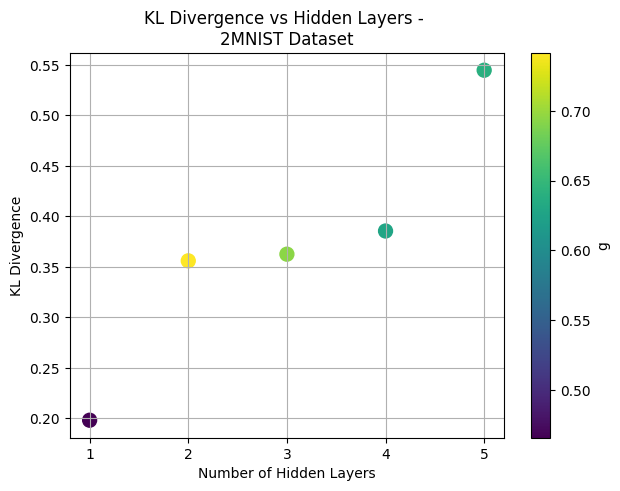

In [119]:
train_num = 3
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

# dataset_klds_dict[train_num] = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}
# dataset_gs_dict[train_num] = {
#     '2MNIST': [],
#     'MNIST': [],
#     'EMNIST': []}

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

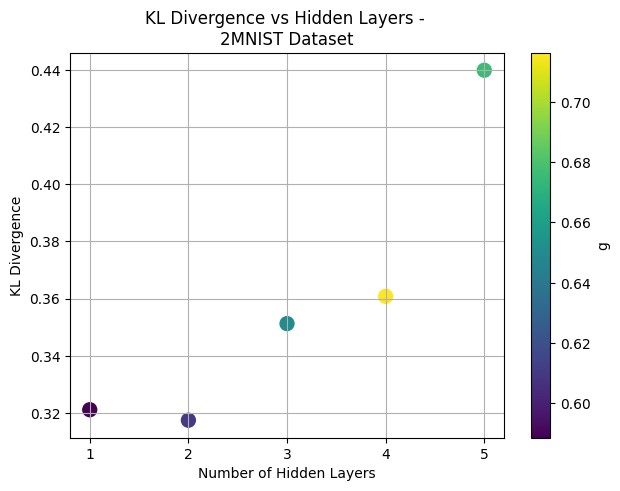

In [120]:
mean_klds = mean_over_outer_dict(dataset_klds_dict, selected_train_nums=(0,1,2,3))
mean_gs = mean_over_outer_dict(dataset_gs_dict, selected_train_nums=(0,1,2,3))
plot_KLs_vs_hidden_layers(mean_klds[dataset], mean_gs[dataset], dataset, save_dir=save_dir)

### MNIST

In [142]:
dataset = "MNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 6,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.ReLU
}
model_path_kwargs = {
    'output_activation_encoder': 'relu_output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': model_kwargs['decrease_rate'],
    'learning_rate': 5e-4,
    'bias': 0.0,
    'train_num': 0
}



In [ ]:

dataset_klds_dict = {}
dataset_gs_dict = {}

dataset_klds_dict[train_num] = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}
dataset_gs_dict[train_num] = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}


best_binarize_thresold:  4.15
best_energy:  tensor(0.4290, dtype=torch.float64)


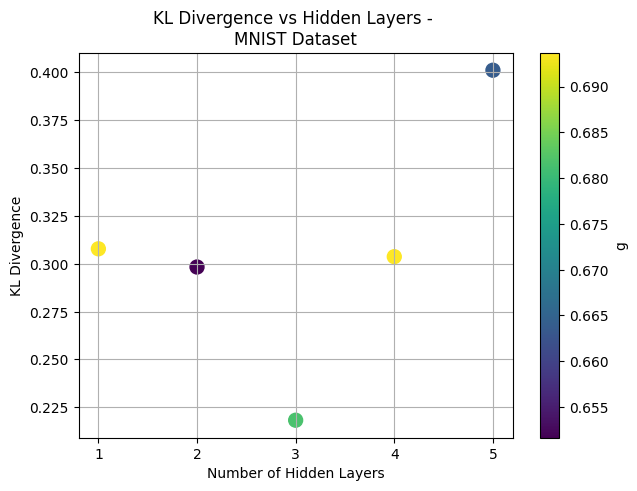

In [122]:
train_num = 0
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  2.8666666666666667
best_energy:  tensor(0.2929)


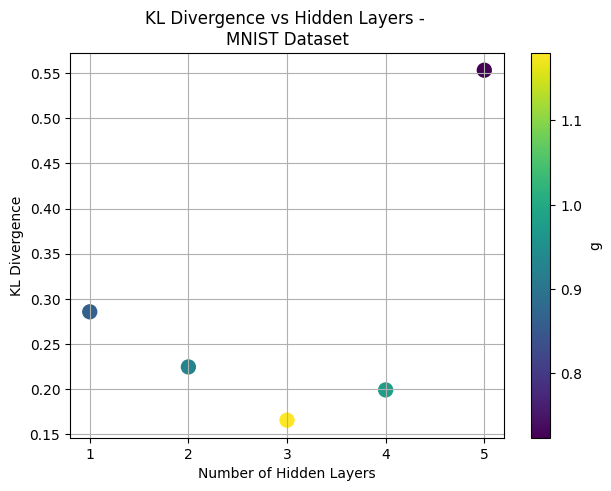

In [146]:
train_num = 1
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  2.225
best_energy:  tensor(0.3250)


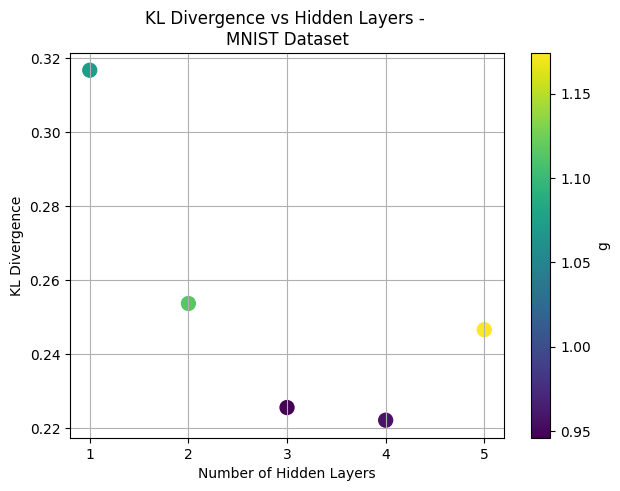

In [124]:
train_num = 2
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  7.358333333333333
best_energy:  tensor(0.4649)


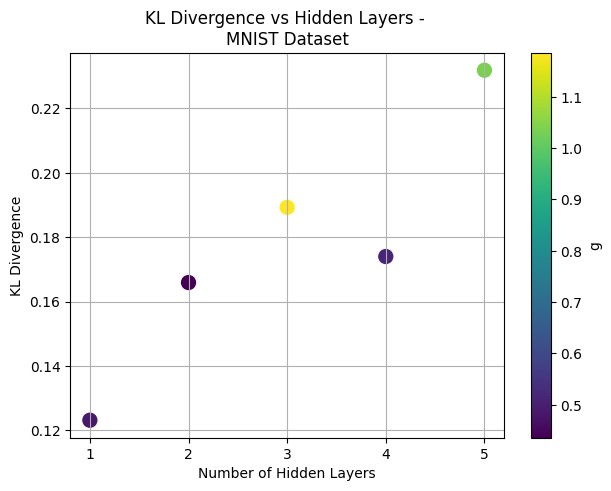

In [143]:
train_num = 3
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

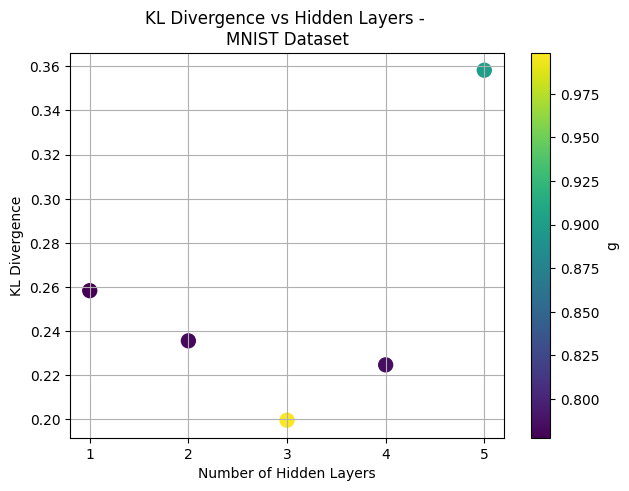

In [147]:
mean_klds = mean_over_outer_dict(dataset_klds_dict, selected_train_nums=(0,1,2,3))
mean_gs = mean_over_outer_dict(dataset_gs_dict, selected_train_nums=(0,1,2,3))
plot_KLs_vs_hidden_layers(mean_klds[dataset], mean_gs[dataset], dataset, save_dir=save_dir)

### EMNIST

In [148]:
dataset = "EMNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 6,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.ReLU
}
model_path_kwargs = {
    'output_activation_encoder': 'relu_output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': model_kwargs['decrease_rate'],
    'learning_rate': 5e-4,
    'bias': 0.0,
    'train_num': 0
}



best_binarize_thresold:  4.791666666666667
best_energy:  tensor(0.0702, dtype=torch.float64)


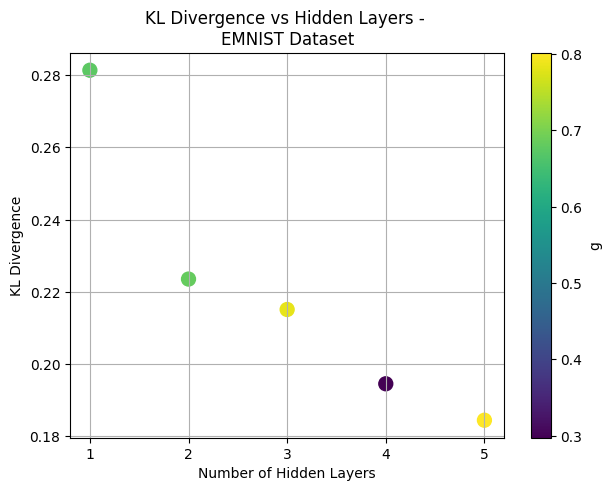

In [131]:
train_num = 0
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  5.433333333333334
best_energy:  tensor(0.2543)


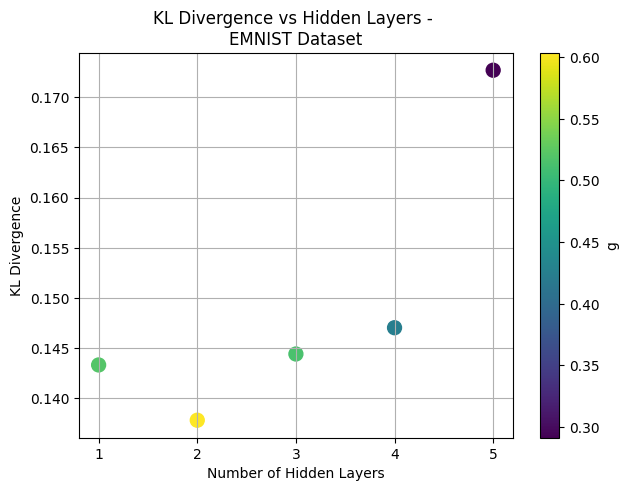

In [132]:
train_num = 1
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  2.225
best_energy:  tensor(0.2611, dtype=torch.float64)


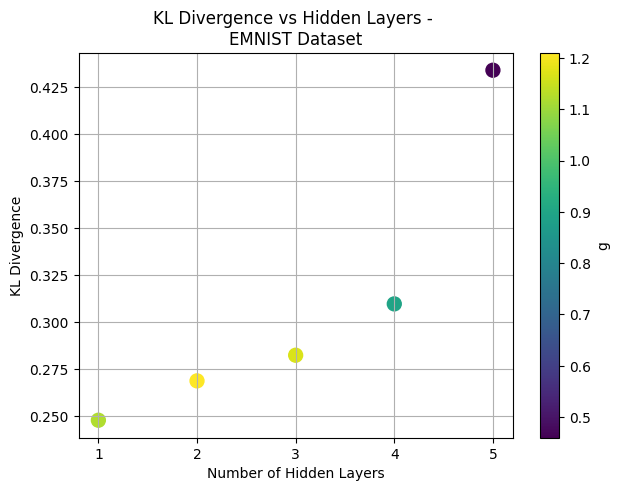

In [133]:
train_num = 2
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

best_binarize_thresold:  4.15
best_energy:  tensor(0.5160)


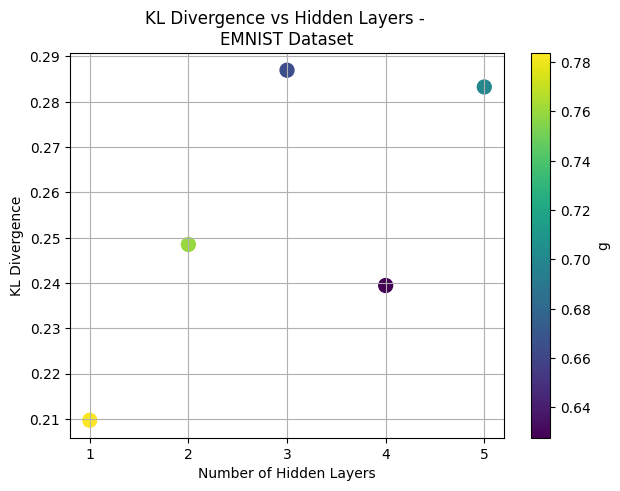

In [149]:
train_num = 3
binarize_threshold_range = np.linspace(0.3, 8, 13)
num_hidden_layers_range = range(1,6)

model_path_kwargs['train_num'] = train_num

dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_with_optimal_threshold_(
    dataset=dataset,
    data_loader=val_loaders[dataset],
    device=device,
    model_kwargs=model_kwargs, 
    model_path_kwargs=model_path_kwargs, 
    binarize_threshold_range=binarize_threshold_range, 
    num_hidden_layers_range=num_hidden_layers_range, 
    dataset_klds_dict=dataset_klds_dict[train_num], 
    dataset_gs_dict=dataset_gs_dict[train_num], 
    verbose=True
    )

save_dir = None
plot_KLs_vs_hidden_layers(dataset_klds_dict[train_num][dataset], dataset_gs_dict[train_num][dataset], dataset, save_dir=save_dir)

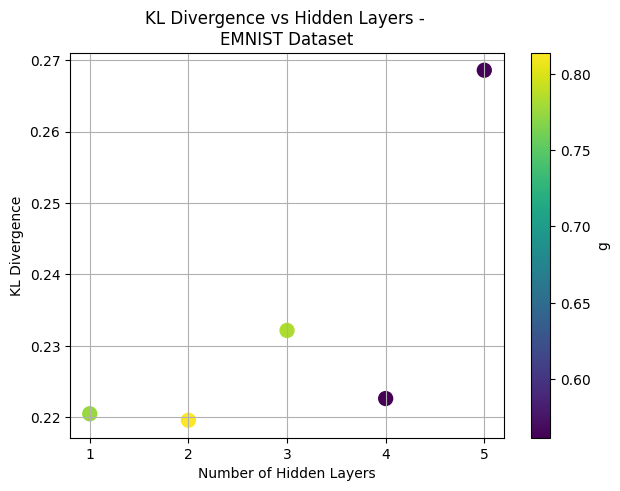

In [150]:
mean_klds = mean_over_outer_dict(dataset_klds_dict, selected_train_nums=(0,1,2,3))
mean_gs = mean_over_outer_dict(dataset_gs_dict, selected_train_nums=(0,1,2,3))
plot_KLs_vs_hidden_layers(mean_klds[dataset], mean_gs[dataset], dataset, save_dir=save_dir)

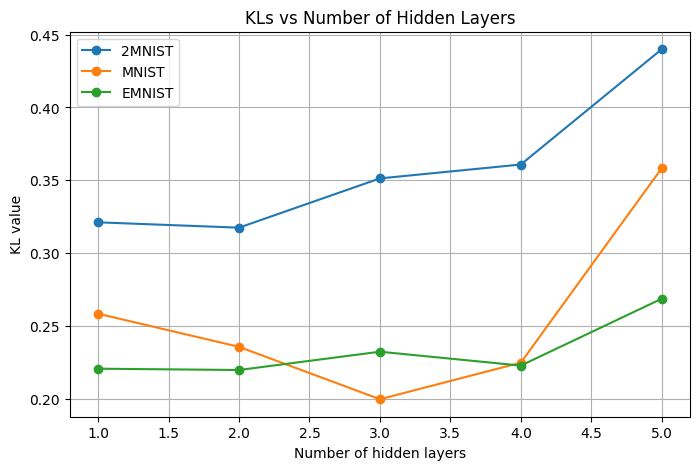

In [152]:
save_dir = None
datasets_dicts_comparison(mean_klds, save_dir)

In [129]:
print(mean_klds)

{'2MNIST': [0.3210621476173401, 0.31738653779029846, 0.35123011469841003, 0.36077386140823364, 0.4399903416633606], 'MNIST': [0.28252285718917847, 0.26190048456192017, 0.22821110486984253, 0.2531985938549042, 0.3624313771724701], 'EMNIST': []}


# Pure encoding

### ReLU output

In [87]:
def write_encoded_dataset_on_file(data_loader, model_kwargs, device, model_path_kwargs, num_hidden_layers_range):

    for num_hidden_layers in num_hidden_layers_range:

        my_model = AE_0(
            **model_kwargs,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"../models/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['initialization']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/lr{model_path_kwargs['learning_rate']}_dr{model_path_kwargs['decrease_rate']}_bias{model_path_kwargs['bias']}_{num_hidden_layers}hl_{model_path_kwargs['train_num']}.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))
        save_dir = f"../pure encoding/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/{model_path_kwargs['train_num']}/{num_hidden_layers}hl.txt"

        my_model.eval()
        with open(save_dir, 'w') as f:
            with torch.no_grad():
                for batch in data_loader:
                    # If batch is (data, label), take only data
                    if isinstance(batch, (list, tuple)):
                        data = batch[0]
                    else:
                        data = batch
                    data = data.to(device)
                    encoded = my_model.encode(data)
                    # Flatten each encoded vector and write as space-separated values
                    for vec in encoded.cpu().numpy():
                        formatted = '(' + ', '.join(f"{v:.8f}" for v in vec.tolist()) + ')'
                        f.write(formatted + '\n')


def write_encoded_dataset_on_file_sigmoid_output(data_loader, model_kwargs, device, model_path_kwargs, num_hidden_layers_range):

    for num_hidden_layers in num_hidden_layers_range:

        my_model = AE_0(
            **model_kwargs,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"../models/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/dr{model_path_kwargs['decrease_rate']}_lr{model_path_kwargs['learning_rate']}_lwpretrain_{num_hidden_layers}hl_{model_path_kwargs['train_num']}.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))
        save_dir = f"../pure encoding/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/{model_path_kwargs['train_num']}/{num_hidden_layers}hl.txt"

        my_model.eval()
        with open(save_dir, 'w') as f:
            with torch.no_grad():
                for batch in data_loader:
                    # If batch is (data, label), take only data
                    if isinstance(batch, (list, tuple)):
                        data = batch[0]
                    else:
                        data = batch
                    data = data.to(device)
                    encoded = my_model.encode(data)
                    # Flatten each encoded vector and write as space-separated values
                    for vec in encoded.cpu().numpy():
                        formatted = '(' + ', '.join(f"{v:.8f}" for v in vec.tolist()) + ')'
                        f.write(formatted + '\n')


In [145]:
dataset = "MNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 6,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.ReLU
}
model_path_kwargs = {
    'output_activation_encoder': 'relu_output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': model_kwargs['decrease_rate'],
    'learning_rate': 5e-4,
    'bias': 0.0,
    'train_num': 0
}

for train_num in (1,):
    model_path_kwargs['bias'] = 0.0
    model_path_kwargs['train_num'] = train_num

    num_hidden_layers_range = (3,5)

    write_encoded_dataset_on_file(train_loaders[dataset], model_kwargs, device, model_path_kwargs, num_hidden_layers_range)

In [138]:
dataset = "EMNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 6,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.ReLU
}
model_path_kwargs = {
    'output_activation_encoder': 'relu_output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': model_kwargs['decrease_rate'],
    'learning_rate': 5e-4,
    'bias': 0.0,
    'train_num': 0
}

for train_num in range(4):
    model_path_kwargs['bias'] = 0.0
    model_path_kwargs['train_num'] = train_num

    num_hidden_layers_range = range(1,6)

    write_encoded_dataset_on_file(train_loaders[dataset], model_kwargs, device, model_path_kwargs, num_hidden_layers_range)

In [139]:
dataset = "2MNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 6,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.ReLU
}
model_path_kwargs = {
    'output_activation_encoder': 'relu_output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': model_kwargs['decrease_rate'],
    'learning_rate': 5e-4,
    'bias': 0.0,
    'train_num': 3
}

for train_num in range(4):
    model_path_kwargs['bias'] = 0.0
    model_path_kwargs['train_num'] = train_num

    num_hidden_layers_range = range(1,6)

    write_encoded_dataset_on_file(train_loaders[dataset], model_kwargs, device, model_path_kwargs, num_hidden_layers_range)

### Sigmoid output

In [4]:
def write_encoded_dataset_on_file_sigmoid_output(data_loader, model_kwargs, device, model_path_kwargs, num_hidden_layers_range):

    for num_hidden_layers in num_hidden_layers_range:

        my_model = AE_0(
            **model_kwargs,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"../models/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/dr{model_path_kwargs['decrease_rate']}_{num_hidden_layers}hl_{model_path_kwargs['train_num']}.pth"
        my_model.load_state_dict(torch.load(model_path, map_location=device))
        save_dir = f"../pure encoding/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/{model_path_kwargs['train_num']}/{num_hidden_layers}hl.txt"

        my_model.eval()
        with open(save_dir, 'w') as f:
            with torch.no_grad():
                for batch in data_loader:
                    # If batch is (data, label), take only data
                    if isinstance(batch, (list, tuple)):
                        data = batch[0]
                    else:
                        data = batch
                    data = data.to(device)
                    encoded = my_model.encode(data)
                    # Flatten each encoded vector and write as space-separated values
                    for vec in encoded.cpu().numpy():
                        formatted = '(' + ', '.join(f"{v:.8f}" for v in vec.tolist()) + ')'
                        f.write(formatted + '\n')


In [4]:
from AE.depth_utils import write_encoded_dataset_on_file_sigmoid_output

In [12]:
model_kwargs = {
    'input_dim': 28*28,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'initialization': 'he init',
    'train_type': 'simultaneous train',
    'decrease_rate': '06',
    'learning_rate': '1e3',
}

for dataset in ("2MNIST", "MNIST", "EMNIST", "FEMNIST"):
    model_path_kwargs['dataset'] = dataset

    for latent_dim in (10, 12):
        model_kwargs['latent_dim'] = latent_dim
        model_path_kwargs['latent_dim'] = f"{latent_dim}ld"

        for train_num in range(6):
            model_path_kwargs['train_num'] = train_num

            num_hidden_layers_range = range(1,8)

            write_encoded_dataset_on_file_sigmoid_output(train_loaders[dataset], model_kwargs, device, model_path_kwargs, num_hidden_layers_range)

# Sample from sigmoid output

In [7]:
def compute_dataset_klds_gs_dict_from_sampled_binarized_vectors(dataset, data_loader, model_kwargs, device, model_path_kwargs, num_hidden_layers_range, dataset_klds_dict = None, dataset_gs_dict = None):

    if dataset_klds_dict is None:
        dataset_klds_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}
    if dataset_gs_dict is None:
        dataset_gs_dict = {
            '2MNIST': [],
            'MNIST': [],
            'EMNIST': []}


    for num_hidden_layers in num_hidden_layers_range:

        model = AE_0(
            **model_kwargs,
            hidden_layers=num_hidden_layers
        ).to(device)
        model_path = f"../models/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/dr{model_path_kwargs['decrease_rate']}_{num_hidden_layers}hl_{model_path_kwargs['train_num']}.pth"
        model.load_state_dict(torch.load(model_path, map_location=device))
        

        model.eval()

        kld, g = calc_hfm_kld_with_optimal_g(model, data_loader, return_g=True, binarize_threshold=None)

        dataset_klds_dict[dataset].append(kld)
        dataset_gs_dict[dataset].append(g)

        #save_dir = f"../pure encoding/{model_path_kwargs['output_activation_encoder']}/{model_path_kwargs['train_type']}/{model_path_kwargs['latent_dim']}/{model_path_kwargs['dataset']}/{model_path_kwargs['train_num']}/{num_hidden_layers}hl.txt"
        #save_dir = f"../Images/relu output/simultaneous train/{latent_dim}features/"
        save_dir = None

    return dataset_klds_dict, dataset_gs_dict



In [ ]:
import numpy as np

def mean_over_outer_dict(dataset_dicts, selected_train_nums=None):
    # If not specified, use all train_nums
    if selected_train_nums is None:
        train_nums = list(dataset_dicts.keys())
    else:
        train_nums = list(selected_train_nums)
    # Get all dataset names (assume all inner dicts have the same keys)
    dataset_names = list(dataset_dicts[train_nums[0]].keys())
    # Prepare output
    mean_dict = {ds: [] for ds in dataset_names}
    # Find the minimum length for each dataset to avoid shape mismatch
    min_lengths = {ds: min(len(dataset_dicts[tn][ds]) for tn in train_nums) for ds in dataset_names}
    # Compute mean for each dataset and each position
    for ds in dataset_names:
        # Stack lists for this dataset across all selected train_nums, up to min length
        stacked = np.array([dataset_dicts[tn][ds][:min_lengths[ds]] for tn in train_nums])
        mean_dict[ds] = stacked.mean(axis=0).tolist()
    return mean_dict

## MNIST

In [ ]:

dataset = "MNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 10,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}


In [61]:
dataset_klds_dict = {}
dataset_gs_dict = {}

In [ ]:
num_hidden_layers_range = range(1,8)
for train_num in range(1):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict:
        dataset_klds_dict[train_num] = {'2MNIST': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict:
        dataset_gs_dict[train_num] = {'2MNIST': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        hfm_distribution = 'pure',
        dataset_klds_dict=dataset_klds_dict[train_num],
        dataset_gs_dict=dataset_gs_dict[train_num]
    )


In [63]:
with open('../savings/dataset_klds_dict_original_MNIST.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict, f)
with open('../savings/dataset_gs_dict_original_MNIST.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict, f)

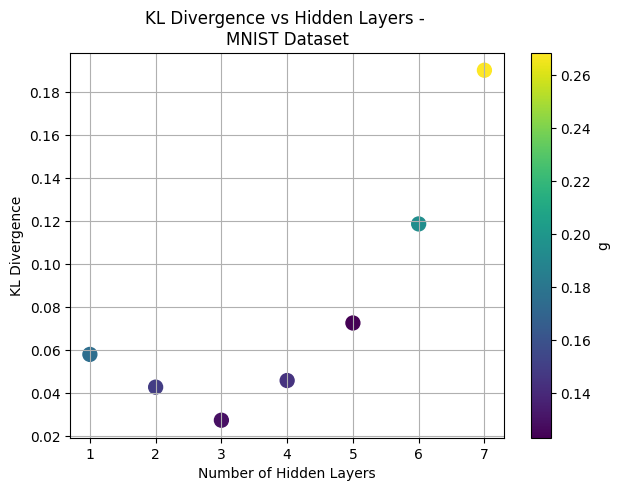

In [17]:
save_dir = None
mean_klds_original = mean_over_outer_dict(dataset_klds_dict, selected_train_nums=(0,1,2,3,4,5))
mean_gs_original = mean_over_outer_dict(dataset_gs_dict, selected_train_nums=(0,1,2,3,4,5))
plot_KLs_vs_hidden_layers(mean_klds_original[dataset], mean_gs_original[dataset], dataset, save_dir=save_dir)

In [20]:
mean_klds_comparison= {"MNIST": mean_klds_original[dataset]}
mean_gs_comparison= {"MNIST": mean_gs_original[dataset]}

## EMNIST

In [9]:
dataset_klds_dict_original = {}
dataset_gs_dict_original = {}


In [11]:

dataset = "EMNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 10,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}


In [13]:
dataset = "EMNIST"

num_hidden_layers_range = range(1,8)
for train_num in range(6):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict_original:
        dataset_klds_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict_original:
        dataset_gs_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict_original[train_num], dataset_gs_dict_original[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        dataset_klds_dict=dataset_klds_dict_original[train_num],
        dataset_gs_dict=dataset_gs_dict_original[train_num]
    )



In [14]:
import pickle

with open('../savings/dataset_klds_dict_original_EMNIST.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_original, f)
with open('../savings/dataset_gs_dict_original_EMNIST.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_original, f)

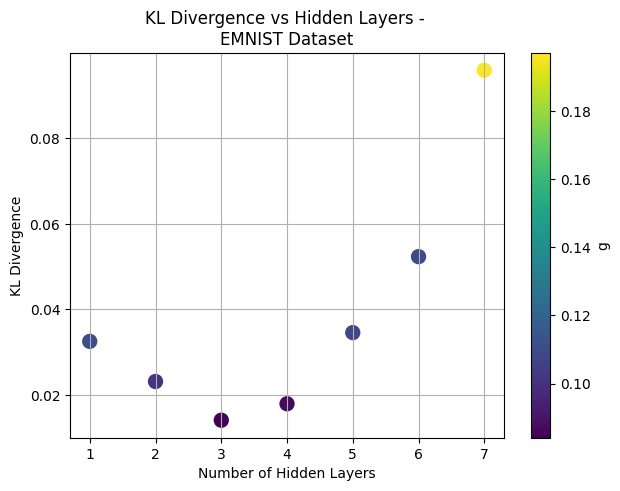

In [23]:

import pickle

with open('../savings/dataset_klds_dict_original_EMNIST.pkl', 'rb') as f:
    dataset_klds_dict_original_loaded = pickle.load(f)
with open('../savings/dataset_gs_dict_original_EMNIST.pkl', 'rb') as f:
    dataset_gs_dict_original_loaded = pickle.load(f)

mean_klds_comparison_EMNIST= {}
mean_gs_comparison_EMNIST= {}

save_dir = None
mean_klds_original = mean_over_outer_dict(dataset_klds_dict_original_loaded, selected_train_nums=range(6))
mean_gs_original = mean_over_outer_dict(dataset_gs_dict_original_loaded, selected_train_nums=range(6))
plot_KLs_vs_hidden_layers(mean_klds_original[dataset], mean_gs_original[dataset], dataset, save_dir=save_dir)
mean_klds_comparison_EMNIST["EMNISToriginal"] = mean_klds_original[dataset]
mean_gs_comparison_EMNIST["EMNISToriginal"] = mean_gs_original[dataset]

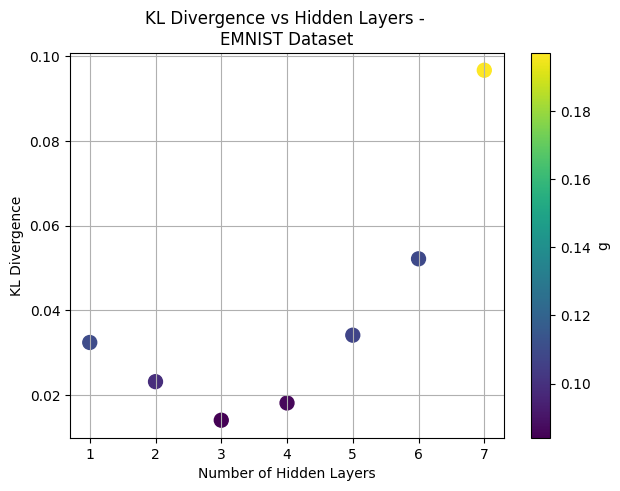

In [36]:
save_dir = None
mean_klds_original = mean_over_outer_dict(dataset_klds_dict_original, selected_train_nums=(0,1,2,3,4,5))
mean_gs_original = mean_over_outer_dict(dataset_gs_dict_original, selected_train_nums=(0,1,2,3,4,5))
plot_KLs_vs_hidden_layers(mean_klds_original[dataset], mean_gs_original[dataset], dataset, save_dir=save_dir)

In [37]:
mean_klds_comparison_EMNIST = {"EMNISToriginal": mean_klds_original[dataset]}
mean_gs_comparison_EMNIST = {"EMNISToriginal": mean_gs_original[dataset]}

## 2MNIST

In [37]:

dataset = "2MNIST"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 10,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}

In [39]:
dataset = "2MNIST"

num_hidden_layers_range = range(1,8)
for train_num in range(6):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict:
        dataset_klds_dict[train_num] = {'2MNIST': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict:
        dataset_gs_dict[train_num] = {'2MNIST': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        dataset_klds_dict=dataset_klds_dict[train_num],
        dataset_gs_dict=dataset_gs_dict[train_num]
    )



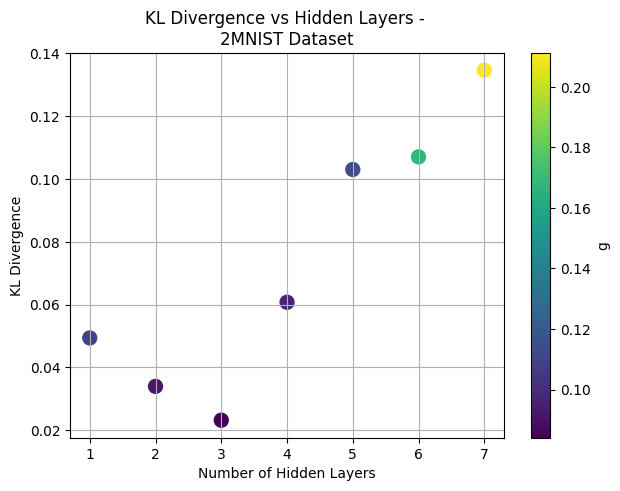

In [40]:
save_dir = None
mean_klds = mean_over_outer_dict(dataset_klds_dict, selected_train_nums=(0,1,2,3,4,5))
mean_gs = mean_over_outer_dict(dataset_gs_dict, selected_train_nums=(0,1,2,3,4,5))
plot_KLs_vs_hidden_layers(mean_klds[dataset], mean_gs[dataset], dataset, save_dir=save_dir)

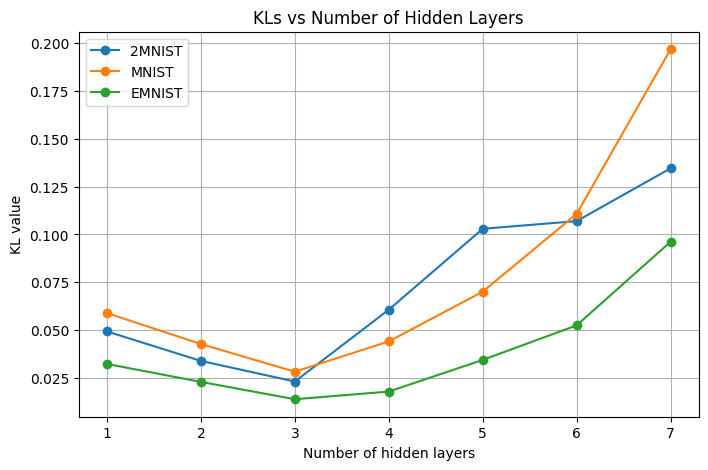

In [41]:
save_dir = None
datasets_dicts_comparison(mean_klds, save_dir)

## 2MNISTonly

In [41]:
dataset_klds_dict_original = {}
dataset_gs_dict_original = {}

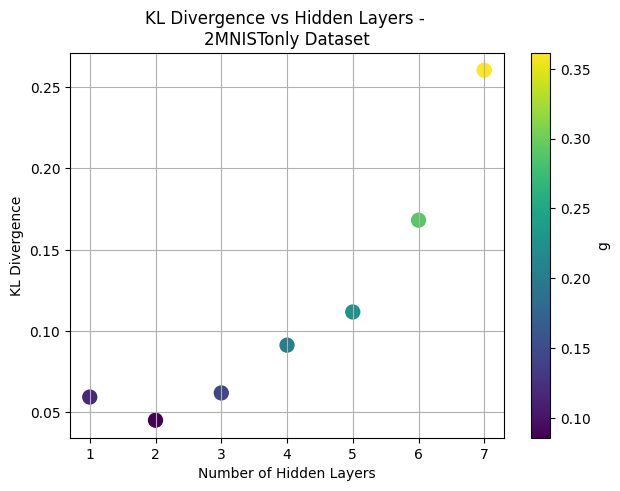

In [43]:

dataset = "2MNISTonly"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 10,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}
dataset = "2MNISTonly"

num_hidden_layers_range = range(1,8)
for train_num in range(6):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict_original:
        dataset_klds_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict_original:
        dataset_gs_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict_original[train_num], dataset_gs_dict_original[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        dataset_klds_dict=dataset_klds_dict_original[train_num],
        dataset_gs_dict=dataset_gs_dict_original[train_num]
    )


save_dir = None
mean_klds_original = mean_over_outer_dict(dataset_klds_dict_original, selected_train_nums=(0,1,2,3,4,5))
mean_gs_original = mean_over_outer_dict(dataset_gs_dict_original, selected_train_nums=(0,1,2,3,4,5))
plot_KLs_vs_hidden_layers(mean_klds_original[dataset], mean_gs_original[dataset], dataset, save_dir=save_dir)

In [44]:
import pickle
with open('../savings/dataset_klds_dict_original_2MNISTonly.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_original, f)
with open('../savings/dataset_gs_dict_original_2MNISTonly.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_original, f)

In [45]:
mean_klds_comparison["2MNISToriginal"] = mean_klds_original[dataset]
mean_gs_comparison["2MNISToriginal"] = mean_gs_original[dataset]

In [25]:

dataset = "2MNISTonly"

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 10,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}
dataset = "2MNISTonly"

dataset_klds_dict = {}
dataset_gs_dict = {}


1 hidden layers...
Calculating emp_states_dict_gauged
Computing emp_states_dict
Calculating optimal g and KL divergence


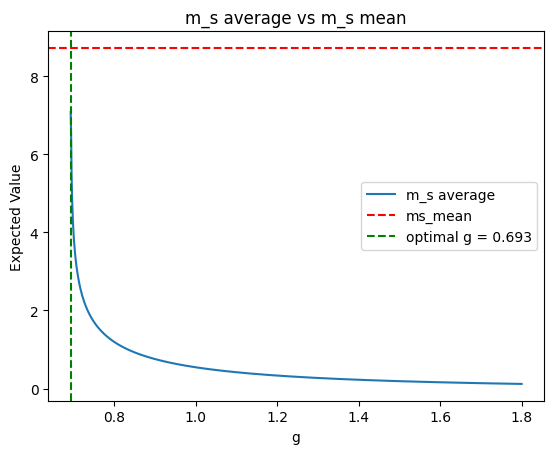

optimal_g: 0.6932471805599453
Calculating KL divergence with marginalized HFM
kl_div: 13.785215377807617
2 hidden layers...
Calculating emp_states_dict_gauged
Computing emp_states_dict
Calculating optimal g and KL divergence


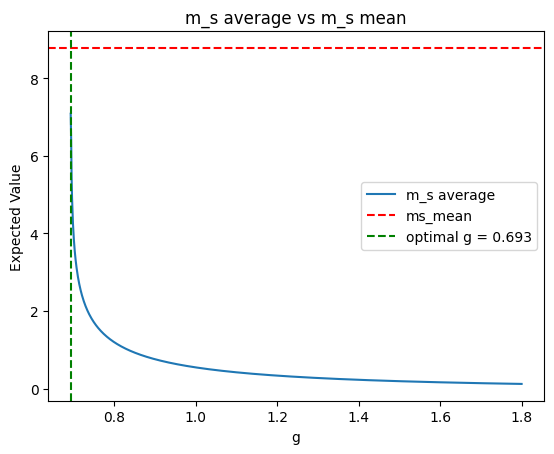

optimal_g: 0.6932471805599453
Calculating KL divergence with marginalized HFM
kl_div: 13.810921669006348
3 hidden layers...
Calculating emp_states_dict_gauged
Computing emp_states_dict


KeyboardInterrupt: 

In [33]:

num_hidden_layers_range = range(1,8)
for train_num in range(1):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict:
        dataset_klds_dict[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict:
        dataset_gs_dict[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict[train_num], dataset_gs_dict[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        hfm_distribution='marginalized',
        dataset_klds_dict=dataset_klds_dict[train_num],
        dataset_gs_dict=dataset_gs_dict[train_num]
    )


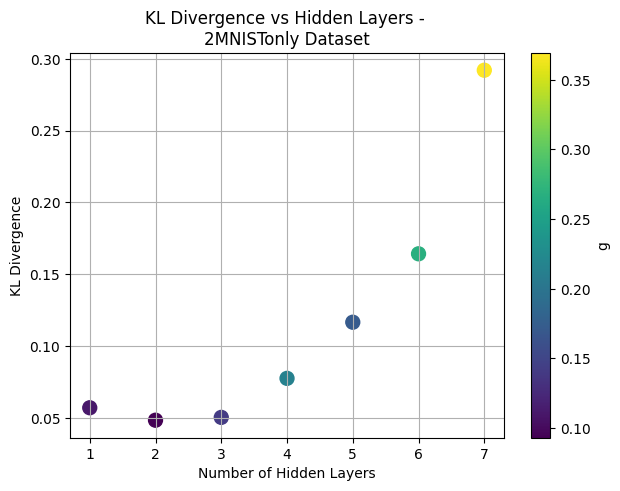

In [19]:
save_dir = None
mean_klds_original = mean_over_outer_dict(dataset_klds_dict, selected_train_nums=(0,))
mean_gs_original = mean_over_outer_dict(dataset_gs_dict, selected_train_nums=(0,))
plot_KLs_vs_hidden_layers(mean_klds_original[dataset], mean_gs_original[dataset], dataset, save_dir=save_dir)

# Mixed train

In [ ]:

dataset = "2MNISTonly"


dataset
model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': 10,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'mixed train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}


dataset_klds_dict_mixed = {}
dataset_gs_dict_mixed = {}

num_hidden_layers_range = range(1,8)
for train_num in range(0,18):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict_mixed:
        dataset_klds_dict_mixed[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict_mixed:
        dataset_gs_dict_mixed[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict_mixed[train_num], dataset_gs_dict_mixed[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        dataset_klds_dict=dataset_klds_dict_mixed[train_num],
        dataset_gs_dict=dataset_gs_dict_mixed[train_num]
    )



## comparisons

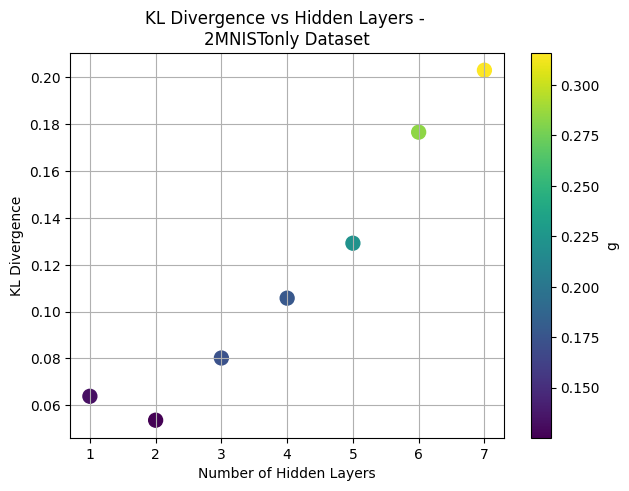

In [123]:
with open(f'../savings/dataset_klds_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_klds_dict_mixed = pickle.load(f)
with open(f'../savings/dataset_gs_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_gs_dict_mixed = pickle.load(f)

save_dir = None
mean_klds_mixed = mean_over_outer_dict(dataset_klds_dict_mixed, selected_train_nums=range(0,18))
mean_gs_mixed = mean_over_outer_dict(dataset_gs_dict_mixed, selected_train_nums=range(0,18))
plot_KLs_vs_hidden_layers(mean_klds_mixed[dataset], mean_gs_mixed[dataset], dataset, save_dir=save_dir)


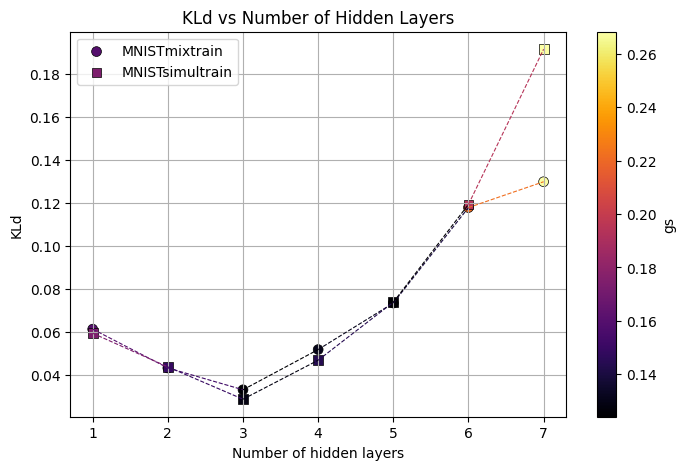

In [127]:

datasets_dicts_comparison_colored(mean_klds_comparison_MNIST, mean_gs_comparison_MNIST, save_dir)

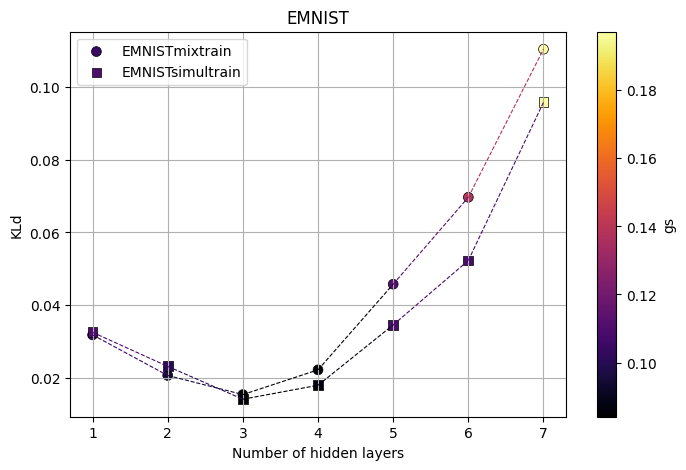

In [ ]:
dataset = "2MNISTonly"

with open(f'../savings/dataset_klds_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_klds_dict_mixed = pickle.load(f)
with open(f'../savings/dataset_gs_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_gs_dict_mixed = pickle.load(f)

save_dir = None
mean_klds_mixed = mean_over_outer_dict(dataset_klds_dict_mixed, selected_train_nums=range(0,18))
mean_gs_mixed = mean_over_outer_dict(dataset_gs_dict_mixed, selected_train_nums=range(0,18))



mean_klds_comparison = {}
mean_gs_comparison = {}

mean_klds_comparison[f"{dataset}mixtrain"] = mean_klds_mixed[dataset]
mean_gs_comparison[f"{dataset}mixtrain"] = mean_gs_mixed[dataset]


with open(f'../savings/dataset_klds_dict_original_{dataset}.pkl', 'rb') as f:
    dataset_klds_dict_original = pickle.load(f)
with open(f'../savings/dataset_gs_dict_original_{dataset}.pkl', 'rb') as f:
    dataset_gs_dict_original = pickle.load(f)

save_dir = None
mean_klds_original = mean_over_outer_dict(dataset_klds_dict_original, selected_train_nums=range(0,6))
mean_gs_original = mean_over_outer_dict(dataset_gs_dict_original, selected_train_nums=range(0,6))


mean_klds_comparison[f"{dataset}simultrain"] = mean_klds_original[dataset]
mean_gs_comparison[f"{dataset}simultrain"] = mean_gs_original[dataset]


datasets_dicts_comparison_colored(mean_klds_comparison, mean_gs_comparison, save_dir, dataset)

In [146]:
dataset = "MNIST"

with open(f'../savings/dataset_klds_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_klds_dict_mixed = pickle.load(f)
with open(f'../savings/dataset_gs_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_gs_dict_mixed = pickle.load(f)

save_dir = None
mean_klds_mixed = mean_over_outer_dict(dataset_klds_dict_mixed, selected_train_nums=range(0,18))
mean_gs_mixed = mean_over_outer_dict(dataset_gs_dict_mixed, selected_train_nums=range(0,18))



# mean_klds_comparison = {}
# mean_gs_comparison = {}

mean_klds_comparison[f"{dataset}mixtrain"] = mean_klds_mixed[dataset]
mean_gs_comparison[f"{dataset}mixtrain"] = mean_gs_mixed[dataset]


# with open(f'../savings/dataset_klds_dict_original_{dataset}.pkl', 'rb') as f:
#     dataset_klds_dict_original = pickle.load(f)
# with open(f'../savings/dataset_gs_dict_original_{dataset}.pkl', 'rb') as f:
#     dataset_gs_dict_original = pickle.load(f)

# save_dir = None
# mean_klds_original = mean_over_outer_dict(dataset_klds_dict_original, selected_train_nums=range(0,6))
# mean_gs_original = mean_over_outer_dict(dataset_gs_dict_original, selected_train_nums=range(0,6))


# mean_klds_comparison[f"{dataset}simultrain"] = mean_klds_original[dataset]
# mean_gs_comparison[f"{dataset}simultrain"] = mean_gs_original[dataset]


# datasets_dicts_comparison_colored(mean_klds_comparison, mean_gs_comparison, save_dir)

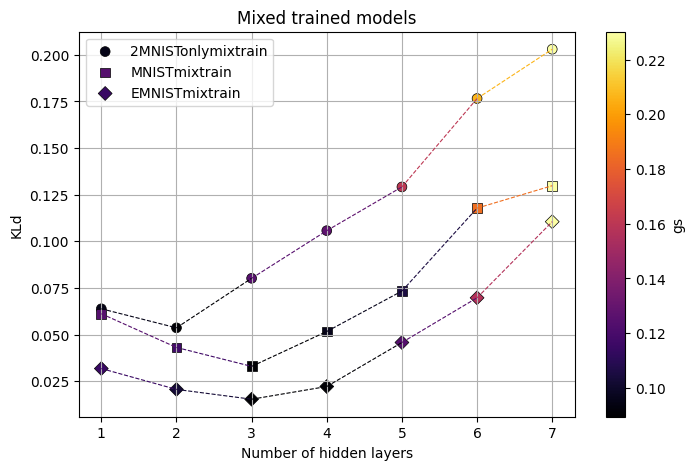

In [147]:
dataset = "EMNIST"

with open(f'../savings/dataset_klds_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_klds_dict_mixed = pickle.load(f)
with open(f'../savings/dataset_gs_dict_mixed_{dataset}_0_17.pkl', 'rb') as f:
    dataset_gs_dict_mixed = pickle.load(f)

save_dir = None
mean_klds_mixed = mean_over_outer_dict(dataset_klds_dict_mixed, selected_train_nums=range(0,18))
mean_gs_mixed = mean_over_outer_dict(dataset_gs_dict_mixed, selected_train_nums=range(0,18))



# mean_klds_comparison = {}
# mean_gs_comparison = {}

mean_klds_comparison[f"{dataset}mixtrain"] = mean_klds_mixed[dataset]
mean_gs_comparison[f"{dataset}mixtrain"] = mean_gs_mixed[dataset]


# with open(f'../savings/dataset_klds_dict_original_{dataset}.pkl', 'rb') as f:
#     dataset_klds_dict_original = pickle.load(f)
# with open(f'../savings/dataset_gs_dict_original_{dataset}.pkl', 'rb') as f:
#     dataset_gs_dict_original = pickle.load(f)

# save_dir = None
# mean_klds_original = mean_over_outer_dict(dataset_klds_dict_original, selected_train_nums=range(0,6))
# mean_gs_original = mean_over_outer_dict(dataset_gs_dict_original, selected_train_nums=range(0,6))


# mean_klds_comparison[f"{dataset}simultrain"] = mean_klds_original[dataset]
# mean_gs_comparison[f"{dataset}simultrain"] = mean_gs_original[dataset]


datasets_dicts_comparison_colored(mean_klds_comparison, mean_gs_comparison, save_dir, "Mixed trained models")

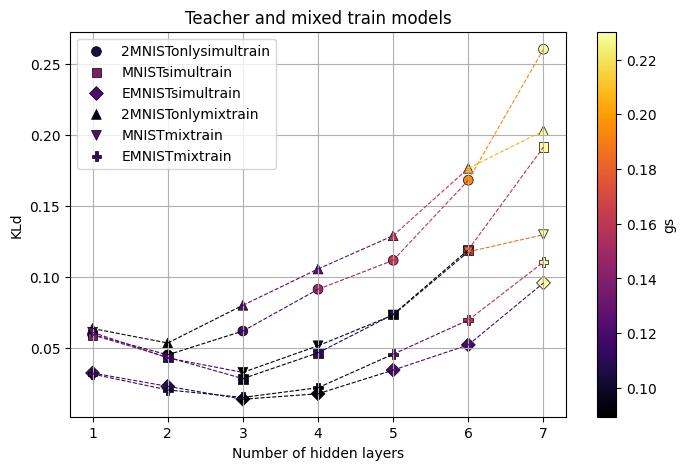

In [144]:
datasets_dicts_comparison_colored(mean_klds_comparison, mean_gs_comparison, save_dir, "Teacher and mixed train models")

# Sigmoid output comparisons

## Base

In [2]:
from AE.depth_utils import mean_over_outer_dict

In [ ]:

dataset = "2MNISTonly"
latent_dim = 8

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': latent_dim,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}


dataset_klds_dict_original = {}
dataset_gs_dict_original = {}

num_hidden_layers_range = range(1,8)
for train_num in range(6):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict_original:
        dataset_klds_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict_original:
        dataset_gs_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict_original[train_num], dataset_gs_dict_original[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        dataset_klds_dict=dataset_klds_dict_original[train_num],
        dataset_gs_dict=dataset_gs_dict_original[train_num]
    )


import pickle

with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original_{dataset}.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_original, f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original_{dataset}.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_original, f)



In [ ]:

dataset = "2MNISTonly"
latent_dim = 8

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': latent_dim,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'dataset': dataset,
    'decrease_rate': '06',
    'train_num': 0
}


dataset_klds_dict_original = {}
dataset_gs_dict_original = {}

num_hidden_layers_range = range(1,8)
for train_num in range(6):
    model_path_kwargs['train_num'] = train_num

    if train_num not in dataset_klds_dict_original:
        dataset_klds_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}
    if train_num not in dataset_gs_dict_original:
        dataset_gs_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}

    dataset_klds_dict_original[train_num], dataset_gs_dict_original[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
        dataset=dataset,
        data_loader=train_loaders[dataset],
        model_kwargs=model_kwargs,
        device=device,
        model_path_kwargs=model_path_kwargs,
        num_hidden_layers_range=num_hidden_layers_range,
        dataset_klds_dict=dataset_klds_dict_original[train_num],
        dataset_gs_dict=dataset_gs_dict_original[train_num]
    )


import pickle

with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original_{dataset}.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_original, f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original_{dataset}.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_original, f)

In [ ]:

dataset = "2MNISTonly"
latent_dim = 8

for i, dataset in enumerate(("2MNISTonly", "MNIST", "EMNIST")):
    model_kwargs = {
        'input_dim': 28*28,
        'latent_dim': latent_dim,
        'decrease_rate': 0.6,
        'device': device,
        'output_activation_encoder': nn.Sigmoid
    }
    model_path_kwargs = {
        'output_activation_encoder': 'sigmoid output',
        'train_type': 'simultaneous train',
        'latent_dim': f"{model_kwargs['latent_dim']}ld",
        'dataset': dataset,
        'decrease_rate': '06',
        'train_num': 0
    }


    if i == 0:
        dataset_klds_dict_original = {}
        dataset_gs_dict_original = {}

    num_hidden_layers_range = range(1,8)
    for train_num in range(6):
        model_path_kwargs['train_num'] = train_num

        if train_num not in dataset_klds_dict_original:
            dataset_klds_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}
        if train_num not in dataset_gs_dict_original:
            dataset_gs_dict_original[train_num] = {'2MNISTonly': [], 'MNIST': [], 'EMNIST': []}

        dataset_klds_dict_original[train_num], dataset_gs_dict_original[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
            dataset=dataset,
            data_loader=train_loaders[dataset],
            model_kwargs=model_kwargs,
            device=device,
            model_path_kwargs=model_path_kwargs,
            num_hidden_layers_range=num_hidden_layers_range,
            dataset_klds_dict=dataset_klds_dict_original[train_num],
            dataset_gs_dict=dataset_gs_dict_original[train_num]
        )


import pickle

with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_original, f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_original, f)

In [23]:

with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original_EMNIST.pkl', 'rb') as f:
    dataset_klds_dict_loaded = pickle.load(f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original_EMNIST.pkl', 'rb') as f:
    dataset_gs_dict_loaded = pickle.load(f)

print(dataset_klds_dict_loaded)
print(dataset_gs_dict_loaded)

{0: {'2MNISTonly': [], 'MNIST': [tensor(0.0796), tensor(0.0587), tensor(0.0445), tensor(0.0737), tensor(0.1513), tensor(0.1277), tensor(0.1542)], 'EMNIST': [tensor(0.0404), tensor(0.0379), tensor(0.0264), tensor(0.0401), tensor(0.0402), tensor(0.1145), tensor(0.1354)]}, 1: {'2MNISTonly': [], 'MNIST': [tensor(0.0884), tensor(0.0711), tensor(0.0456), tensor(0.0443), tensor(0.0965), tensor(0.1423), tensor(0.1669)], 'EMNIST': [tensor(0.0690), tensor(0.0408), tensor(0.0285), tensor(0.0447), tensor(0.0765), tensor(0.1591), tensor(0.2127)]}, 2: {'2MNISTonly': [], 'MNIST': [tensor(0.0935), tensor(0.0692), tensor(0.0663), tensor(0.1029), tensor(0.1462), tensor(0.1566), tensor(0.1493)], 'EMNIST': [tensor(0.0697), tensor(0.0325), tensor(0.0219), tensor(0.0366), tensor(0.0653), tensor(0.0983), tensor(0.1309)]}, 3: {'2MNISTonly': [], 'MNIST': [tensor(0.0939), tensor(0.0772), tensor(0.0603), tensor(0.1067), tensor(0.1493), tensor(0.1998), tensor(0.2141)], 'EMNIST': [tensor(0.0589), tensor(0.0363), t

In [ ]:
for dataset in ('2MNISTonly', 'MNIST', 'EMNIST'):
    with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original_{dataset}.pkl', 'rb') as f:
        dataset_klds_dict_loaded = pickle.load(f)
    with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original_{dataset}.pkl', 'rb') as f:
        dataset_gs_dict_loaded = pickle.load(f)

for train_num in dataset_klds_dict_loaded_2MNISTonly:
    dataset_klds_dict_loaded[train_num]['2MNISTonly'] = dataset_klds_dict_loaded_2MNISTonly[train_num]['2MNISTonly']
    dataset_gs_dict_loaded[train_num]['2MNISTonly'] = dataset_gs_dict_loaded_2MNISTonly[train_num]['2MNISTonly']

In [25]:
print(dataset_klds_dict_loaded)
print(dataset_gs_dict_loaded)

with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_loaded, f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_loaded, f)

{0: {'2MNISTonly': [tensor(0.1541), tensor(0.1261), tensor(0.1210), tensor(0.1689), tensor(0.2400), tensor(0.3275), tensor(0.3231)], 'MNIST': [tensor(0.0796), tensor(0.0587), tensor(0.0445), tensor(0.0737), tensor(0.1513), tensor(0.1277), tensor(0.1542)], 'EMNIST': [tensor(0.0404), tensor(0.0379), tensor(0.0264), tensor(0.0401), tensor(0.0402), tensor(0.1145), tensor(0.1354)]}, 1: {'2MNISTonly': [tensor(0.1271), tensor(0.1058), tensor(0.1346), tensor(0.1655), tensor(0.2222), tensor(0.3198), tensor(0.2421)], 'MNIST': [tensor(0.0884), tensor(0.0711), tensor(0.0456), tensor(0.0443), tensor(0.0965), tensor(0.1423), tensor(0.1669)], 'EMNIST': [tensor(0.0690), tensor(0.0408), tensor(0.0285), tensor(0.0447), tensor(0.0765), tensor(0.1591), tensor(0.2127)]}, 2: {'2MNISTonly': [tensor(0.1386), tensor(0.1179), tensor(0.1246), tensor(0.2274), tensor(0.2473), tensor(0.3290), tensor(0.3489)], 'MNIST': [tensor(0.0935), tensor(0.0692), tensor(0.0663), tensor(0.1029), tensor(0.1462), tensor(0.1566), t

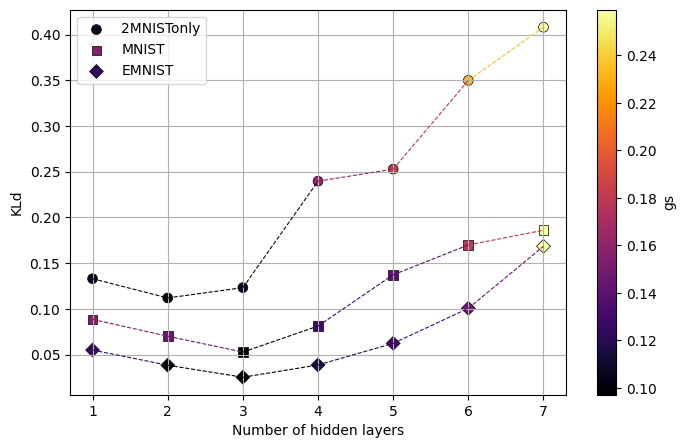

In [27]:
mean_klds = mean_over_outer_dict(dataset_klds_dict_loaded, selected_train_nums=range(6))
mean_gs = mean_over_outer_dict(dataset_gs_dict_loaded, selected_train_nums=range(6))
datasets_dicts_comparison_colored(mean_klds, mean_gs, "models")


## 10 ld

In [31]:
latent_dim = 10

dataset_klds_dict_loaded = {}
dataset_gs_dict_loaded = {}


with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original_2MNISTonly.pkl', 'rb') as f:
    dataset_klds_dict_loaded_2MNIST = pickle.load(f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original_2MNISTonly.pkl', 'rb') as f:
    dataset_gs_dict_loaded_2MNIST = pickle.load(f)


with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original_MNIST.pkl', 'rb') as f:
    dataset_klds_dict_loaded_MNIST = pickle.load(f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original_MNIST.pkl', 'rb') as f:
    dataset_gs_dict_loaded_MNIST = pickle.load(f)


with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original_EMNIST.pkl', 'rb') as f:
    dataset_klds_dict_loaded = pickle.load(f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original_EMNIST.pkl', 'rb') as f:
    dataset_gs_dict_loaded = pickle.load(f)


print(dataset_klds_dict_loaded_2MNIST)
print(dataset_gs_dict_loaded_2MNIST)
print(dataset_klds_dict_loaded_MNIST)
print(dataset_gs_dict_loaded_MNIST) 


for i in range(len(dataset_klds_dict_loaded_2MNIST)):
    dataset_klds_dict_loaded[i]['2MNISTonly'] = dataset_klds_dict_loaded_2MNIST[i]['2MNISTonly']
    dataset_gs_dict_loaded[i]['2MNISTonly'] = dataset_gs_dict_loaded_2MNIST[i]['2MNISTonly']
    dataset_klds_dict_loaded[i]['MNIST'] = dataset_klds_dict_loaded_MNIST[i]['MNIST']
    dataset_gs_dict_loaded[i]['MNIST'] = dataset_gs_dict_loaded_MNIST[i]['MNIST']



print(dataset_klds_dict_loaded)
print(dataset_gs_dict_loaded)

{0: {'2MNISTonly': [tensor(0.0535), tensor(0.0452), tensor(0.0538), tensor(0.0811), tensor(0.1119), tensor(0.1596), tensor(0.2929)], 'MNIST': [], 'EMNIST': []}, 1: {'2MNISTonly': [tensor(0.0603), tensor(0.0464), tensor(0.0591), tensor(0.0669), tensor(0.0884), tensor(0.1978), tensor(0.2018)], 'MNIST': [], 'EMNIST': []}, 2: {'2MNISTonly': [tensor(0.0561), tensor(0.0454), tensor(0.0711), tensor(0.1024), tensor(0.1686), tensor(0.1905), tensor(0.2836)], 'MNIST': [], 'EMNIST': []}, 3: {'2MNISTonly': [tensor(0.0566), tensor(0.0397), tensor(0.0586), tensor(0.0833), tensor(0.1263), tensor(0.1321), tensor(0.3167)], 'MNIST': [], 'EMNIST': []}, 4: {'2MNISTonly': [tensor(0.0589), tensor(0.0545), tensor(0.0768), tensor(0.1331), tensor(0.0805), tensor(0.1569), tensor(0.3230)], 'MNIST': [], 'EMNIST': []}, 5: {'2MNISTonly': [tensor(0.0714), tensor(0.0403), tensor(0.0527), tensor(0.0814), tensor(0.0949), tensor(0.1723), tensor(0.1443)], 'MNIST': [], 'EMNIST': []}}
{0: {'2MNISTonly': [np.float64(0.117117

In [32]:
with open(f'../savings/{latent_dim}ld/dataset_klds_dict_original.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_loaded, f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_original.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_loaded, f)

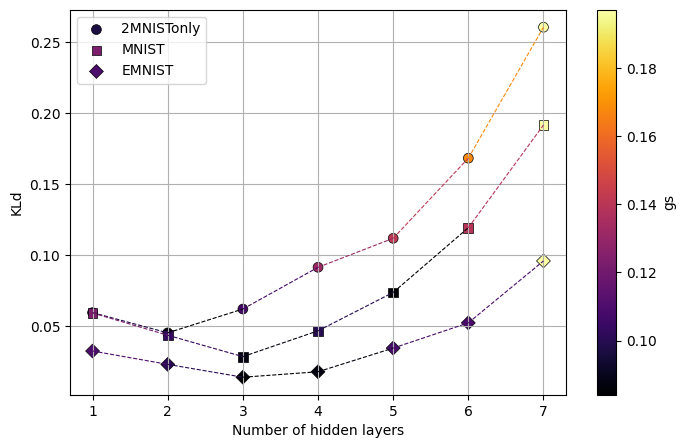

In [34]:
mean_klds = mean_over_outer_dict(dataset_klds_dict_loaded, selected_train_nums=range(6))
mean_gs = mean_over_outer_dict(dataset_gs_dict_loaded, selected_train_nums=range(6))
datasets_dicts_comparison_colored(mean_klds, mean_gs, "models")

## 14 ld

In [ ]:
mean_klds = mean_over_outer_dict(dataset_klds_dict_loaded, selected_train_nums=range(6))
mean_gs = mean_over_outer_dict(dataset_gs_dict_loaded, selected_train_nums=range(6))
datasets_dicts_comparison_colored(mean_klds, mean_gs, "models")

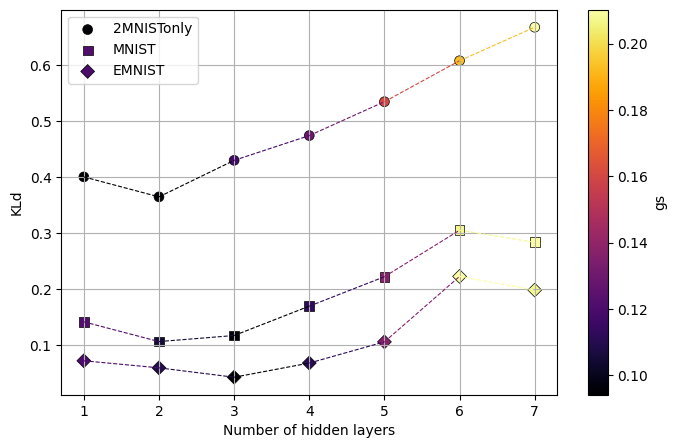

In [18]:
from AE.plotter_functions import datasets_dicts_comparison_colored
datasets_dicts_comparison_colored(mean_klds, mean_gs, "models")

## Plot klds clean

In [18]:
from AE.depth_utils import mean_over_outer_dict

In [20]:
latent_dim = 12

for i, dataset in enumerate(("2MNISTonly", "2MNIST", "MNIST", "EMNIST", "FEMNIST")):
    model_kwargs = {
        'input_dim': 28*28,
        'latent_dim': latent_dim,
        'decrease_rate': 0.6,
        'device': device,
        'output_activation_encoder': nn.Sigmoid
    }
    model_path_kwargs = {
        'output_activation_encoder': 'sigmoid output',
        'train_type': 'simultaneous train',
        'latent_dim': f"{model_kwargs['latent_dim']}ld",
        'dataset': dataset,
        'decrease_rate': '06',
        'train_num': 0
    }


    if i == 0:
        dataset_klds_dict_original = {}
        dataset_gs_dict_original = {}

    num_hidden_layers_range = range(1,8)
    for train_num in range(6):
        model_path_kwargs['train_num'] = train_num

        if train_num not in dataset_klds_dict_original:
            dataset_klds_dict_original[train_num] = {'2MNISTonly': [], "2MNIST": [], 'MNIST': [], 'EMNIST': [], 'FEMNIST': []}
        if train_num not in dataset_gs_dict_original:
            dataset_gs_dict_original[train_num] = {'2MNISTonly': [], "2MNIST": [], 'MNIST': [], 'EMNIST': [], 'FEMNIST': []}

        dataset_klds_dict_original[train_num], dataset_gs_dict_original[train_num] = compute_dataset_klds_gs_dict_from_sampled_binarized_vectors_(
            dataset=dataset,
            data_loader=train_loaders[dataset],
            model_kwargs=model_kwargs,
            device=device,
            model_path_kwargs=model_path_kwargs,
            num_hidden_layers_range=num_hidden_layers_range,
            dataset_klds_dict=dataset_klds_dict_original[train_num],
            dataset_gs_dict=dataset_gs_dict_original[train_num]
        )


import pickle

with open(f'../savings/{latent_dim}ld/dataset_klds_dict_sigmoid_output.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_original, f)
with open(f'../savings/{latent_dim}ld/dataset_gs_dict_sigmoid_output.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_original, f)

FileNotFoundError: [Errno 2] No such file or directory: '../savings/12ld/dataset_klds_dict_sigmoid_output.pkl'

In [21]:

with open(f'../savings/klds_gs/{latent_dim}ld/dataset_klds_dict_sigmoid_output.pkl', 'wb') as f:
    pickle.dump(dataset_klds_dict_original, f)
with open(f'../savings/klds_gs/{latent_dim}ld/dataset_gs_dict_sigmoid_output.pkl', 'wb') as f:
    pickle.dump(dataset_gs_dict_original, f)

In [22]:
with open(f'../savings/klds_gs/{latent_dim}ld/dataset_klds_dict_sigmoid_output.pkl', 'rb') as f:
    dataset_klds_dict_loaded = pickle.load(f)
with open(f'../savings/klds_gs/{latent_dim}ld/dataset_gs_dict_sigmoid_output.pkl', 'rb') as f:
    dataset_gs_dict_loaded = pickle.load(f)

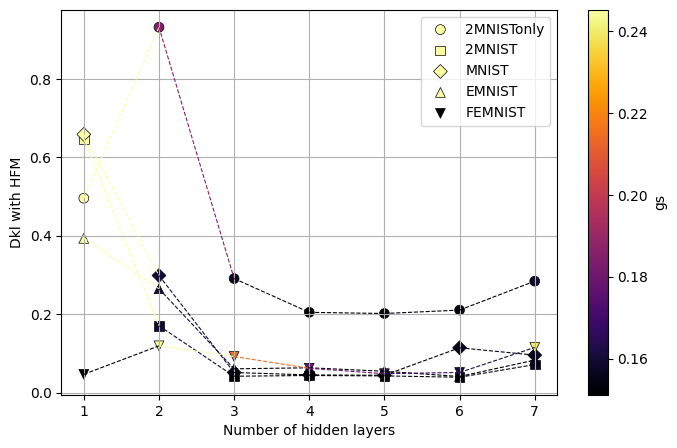

In [23]:
mean_klds = mean_over_outer_dict(dataset_klds_dict_loaded, selected_train_nums=range(6))
mean_gs = mean_over_outer_dict(dataset_gs_dict_loaded, selected_train_nums=range(6))
datasets_dicts_comparison_colored(mean_klds, mean_gs, "models")

# Plot loss

In [18]:
from AE.overlaps import load_model

In [25]:

def calc_MSE_loss(model, dataset_loader, l1_lambda=0.0, device=None):
    """
    Return the loss computed exactly as in the train(...) function:
    sum over batches of (MSE(output, data) + l1_lambda * sum(abs(params))) 
    divided by len(dataset_loader.dataset).
    """
    import torch
    import torch.nn as nn

    model.eval()
    if device is None:
        try:
            device = model.device
        except AttributeError:
            # fallback to first parameter device
            device = next(model.parameters()).device

    total_loss = 0.0
    mse = nn.MSELoss()
    with torch.no_grad():
        for data, _ in dataset_loader:
            data = data.to(device)
            output = model(data)
            batch_loss = mse(output, data)
            # L1 term added exactly as in train()
            l1_term = l1_lambda * sum(p.abs().sum() for p in model.parameters())
            total_loss += (batch_loss + l1_term).item()

    # Use same denominator as train(): len(dataset_loader.dataset) if available
    try:
        denom = len(dataset_loader.dataset)
    except Exception:
        # fallback: total number of samples iterated (approx)
        denom = sum(d.size(0) for d, _ in dataset_loader)

    return total_loss / denom

In [ ]:
# ...existing code...
def dataset_mse(model, data_loader, device=None):
    """
    Compute MSE over a whole dataset using the same per-batch mean loss as `train`.
    This matches train(...) which uses nn.MSELoss() (default reduction='mean'),
    accumulates batch losses and then divides by len(dataset).
    Args:
        model: torch.nn.Module (AE_0) - forward(x) should return reconstruction or (recon, ...)
        data_loader: torch.utils.data.DataLoader
        device: torch.device or None (if None, prefer model.device then model params)
    Returns:
        float: loss value computed the same way as in train()
    """
    import torch
    import torch.nn as nn
    import math

    model.eval()
    if device is None:
        device = getattr(model, "device", None)
        if device is None:
            try:
                device = next(model.parameters()).device
            except StopIteration:
                device = torch.device("cpu")

    loss_fn = nn.MSELoss(reduction='mean')  # default reduction='mean' to match train()
    total_loss = 0.0

    with torch.no_grad():
        for batch in data_loader:
            x = batch[0] if isinstance(batch, (list, tuple)) else batch
            x = x.to(device)
            out = model(x)
            recon = out[0] if isinstance(out, (list, tuple)) else out
            # ensure shapes compatible
            if recon.shape != x.shape and recon.dim() == 2 and x.dim() > 2 and recon.size(0) == x.size(0):
                recon = recon.view_as(x)
            total_loss += loss_fn(recon, x).item()

    dataset_size = len(getattr(data_loader, "dataset", []))
    return total_loss / dataset_size if dataset_size > 0 else float("nan")
# ...existing code...

In [39]:
latent_dim = 10

for i, dataset in enumerate(("2MNISTonly", "2MNIST", "MNIST", "EMNIST", "FEMNIST")):
    model_kwargs = {
        'input_dim': 28*28,
        'latent_dim': latent_dim,
        'decrease_rate': 0.6,
        'device': device,
        'output_activation_encoder': nn.Sigmoid
    }
    model_path_kwargs = {
        'output_activation_encoder': 'sigmoid output',
        'train_type': 'simultaneous train',
        'latent_dim': f"{model_kwargs['latent_dim']}ld",
        'dataset': dataset,
        'decrease_rate': '06',
        'train_num': 0
    }


    if i == 0:
        rep_dataset_train_loss_dict = {}
        rep_dataset_val_loss_dict = {}

    num_hidden_layers_range = range(1,8)
    for train_num in range(6):
        for num_hidden_layers in num_hidden_layers_range:
            model_path_kwargs['num_hidden_layers'] = num_hidden_layers
            model_kwargs['hidden_layers'] = num_hidden_layers
            model_path_kwargs['train_num'] = train_num

            if train_num not in rep_dataset_train_loss_dict:
                rep_dataset_train_loss_dict[train_num] = {'2MNISTonly': [], "2MNIST": [], 'MNIST': [], 'EMNIST': [], 'FEMNIST': []}
            if train_num not in rep_dataset_val_loss_dict:
                rep_dataset_val_loss_dict[train_num] = {'2MNISTonly': [], "2MNIST": [], 'MNIST': [], 'EMNIST': [], 'FEMNIST': []}

            model = load_model(model_path_kwargs, model_kwargs)

            rep_dataset_train_loss_dict[train_num][dataset].append(calc_MSE_loss(model, train_loaders[dataset], device=device))
            rep_dataset_val_loss_dict[train_num][dataset].append(calc_MSE_loss(model, val_loaders[dataset], device=device))

In [40]:
import pickle

with open(f'../savings/losses/{latent_dim}ld/rep_dataset_train_loss_dict.pkl', 'wb') as f:
    pickle.dump(rep_dataset_train_loss_dict, f)

with open(f'../savings/losses/{latent_dim}ld/rep_dataset_val_loss_dict.pkl', 'wb') as f:
    pickle.dump(rep_dataset_val_loss_dict, f)


In [41]:
with open(f'../savings/losses/sigmoid decoder output/{latent_dim}ld/rep_dataset_train_loss_dict.pkl', 'rb') as f:
    rep_dataset_train_loss_dict_loaded_sigmoid = pickle.load(f)

with open(f'../savings/losses/sigmoid decoder output/{latent_dim}ld/rep_dataset_val_loss_dict.pkl', 'rb') as f:
    rep_dataset_val_loss_dict_loaded_sigmoid = pickle.load(f)

with open(f'../savings/losses/{latent_dim}ld/rep_dataset_train_loss_dict.pkl', 'rb') as f:
    rep_dataset_train_loss_dict_loaded = pickle.load(f)

with open(f'../savings/losses/{latent_dim}ld/rep_dataset_val_loss_dict.pkl', 'rb') as f:
    rep_dataset_val_loss_dict_loaded = pickle.load(f)


In [50]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_loss_over_depth(rep_dataset_train_loss_dict,
                              datasets=None,
                              num_hidden_layers_range=range(1,8),
                              show_std=True,
                              figsize=(8,5),
                              title="Mean loss vs # hidden layers",
                              xlabel="Number of hidden layers",
                              ylabel="MSE",
                              save_path=None,
                              show_legend=True,
                              ax=None):
    """
    Compute mean (and std) across train_num realizations and plot loss vs depth.
    Args:
        rep_dataset_train_loss_dict: dict keyed by train_num -> dict(dataset -> list(losses per depth))
        datasets: list of dataset names to plot (default: keys from first inner dict)
        num_hidden_layers_range: iterable of depth values (default 1..7)
        show_std: if True fill ±1 std region
        figsize, title, xlabel, ylabel: plot params
        save_path: if given, save figure to path
        ax: optional matplotlib Axes to draw into
    Returns:
        mean_dict, std_dict: dicts dataset -> list(mean), dataset -> list(std)
    """
    # collect train_nums
    train_nums = sorted(rep_dataset_train_loss_dict.keys())
    if len(train_nums) == 0:
        raise ValueError("rep_dataset_train_loss_dict is empty")

    # infer datasets
    first_inner = rep_dataset_train_loss_dict[train_nums[0]]
    if datasets is None:
        datasets = list(first_inner.keys())

    # prepare output
    mean_dict = {}
    std_dict = {}

    depths = list(num_hidden_layers_range)

    for ds in datasets:
        # gather lists from each train_num if available
        rows = []
        for tn in train_nums:
            inner = rep_dataset_train_loss_dict.get(tn, {})
            vals = inner.get(ds)
            if vals is None:
                continue
            # ensure it's a numpy 1d array
            rows.append(np.asarray(vals))

        if len(rows) == 0:
            # no data for this dataset
            mean_dict[ds] = []
            std_dict[ds] = []
            continue

        # align lengths: use minimum available length across realizations
        min_len = min(r.shape[0] for r in rows)
        stacked = np.vstack([r[:min_len] for r in rows])
        mean = stacked.mean(axis=0)
        std = stacked.std(axis=0)

        mean_dict[ds] = mean.tolist()
        std_dict[ds] = std.tolist()

    # plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for ds, mean in mean_dict.items():
        if ds == '2MNIST':
            ds = '2MNIST+'
        if ds == '2MNISTonly':
            ds = '2MNIST'
        if len(mean) == 0:
            continue
        x_plot = depths[:len(mean)]
        ax.plot(x_plot, mean, marker='o', label=ds, linewidth=1.5, markersize=3)
        if show_std and len(std_dict.get(ds, [])) == len(mean):
            std = np.asarray(std_dict[ds])
            ax.fill_between(x_plot, np.asarray(mean)-std, np.asarray(mean)+std, alpha=0.25)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(depths)
    ax.grid(False)
    if show_legend:
        ax.legend()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    return mean_dict, std_dict
# ...existing code...

In [52]:
# ...existing code...
def plot_mean_loss_over_depth(rep_dataset_train_loss_dict,
                              datasets=None,
                              num_hidden_layers_range=range(1,8),
                              show_std=True,
                              figsize=(8,5),
                              title="Mean loss vs # hidden layers",
                              xlabel="Number of hidden layers",
                              ylabel="MSE",
                              save_path=None,
                              show_legend=True,
                              ax=None,
                              cmap='tab10'):  # added cmap param
    """
    Compute mean (and std) across train_num realizations and plot loss vs depth.
    ...
    Args:
        ...
        cmap: matplotlib colormap name or Colormap instance used to color datasets
    ...
    """
    # collect train_nums
    train_nums = sorted(rep_dataset_train_loss_dict.keys())
    if len(train_nums) == 0:
        raise ValueError("rep_dataset_train_loss_dict is empty")

    # infer datasets
    first_inner = rep_dataset_train_loss_dict[train_nums[0]]
    if datasets is None:
        datasets = list(first_inner.keys())

    # prepare output
    mean_dict = {}
    std_dict = {}

    depths = list(num_hidden_layers_range)

    for ds in datasets:
        # gather lists from each train_num if available
        rows = []
        for tn in train_nums:
            inner = rep_dataset_train_loss_dict.get(tn, {})
            vals = inner.get(ds)
            if vals is None:
                continue
            # ensure it's a numpy 1d array
            rows.append(np.asarray(vals))

        if len(rows) == 0:
            # no data for this dataset
            mean_dict[ds] = []
            std_dict[ds] = []
            continue

        # align lengths: use minimum available length across realizations
        min_len = min(r.shape[0] for r in rows)
        stacked = np.vstack([r[:min_len] for r in rows])
        mean = stacked.mean(axis=0)
        std = stacked.std(axis=0)

        mean_dict[ds] = mean.tolist()
        std_dict[ds] = std.tolist()

    # plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # prepare colors from cmap
    import matplotlib as mpl
    cmap_obj = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap
    n = max(1, len(mean_dict))
    # sample colormap evenly
    colors = [cmap_obj(i/(n-1)) if n>1 else cmap_obj(0) for i in range(n)]

    for idx, (ds_key, mean) in enumerate(mean_dict.items()):
        display_ds = ds_key
        if ds_key == '2MNIST':
            display_ds = '2MNIST+'
        if ds_key == '2MNISTonly':
            display_ds = '2MNIST'
        if len(mean) == 0:
            continue
        x_plot = depths[:len(mean)]
        color = colors[idx]
        ax.plot(x_plot, mean, marker='o', label=display_ds, linewidth=1.5, markersize=3, color=color)
        if show_std and len(std_dict.get(ds_key, [])) == len(mean):
            std = np.asarray(std_dict[ds_key])
            ax.fill_between(x_plot, np.asarray(mean)-std, np.asarray(mean)+std, alpha=0.25, color=color)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(depths)
    ax.grid(False)
    if show_legend:
        ax.legend()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    return mean_dict, std_dict
# ...existing code...

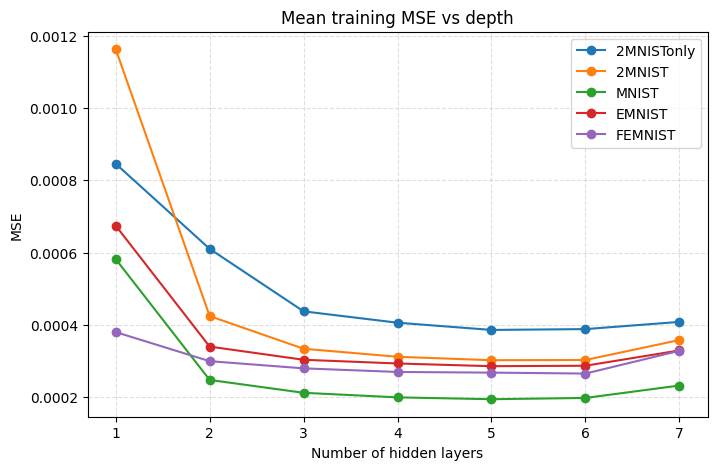

In [38]:
# compute and plot mean train loss over depths
mean_losses, std_losses = plot_mean_loss_over_depth(rep_dataset_val_loss_dict_loaded_sigmoid,
                                                    datasets=['2MNISTonly','2MNIST','MNIST','EMNIST','FEMNIST'],
                                                    num_hidden_layers_range=range(1,8),
                                                    show_std=False,
                                                    title="Mean training MSE vs depth",
                                                    save_path=None)
plt.show()

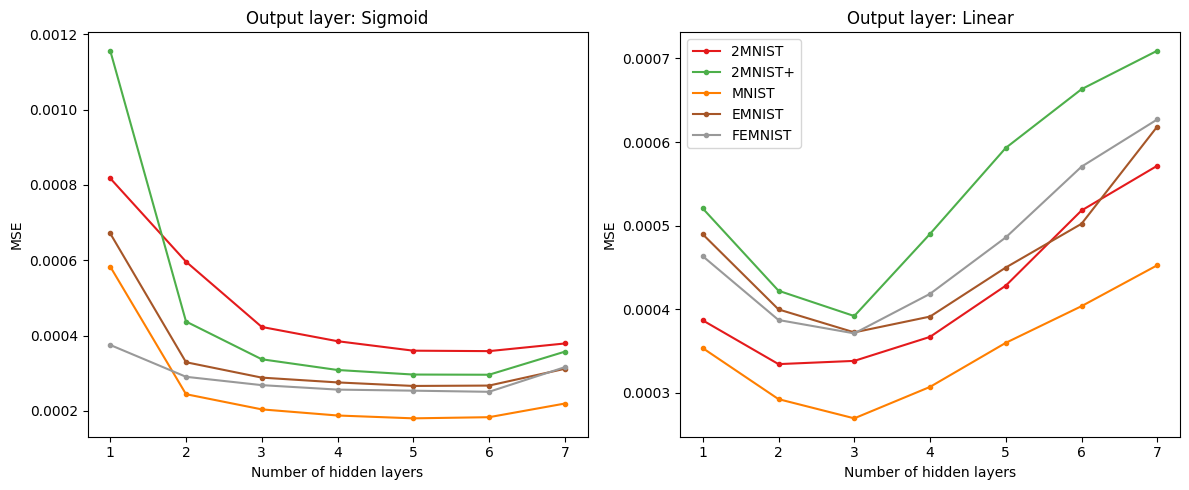

In [66]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_mean_loss_over_depth(rep_dataset_train_loss_dict_loaded_sigmoid,
                          datasets=['2MNISTonly', '2MNIST', 'MNIST','EMNIST', 'FEMNIST'],
                          num_hidden_layers_range=range(1,8),
                          show_std=False,
                          title='Output layer: Sigmoid',
                          show_legend=False,
                          cmap='Set1',
                          ax=axs[0])
plot_mean_loss_over_depth(rep_dataset_train_loss_dict_loaded,
                          datasets=['2MNISTonly', '2MNIST', 'MNIST','EMNIST', 'FEMNIST'],
                          num_hidden_layers_range=range(1,8),
                          show_std=False,
                          title='Output layer: Linear',
                          ax=axs[1],
                          cmap='Set1')
plt.tight_layout()
plt.show()